# <h1><center>Airbnb NYC Listing Price Predictor

![Image of New York City Apartment](nasa-_SFJhRPzJHs-unsplash.jpg)

## Introduction

The dataset consists of scraped Airbnb NYC data from all live listings from June 6-7, 2019. The original dataset consists of 256 individual features, consisting of host details, listing location, past rental details, guest reviews, and property amenities. 

The independent variable of the data is price, which is the price per listing per night.

In order to improve prediction accuracy and limit our data to more standard Airbnb listings, we will remove outlier data from extremely luxurious listings that are astronomically more expensive than more standard Airbnb's. The maximum price/night we will use is the tukey outlier threshold of $323 as we will see below.

## Goals of the Project

The goal of this project is to create a machine learning model that can predict the price of a standard Airbnb in New York City based on the listing's features and amenities in the dataset (ie # bedrooms, TV, WiFi, etc). We will also analyze the listings data using exploratory data analysis to pull insights that will help Airbnb to raise revenues and increase efficiency.

# Importing the Data

In [385]:
# Common imports
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import os
import pprint
import missingno
import thinkstats2
import thinkplot
import scipy
from numpy import median

# Timing models
import math, time, datetime

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rc('axes', labelsize=18)
#mpl.rc('xtick', labelsize=16)
#mpl.rc('ytick', labelsize=16)
import seaborn as sns

# Warnings
import warnings
# to change warnings in functions:
#warnings.filterwarnings('always')  # "error", "ignore", "always", "default", "module" or "once"
# to reset warnings:
#warnings.resetwarnings()

# Where to save the figures
PROJECT_ROOT_DIR = '/Users/Gregs_Computer/Documents/Studies/Data_Science/Projects/Airbnb NYC/'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'Images')
os.makedirs(IMAGES_PATH, exist_ok=True)

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, 'images', fig_id)

def save_fig(fig_id, tight_layout=True):
    print('Saving figure', fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + '.png', format='png', dpi=300)
    
{
"tags": [
    "remove_cell",
]
}

{'tags': ['remove_cell']}

Data retrieved from: http://insideairbnb.com/get-the-data.html.

Here we view the first 5 rows of the DataFrame to get an idea of the data's layout and features.

In [2]:
# Import Listings Data
listings_original = pd.read_csv(os.path.join(PROJECT_ROOT_DIR, 'Data', 'listings.csv'))
listings_original.head()

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (43,61,62,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2539,https://www.airbnb.com/rooms/2539,20190602163209,2019-06-03,Clean & quiet apt home by the park,Renovated apt home in elevator building.,"Spacious, renovated, and clean apt home, one b...",Renovated apt home in elevator building. Spaci...,none,Close to Prospect Park and Historic Ditmas Park,If this room is unavailable on your desired da...,Very close to F and G trains and Express bus i...,NaN,NaN,-The security and comfort of all our guests is...,NaN,NaN,https://a0.muscache.com/im/pictures/3949d073-a...,NaN,2787,https://www.airbnb.com/users/show/2787,John,2008-09-07,"New York, New York, United States",Educated professional living in Brooklyn. I l...,within an hour,100%,NaN,f,https://a0.muscache.com/im/pictures/8674565a-7...,https://a0.muscache.com/im/pictures/8674565a-7...,Gravesend,6.0,6.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Brooklyn , NY, United States",Brooklyn,Kensington,Brooklyn,Brooklyn,NY,11218,New York,"Brooklyn , NY",US,United States,40.64749,-73.97237,f,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Wheelchair acces...",NaN,$149.00,$299.00,$999.00,$100.00,$25.00,1,$35.00,1,730,1,1,730,730,1.0,730.0,3 days ago,t,30,60,90,365,2019-06-03,9,2,2015-12-04,2018-10-19,98.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,NaN,f,f,moderate,f,f,6,0,5,1,0.21
1,2595,https://www.airbnb.com/rooms/2595,20190602163209,2019-06-03,Skylit Midtown Castle,"Find your romantic getaway to this beautiful, ...","- Spacious (500+ft²), immaculate and nicely fu...","Find your romantic getaway to this beautiful, ...",none,Centrally located in the heart of Manhattan ju...,NaN,Apartment is located on 37th Street between 5t...,"Guests have full access to the kitchen, bathro...",I am a Sound Therapy Practitioner and Kundalin...,"Make yourself at home, respect the space and t...",NaN,NaN,https://a0.muscache.com/im/pictures/f0813a11-4...,NaN,2845,https://www.airbnb.com/users/show/2845,Jennifer,2008-09-09,"New York, New York, United States",A New Yorker since 2000! My passion is creatin...,within a few hours,83%,NaN,f,https://a0.muscache.com/im/users/2845/profile_...,https://a0.muscache.com/im/users/2845/profile_...,Midtown,5.0,5.0,"['email', 'phone', 'reviews', 'kba', 'work_ema...",t,t,"New York, NY, United States",Ma

In [3]:
# Shape of original data
listings_original.shape

(48801, 106)

# Cleaning the Data

We will begin by splitting the data into train and test sets. We will only be observing the training set to avoid any bias from assumptions made based on the testing data. We will not touch the testing data until our final model is ready for production to test its accuracy.

In [4]:
# Copy original DataFrame
listings = listings_original.copy(deep=True)

In [5]:
# Create train/test sets
from sklearn.model_selection import train_test_split
listings_train, listings_test = train_test_split(listings.copy(),
                                                 test_size=0.2, random_state=42)

In [6]:
# Shape of training data
listings_train.shape

(39040, 106)

We will now copy our training data as an exploratory DataFrame that we can experimentally modify without affecting our original training set.

In [7]:
# Copy listings_train for data exploration
listings_explore = listings_train.copy(deep=True)

In [8]:
# dtypes of each feature
#listings_explore.info(verbose=True)

### Check for Missing Values

We will now check for missing values by creating a `find_missing_values` function to get an idea of which features require immediate deletion or imputation. As a general rule of thumb used here: if a feature is missing more than 20-30% of its values, it requires immediate deletion because imputation will bias the results too heavily.

In [9]:
# View missing values
def find_missing_values(df, columns):
    '''
    Finds number of rows where certain columns are missing values.
    ::param_df:: = target dataframe (ie train)
    ::param_columns:: = list of columns (train.columns)
    '''
    missing_vals = {}
    print('Number of missing or NaN values for each column:')
    df_length = len(df)
    for column in columns:
        total_column_values = df[column].value_counts().sum()
        missing_vals[column] = df_length - total_column_values
        # missing_vals.append(str(column + ' column has {} missing or NaN values.'.format())
    return missing_vals

missing_values = find_missing_values(listings_explore, listings_explore.columns)
missing_values

Number of missing or NaN values for each column:


{'id': 0,
 'listing_url': 0,
 'scrape_id': 0,
 'last_scraped': 0,
 'name': 12,
 'summary': 1567,
 'space': 11387,
 'description': 576,
 'experiences_offered': 0,
 'neighborhood_overview': 14107,
 'notes': 22863,
 'transit': 13711,
 'access': 17065,
 'interaction': 16139,
 'house_rules': 15110,
 'thumbnail_url': 39040,
 'medium_url': 39040,
 'picture_url': 0,
 'xl_picture_url': 39040,
 'host_id': 0,
 'host_url': 0,
 'host_name': 10,
 'host_since': 10,
 'host_location': 129,
 'host_about': 14855,
 'host_response_time': 13133,
 'host_response_rate': 13133,
 'host_acceptance_rate': 39040,
 'host_is_superhost': 10,
 'host_thumbnail_url': 10,
 'host_picture_url': 10,
 'host_neighbourhood': 5228,
 'host_listings_count': 10,
 'host_total_listings_count': 10,
 'host_verifications': 0,
 'host_has_profile_pic': 10,
 'host_identity_verified': 10,
 'street': 0,
 'neighbourhood': 7,
 'neighbourhood_cleansed': 0,
 'neighbourhood_group_cleansed': 0,
 'city': 39,
 'state': 3,
 'zipcode': 445,
 'market'

### Preliminary Feature Elimination

We will now drop features that most obviously exceed the missing value limits or are not useful for our analysis and model.

In [10]:
# Drop obviously unnecessary features
dropped_cols = []
dropped_cols.extend([
 # Unnecessary features:
 'id','host_id','listing_url','scrape_id','last_scraped','name','summary','space','description','neighborhood_overview','notes','transit',
 'access','interaction','house_rules','thumbnail_url','medium_url','picture_url','xl_picture_url','host_url','host_name','host_about',
 # Features with too many missing values:
 'host_response_time','host_response_rate','host_acceptance_rate','host_thumbnail_url','host_picture_url','square_feet',
 'weekly_price','monthly_price','security_deposit','license','jurisdiction_names'
 ])
listings_explore.drop(columns=dropped_cols, inplace=True)

# Univariate Feature Cleaning

Now that we have removed the immediately obvious features, we will further explore the values within our remaining features to determine which features to use in our analysis and model. We will do so by checking the top 5 and bottom 5 values and frequencies (`value_count`] of each value in a given feature to better understand what the feature consists of.

**Feature: experiences_offered**

We drop experiences_offered because all values are null.

In [11]:
# Check values for experiences_offered
listings_explore.experiences_offered.value_counts()

none    39040
Name: experiences_offered, dtype: int64

In [12]:
# Drop experiences_offered
listings_explore.drop(columns='experiences_offered', inplace=True)
dropped_cols.append('experiences_offered')

**Feature: host_location**

We drop host_location because it seems to be an arbitrary fill-in from the hosts, and their location is not the location of the airbnb's location.

In [13]:
# check values for host_location
print(listings_explore.host_location.value_counts()[:5])
print(listings_explore.host_location.value_counts()[-5:])

New York, New York, United States         26044
US                                         3954
Brooklyn, New York, United States          2919
Queens, New York, United States             978
Los Angeles, California, United States      234
Name: host_location, dtype: int64
LV                                      1
Springfield, Missouri, United States    1
Findlay, Ohio, United States            1
Glencoe, Illinois, United States        1
St Albert, Alberta, Canada              1
Name: host_location, dtype: int64


In [14]:
# Drop host_location
listings_explore.drop(columns='host_location', inplace=True)
dropped_cols.extend(['host_location'])

**Feature: street**

We drop street because it doesn't seem to accurately label streets. It's probably manually filled in by the hosts without verification of street names. We can use our other location-based feature(s) instead.

In [15]:
# Check values for street
print(listings_explore.street.value_counts()[:5])
print(listings_explore.street.value_counts()[-5:])

New York, NY, United States     17722
Brooklyn, NY, United States     15072
Queens, NY, United States        3337
Bronx, NY, United States          653
Brooklyn , NY, United States      613
Name: street, dtype: int64
 New York , NY, United States    1
Brooklyn, MP, United States      1
Regó park , NY, United States    1
PECK SLIP, NY, United States     1
Jamaica, Ny, United States       1
Name: street, dtype: int64


In [16]:
# Drop Street
listings_explore.drop(columns='street', inplace=True)
dropped_cols.extend(['street'])

**Feature: host_neighbourhood**

Drop because unnecessary host manual fill-in information.

In [17]:
# check values for host_neighbourhood
print(listings_explore.host_neighbourhood.value_counts()[:5])
print(listings_explore.host_neighbourhood.value_counts()[-5:])

Williamsburg          2801
Bedford-Stuyvesant    2383
Bushwick              1676
Upper East Side       1396
Hell's Kitchen        1388
Name: host_neighbourhood, dtype: int64
Sunny Isles Beach    1
College Park, MD     1
Neukölln             1
Noe Valley           1
San Giovanni         1
Name: host_neighbourhood, dtype: int64


In [18]:
# Drop host_neighbourhood
listings_explore.drop(columns='host_neighbourhood', inplace=True)
dropped_cols.append('host_neighbourhood')

**Feature: host_verifications**

Drop because this is unnecessary corporate information that is invisible to the renter.

In [19]:
# check values for host_verifications
print(listings_explore.host_verifications.value_counts()[:5])

['email', 'phone', 'reviews', 'kba']                                                                             4004
['email', 'phone', 'reviews', 'jumio', 'government_id']                                                          3729
['email', 'phone']                                                                                               2774
['email', 'phone', 'reviews']                                                                                    2396
['email', 'phone', 'reviews', 'jumio', 'offline_government_id', 'selfie', 'government_id', 'identity_manual']    1686
Name: host_verifications, dtype: int64


In [20]:
# Drop host_verifications
listings_explore.drop(columns='host_verifications', inplace=True)
dropped_cols.append('host_verifications')

**Feature: neighbourhood**

Drop because neighbourhood_cleansed and neighbourhood_group_cleansed (features we will keep) are a more accurate/clean version of neighbourhood. neighbourhood is likely a manual host fill-in.

In [21]:
# Check values for neighbourhood
print(listings_explore.neighbourhood.value_counts()[:5])
print(listings_explore.neighbourhood.value_counts()[-5:])

Brooklyn              8573
Manhattan             8260
Queens                2203
Bedford-Stuyvesant    1520
Williamsburg          1477
Name: neighbourhood, dtype: int64
Todt Hill      1
New Dorp       1
Oakwood        1
Huguenot       1
Eltingville    1
Name: neighbourhood, dtype: int64


In [22]:
# Check values for neighbourhood_cleansed
print(listings_explore.neighbourhood_cleansed.value_counts()[:5])
print(listings_explore.neighbourhood_cleansed.value_counts()[-5:])

Williamsburg          3152
Bedford-Stuyvesant    2960
Harlem                2119
Bushwick              1956
Upper West Side       1655
Name: neighbourhood_cleansed, dtype: int64
Castle Hill    1
Westerleigh    1
Mill Basin     1
Willowbrook    1
Woodrow        1
Name: neighbourhood_cleansed, dtype: int64


In [23]:
# Check values for neighbourhood_group_cleansed
listings_explore.neighbourhood_group_cleansed.value_counts()

Manhattan        17495
Brooklyn         16024
Queens            4409
Bronx              828
Staten Island      284
Name: neighbourhood_group_cleansed, dtype: int64

In [24]:
# Drop neighbourhood
listings_explore.drop(columns='neighbourhood', inplace=True)
dropped_cols.append('neighbourhood')

**Features: city, state**

Drop city because neighbourhood_cleansed and neighbourhood_group_cleansed describe the city. Drop state because all listings are in the same state. Both are likely host fill-in.

In [25]:
# Check values for city
print(listings_explore.city.value_counts()[:5])
print(listings_explore.city.value_counts()[-5:])

New York     17722
Brooklyn     15073
Queens        3337
Bronx          653
Brooklyn       613
Name: city, dtype: int64
纽约法拉盛                  1
Brooklyn New York      1
Gravesend Brooklyn     1
Yonkers                1
Woodside, Queens       1
Name: city, dtype: int64


In [26]:
# Check values for state
print(listings_explore.state.value_counts()[:5])
print(listings_explore.state.value_counts()[-5:])

NY    39025
Ny        7
ny        2
CA        1
MP        1
Name: state, dtype: int64
Ny    7
ny    2
CA    1
MP    1
NJ    1
Name: state, dtype: int64


In [27]:
# Drop city and state
listings_explore.drop(columns=['city', 'state'], inplace=True)
dropped_cols.extend(['city', 'state'])

**Features: market, smart_location, country_code, country**

Drop market and smart_location as neither seem to be accurate representations of listing location. Drop country_code and country because all listings are in the same country.

In [28]:
# Check values for market
print(listings_explore.market.value_counts()[:5])
print(listings_explore.market.value_counts()[-5:])

New York            38929
Other (Domestic)       12
Adirondacks             2
Agra                    1
Lagos, NG               1
Name: market, dtype: int64
Paris                          1
Cuba                           1
Catskills and Hudson Valley    1
D.C.                           1
Atlanta                        1
Name: market, dtype: int64


In [29]:
# Check values for smart_location
print(listings_explore.smart_location.value_counts()[:5])
print(listings_explore.smart_location.value_counts()[-5:])

New York, NY     17722
Brooklyn, NY     15072
Queens, NY        3337
Bronx, NY          653
Brooklyn , NY      613
Name: smart_location, dtype: int64
Jamaica, Ny                  1
Williamsburg Brooklyn, NY    1
Queens Astoria , NY          1
BRONX, NY                    1
Queens NY, NY                1
Name: smart_location, dtype: int64


In [30]:
# Drop 'market', 'smart_location', 'country_code', 'country'
listings_explore.drop(columns=['market', 'smart_location', 'country_code', 'country'], inplace=True)
dropped_cols.extend(['market', 'smart_location', 'country_code', 'country'])

**Feature: calendar_last_scraped**

Drop because all listings were scraped within one day of each other.

In [31]:
# Check values for calendar_last_scraped
listings_explore.calendar_last_scraped.value_counts()

2019-06-03    27851
2019-06-02    11189
Name: calendar_last_scraped, dtype: int64

In [32]:
# Drop calendar_last_scraped
listings_explore.drop(columns='calendar_last_scraped', inplace=True)
dropped_cols.append('calendar_last_scraped')

**Feature: requires_license**

Drop because all values are False.

In [33]:
# Check values for requires_license
listings_explore.requires_license.value_counts()

f    39040
Name: requires_license, dtype: int64

In [34]:
# Drop requires_license
listings_explore.drop(columns='requires_license', inplace=True)
dropped_cols.append('requires_license')

**Feature: is_business_travel_ready**

Drop because all values are False.

In [35]:
# Check values for is_business_travel_ready
listings_explore.is_business_travel_ready.value_counts()

f    39040
Name: is_business_travel_ready, dtype: int64

In [36]:
# Drop is_business_travel_ready
listings_explore.drop(columns='is_business_travel_ready', inplace=True)
dropped_cols.append('is_business_travel_ready')

We have finished our preliminary feature cleaning.

In [37]:
# Check current amount of features
len(listings_explore.columns)

58

## Feature Cleaning and Univariate Analysis

Now that we have eliminated preliminary features, we will take a deeper look at each feature and modify as needed.

In [38]:
# Lists of each type of attribute (to be filled as each feature is analyzed)
num_attribs = []
disc_attribs = []
cat_attribs = []
drop_attribs = []
drop_later = []

First, we will create a few functions for feature analysis.

In [39]:
# Create dataframe of categorical/numerical variables (for later use)
def num_cat_df(num_attribs, cat_attribs):
    '''
    Creates a dataframe of numerical and categorical attributes.
    '''
    num_df = pd.DataFrame({})
    cat_df = pd.DataFrame({})

    num_df['Numerical'] = num_attribs
    cat_df['Categorical'] = cat_attribs
    var_df = pd.concat([num_df, cat_df], axis=1)
    return var_df

In [40]:
# Create function for viewing basic information about each feature
def preliminaries(df, column, values=False):
    '''
    Prints the dtype, missing values, and value counts of a series.
    
    Args:
    df -- dataframe
    column -- feature column
    values -- display value_counts
    '''
    # Dtype
    print('Dtype: ', df[column].dtype)
    
    # Missing Values
    df_length = len(df)
    total_column_values = df[column].value_counts().sum()
    missing_vals = df_length - total_column_values
    print('Missing Values: ', missing_vals)
    
    # Value counts
    if values:
        print(df[column].value_counts())

In [41]:
# Function for statistical analysis of each feature
def sum_stats(df_dot_column):
    '''
    Prints basic summary statistics of a given feature:
    nobs, median, mode, mean, std, minmax, 25%, 50%, 75%, skewness
    
    Args:
    df_dot_column -- Pandas series of given feature
    '''
    sum_stats = scipy.stats.describe(df_dot_column)
    pd_stats = df_dot_column.describe()
    print('nobs:', sum_stats[0])
    print('median:', df_dot_column.median())
    print('mode:', scipy.stats.mode(df_dot_column)[0])
    print('mean:', sum_stats[2])
    print('std:', np.sqrt(sum_stats[3]))
    print('minmax:', sum_stats[1])
    print('25%', pd_stats[4])
    print('50%', pd_stats[5])
    print('75%', pd_stats[6])
    print('skewness:', sum_stats[4])

In [42]:
def percentage_of(df_dot_column, value):
    '''
    Calculates a given value's percentage of total values
    
    Args:
    df_dot_column -- Pandas series
    value -- value to calculate percentage of total
    '''
    return np.round(df_dot_column.value_counts(normalize=True)[value],2)

We will now view a visual representation of the distribution of missing values in our DataFrame. This way we can confirm that none of our features have more than 20-30% missing values.

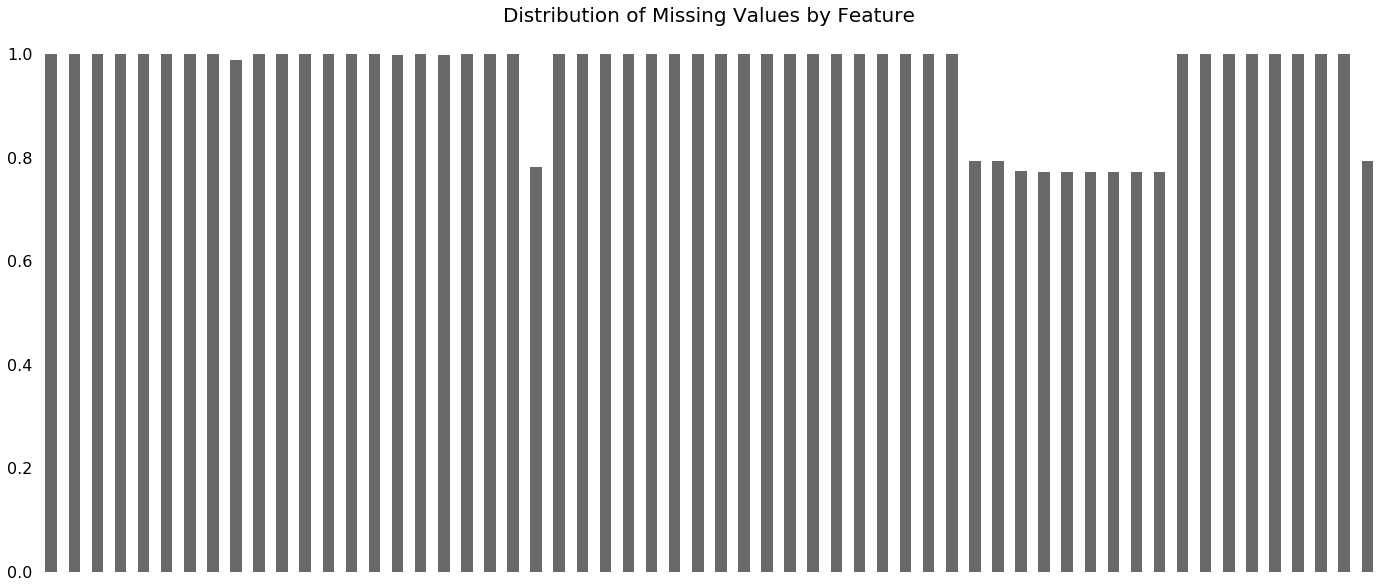

In [43]:
fig = missingno.bar(listings_explore)
plt.title('Distribution of Missing Values by Feature', fontsize=20)
plt.show()

## Numerical Features
First, we will analyze the numerical features.

In [44]:
# Function to view tukey outliers
def tukey_outliers(df_dot_column):
    '''
    Function for detecting Tukey outliers using IQR
    
    data --- dataset
    feature --- string name of feature column
    
    returns 2 vars: outlier indices & outlier values
    
    Args:
    df_dot_column -- feature's Pandas series
    '''
    x = df_dot_column
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3-q1
    floor = q1 - 1.5*iqr
    ceiling = q3 + 1.5*iqr
    return floor, ceiling

In [45]:
# Function to plot CDF's
def cdf(df, column):
    '''
    Function to plot CDF of a numerical feature
    
    Args:
    df -- dataframe
    column -- feature name
    '''
    plt.hist(df[column],
             cumulative=True, density=1, histtype='step', bins=len(df[column]))
    plt.show()

In [46]:
# Function to find percentile of a score
def percentile(df_dot_column, score):
    '''
    Function to find percentile of a score
    
    Args:
    
    df_dot_column -- Pandas series
    score -- score for calculating percentile
    '''
    from scipy.stats import percentileofscore
    return scipy.stats.percentileofscore(df_dot_column, score)

## Feature: price (Independent Variable) (numerical)

In [47]:
preliminaries(listings_explore, 'price')

Dtype:  object
Missing Values:  0


In [48]:
# Value counts
print(listings_explore.price.value_counts()[:5])

$150.00    1670
$100.00    1569
$50.00     1242
$60.00     1165
$200.00    1103
Name: price, dtype: int64


As we can see below, many of our numerical features are of dtype string, and have string characters such as "$" that must be removed before converting them to float or int.

In [49]:
# Remove string characters, convert to float
listings_explore['price'] = listings_explore['price'].astype('str').copy()
listings_explore['price'] = listings_explore['price'].str.replace('.00', '', regex=False).copy()
listings_explore['price'] = listings_explore['price'].str.replace('$', '', regex=False).copy()
listings_explore['price'] = listings_explore['price'].str.replace(',', '', regex=False).copy()
listings_explore['price'] = listings_explore['price'].astype('float64').copy()

In [50]:
# Check Tukey outlier range
tukey_outliers(listings_explore.price)

(-90.0, 334.0)

In [51]:
# Check percentile of $334 ceiling price
scipy.stats.percentileofscore(listings_explore.price, 323)

93.34144467213115

Because we are looking for standard Airbnb's, we drop listings priced above outlier $323/night. This will maintain 93.7% of our data. We also drop prices below 10/night because these are unrealistic accommodations which are likely mistakes (and there are very few of these).

Although our current Tukey outlier range tells us the outlier is at 334, after we clean many features below, the Price outlier value becomes 323. It would be improper to consider the outlier *before* feature cleaning, as we would be cleaning the features below based on a premature assumption.

In [52]:
# only include price in range [10, 323]
listings_explore = listings_explore[(listings_explore.price < 323) & (listings_explore.price >= 10)]

In [53]:
sum_stats(listings_explore.price)

nobs: 36432
median: 100.0
mode: [150.]
mean: 119.07444005270092
std: 66.94934559205603
minmax: (10.0, 322.0)
25% 65.0
50% 100.0
75% 157.0
skewness: 0.8964214310633671


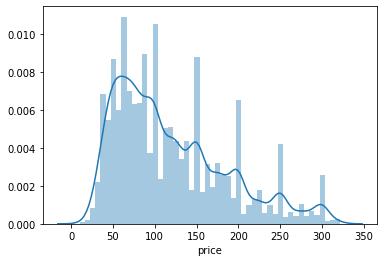

In [54]:
sns.distplot(listings_explore.price, bins=50)
plt.show()

Here we see Price is a skewed right distribution with clear modes at even price values like 50, 75, 100, 125, 150, 200, 250, 300. This is due to hosts pricing their listings at even values.

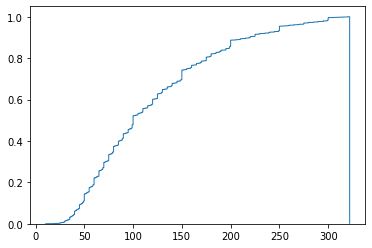

In [55]:
# Price CDF
cdf(listings_explore, 'price')

20% - 80% of prices are between 75 and 200 dollars.

In [56]:
num_attribs.append('price')

## **Feature: number_of_reviews_ltm** (last twelve months) (discrete)

In [57]:
preliminaries(listings_explore, 'number_of_reviews_ltm')

Dtype:  int64
Missing Values:  0


In order to isolate listings that are actually rented on a regular basis, we will assume that listings that are regularly rented will have at least 1 review in the last 12 months. Before dropping all listings with 0 reviews in ltm, we will check to confirm this is not solely due to new hosts who have not had enough time to accrue reviews:

In [58]:
# number of listings with host_since==0 and number_of_reviews_ltm==0
len(listings_explore[(listings_explore.host_since == 0) & (listings_explore.number_of_reviews_ltm == 0)])

0

Only a small fraction of the thousands of listings with 0 number_of_reviews_ltm are due to a host being new. This helps confirm that these listings are simply inactive. Therefore, we will drop listings with 0 number_of_reviews_ltm.

In [59]:
# only include number_of_reviews_ltm > 0
listings_explore = listings_explore[listings_explore.number_of_reviews_ltm > 0]

In [60]:
sum_stats(listings_explore.number_of_reviews_ltm)

nobs: 21998
median: 8.0
mode: [1]
mean: 15.640785525956906
std: 18.4863398234607
minmax: (1, 282)
25% 3.0
50% 8.0
75% 23.0
skewness: 2.4239319779583917


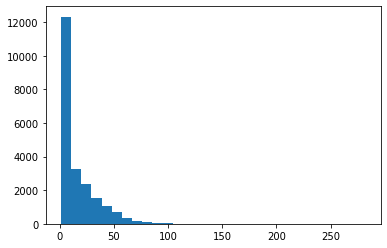

In [61]:
plt.hist(listings_explore.number_of_reviews_ltm, bins=30)
plt.show()

In [62]:
tukey_outliers(listings_explore.number_of_reviews_ltm)

(-27.0, 53.0)

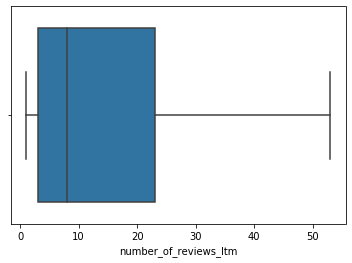

In [63]:
# Boxplot w/o outliers
sns.boxplot(listings_explore.number_of_reviews_ltm, showfliers=False)
plt.show()

75% of hosts have <=23 reviews, dropping off around 100 but outliers spread all the way to 600+. Skews right.

In [64]:
disc_attribs.append('number_of_reviews_ltm')

Clean.

## **Feature: host_since** (discrete)

In [65]:
preliminaries(listings_explore, 'host_since')

Dtype:  object
Missing Values:  4


We will convert host_since to how many years host has been a host.

In [66]:
# Convert to how many years host
listings_explore['host_since'] = 2019 - listings_explore['host_since'].str[:4].astype('float64')

In [67]:
# Identify indices of missing values (True)
#listings_explore.host_since.isnull().sort_values()

In [68]:
# Check a missing value index
#listings_explore.loc[9339]

In [69]:
# Remove missing values
#listings_explore = listings_explore[listings_explore.host_since.notnull()].copy()

In [70]:
# Convert dtype to int
listings_explore['host_since'] = listings_explore.host_since.astype('float64')

In [71]:
sum_stats(listings_explore.host_since.dropna())

nobs: 21994
median: 4.0
mode: [4.]
mean: 4.191324906792762
std: 2.3706946253180505
minmax: (0.0, 11.0)
25% 2.0
50% 4.0
75% 6.0
skewness: 0.17188379478247912


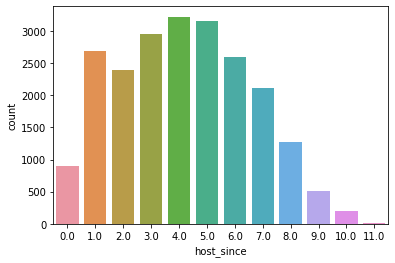

In [72]:
# Countplot
sns.countplot(listings_explore.host_since)
plt.show()

Most hosts are spread rather evenly between 1 year and 7 years. 0 and 8-10 years are still significant amount. Skews slightly right.

In [73]:
disc_attribs.append('host_since')

## **Feature: number_of_reviews** (discrete)

In [74]:
preliminaries(listings_explore, 'number_of_reviews')

Dtype:  int64
Missing Values:  0


In [75]:
sum_stats(listings_explore.number_of_reviews)

nobs: 21998
median: 15.0
mode: [1]
mean: 36.58668969906355
std: 52.61377490330862
minmax: (1, 609)
25% 5.0
50% 15.0
75% 47.0
skewness: 2.8773175319133326


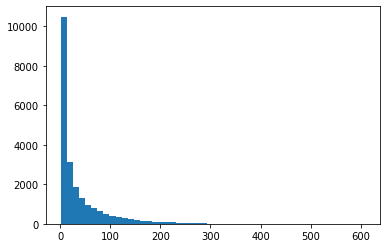

In [76]:
plt.hist(listings_explore.number_of_reviews, bins=50)
plt.show()

In [77]:
tukey_outliers(listings_explore.number_of_reviews)

(-58.0, 110.0)

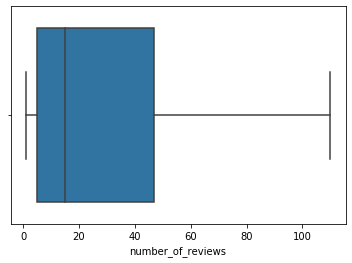

In [78]:
# Boxplot w/o outliers
sns.boxplot(listings_explore.number_of_reviews, showfliers=False)
plt.show()

In [79]:
percentile(listings_explore.number_of_reviews, 100)

89.77634330393673

90% of hosts have 100 reviews or less, with most closer to 0 than 100. Skews right.

In [80]:
disc_attribs.append('number_of_reviews')

## **Feature: host_listings_count** (discrete) (for analysis only)

We will use host_listings_count for our analysis, but we will not include it in the model because it is not visible to guests on the app.

In [81]:
preliminaries(listings_explore, 'host_listings_count')

Dtype:  float64
Missing Values:  4


A host can't have 0 listings, so this must be a mistake. We will consider 0 values to be Nan.

In [82]:
# Amount of listings with 0 host_listings_count
len(listings_explore[listings_explore.host_listings_count == 0])

88

In [83]:
# Convert 0 values to Nan
listings_explore['host_listings_count'] = listings_explore.host_listings_count.replace(0.0, np.nan).astype('float64')

In [84]:
# Confirm no more 0 host_listings_count
preliminaries(listings_explore, 'host_listings_count', values=False)

Dtype:  float64
Missing Values:  92


In [85]:
sum_stats(listings_explore.host_listings_count.dropna())

nobs: 21906
median: 1.0
mode: [1.]
mean: 7.1070939468638725
std: 46.887025783622555
minmax: (1.0, 1108.0)
25% 1.0
50% 1.0
75% 3.0
skewness: 17.141199112472787


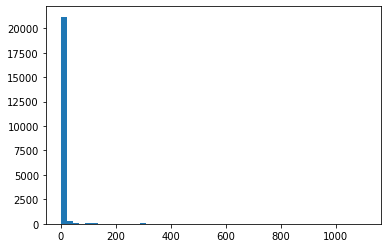

In [86]:
plt.hist(listings_explore.host_listings_count.dropna(), bins=50)
plt.show()

In [87]:
tukey_outliers(listings_explore.host_listings_count.dropna())

(-2.0, 6.0)

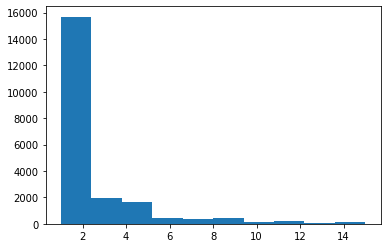

In [88]:
# Hist of host_listings_count <= 15
plt.hist(listings_explore[listings_explore.host_listings_count <= 15].host_listings_count)
plt.show()

In [89]:
percentile(listings_explore.host_listings_count.dropna(), 1)

26.360357892814754

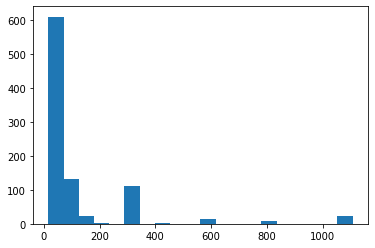

In [90]:
# Hist of host_listings_count >= 15
plt.hist(listings_explore[listings_explore.host_listings_count > 15].host_listings_count, bins=20)
plt.show()

About 26% of hosts have only 1 listing, and about 95% of hosts have 15 listings or less, but the distribution spans all the way past 1000 listings. Skews right.

Fill missing values manually using mode since feature won't be in model.

In [91]:
# Fill missing values (can do this now because feature will be dropped)
listings_explore['host_listings_count'] = listings_explore.host_listings_count.fillna(1.0)

In [92]:
#disc_attribs.append('host_listings_count')
drop_later.append('host_listings_count')

## **Feature: host_total_listings_count**

There are only 92 instances with differences to host_listings_count. Because we do not know the difference in measure between host_listings_count and host_total_listings_count, we will drop host_total_listings_count.

In [93]:
# compare listings with differences
len(listings_explore) - np.sum(listings_explore.host_total_listings_count == listings_explore.host_listings_count)

92

In [94]:
listings_explore.drop(columns='host_total_listings_count', inplace=True)
dropped_cols.append('host_total_listings_count')

## **Feature: latitude**

In [95]:
preliminaries(listings_explore, 'latitude')

Dtype:  float64
Missing Values:  0


In [96]:
num_attribs.append('latitude')

## **Feature: Longitude**

In [97]:
preliminaries(listings_explore, 'longitude')

Dtype:  float64
Missing Values:  0


In [98]:
num_attribs.append('longitude')

## **Feature: accommodates** (discrete)

In [99]:
preliminaries(listings_explore, 'accommodates')

Dtype:  int64
Missing Values:  0


In [100]:
sum_stats(listings_explore.accommodates)

nobs: 21998
median: 2.0
mode: [2]
mean: 2.8161196472406584
std: 1.682256249145391
minmax: (1, 16)
25% 2.0
50% 2.0
75% 4.0
skewness: 2.1068170931469448


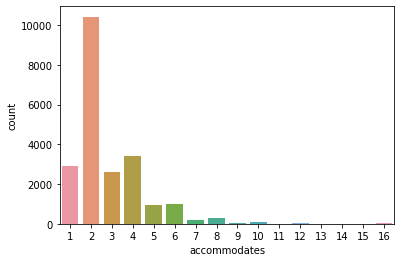

In [101]:
sns.countplot(listings_explore.accommodates)
plt.show()

In [102]:
percentile(listings_explore.accommodates, 2)

36.92153832166561

In [103]:
percentile(listings_explore.accommodates, 6)

94.56086916992454

36% of listings accommodate 2 or less, with 95% ranging from 1-6. Skews right.

In [104]:
disc_attribs.append('accommodates')

## **Feature: bathrooms** (discrete)

In [105]:
preliminaries(listings_explore, 'bathrooms')

Dtype:  float64
Missing Values:  14


In [106]:
sum_stats(listings_explore.bathrooms.dropna())

nobs: 21984
median: 1.0
mode: [1.]
mean: 1.1118995633187774
std: 0.36543855004584563
minmax: (0.0, 7.0)
25% 1.0
50% 1.0
75% 1.0
skewness: 4.638480022358254


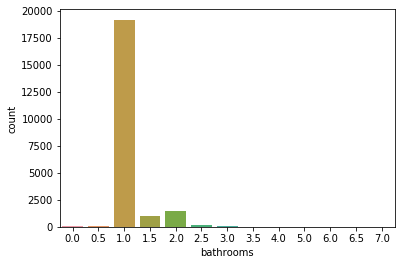

In [107]:
sns.countplot(listings_explore.bathrooms)
plt.show()

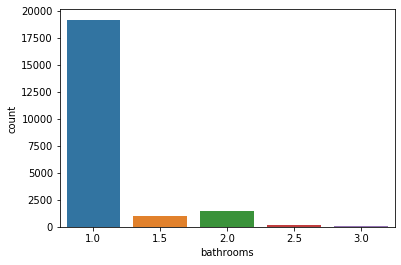

In [108]:
# hist of bathrooms between 1 & 3
sns.countplot((listings_explore[(listings_explore.bathrooms <= 3) & (listings_explore.bathrooms >= 1)]).bathrooms)
plt.show()

In [109]:
percentage_of(listings_explore.bathrooms, [1.0,1.5,2.0,2.5,3.0])

1.0    0.87
1.5    0.05
2.0    0.07
2.5    0.01
3.0    0.01
Name: bathrooms, dtype: float64

87% of all listings have 1 bathroom, while nearly all have 3 or less. Skews right.

In [110]:
disc_attribs.append('bathrooms')

## **Feature: bedrooms** (discrete)

In [111]:
preliminaries(listings_explore, 'bedrooms')

Dtype:  float64
Missing Values:  11


In [112]:
sum_stats(listings_explore.bedrooms.dropna())

nobs: 21987
median: 1.0
mode: [1.]
mean: 1.1328967116932733
std: 0.6512091143955939
minmax: (0.0, 9.0)
25% 1.0
50% 1.0
75% 1.0
skewness: 1.6047263383243688


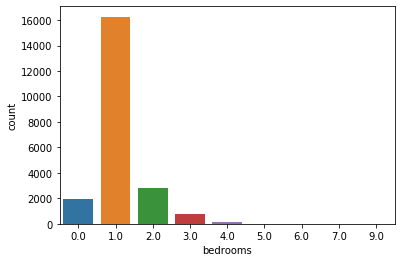

In [113]:
sns.countplot(listings_explore.bedrooms)
plt.show()

In [114]:
percentage_of(listings_explore.bedrooms, 1.0)

0.74

In [115]:
percentile(listings_explore.bedrooms.dropna(), 4.0)

99.55428207577205

74% of listings have 1 bedroom, and nearly all have 4 or less. Skews right.

We will inspect listings with >4 bedrooms just to ensure they are not inaccurate datapoints.

In [116]:
# View listings with >4 bedrooms
#listings_explore[listings_explore.bedrooms > 4][['bedrooms', 'beds', 'bathrooms', 'price']]

Although these are not completely "ordinary", as most NYC apartments have <=3 bedrooms, they are not anomalous to the point that we should consider them inaccurate. They could be large apartments, houses, etc. We will keep them in our data.

In [117]:
disc_attribs.append('bedrooms')

Ready to impute.

## **Feature: beds** (discrete)

In [118]:
preliminaries(listings_explore, 'beds')

Dtype:  float64
Missing Values:  5


In [119]:
sum_stats(listings_explore.beds.dropna())

nobs: 21993
median: 1.0
mode: [1.]
mean: 1.518755967807939
std: 1.0178587474497025
minmax: (0.0, 16.0)
25% 1.0
50% 1.0
75% 2.0
skewness: 2.6337905237694295


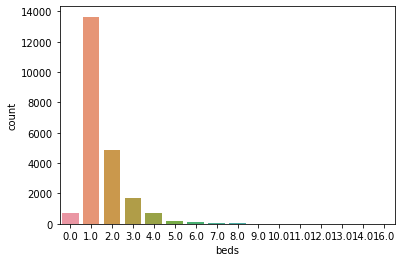

In [120]:
sns.countplot(listings_explore.beds)
plt.show()

In [121]:
percentage_of(listings_explore.beds, 1.0)

0.62

In [122]:
percentile(listings_explore.beds, 4.0)

//anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1857: RuntimeWarning: invalid value encountered in less
  left = np.count_nonzero(a < score)
//anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1858: RuntimeWarning: invalid value encountered in less_equal
  right = np.count_nonzero(a <= score)


96.66560596417857

62% have 1 bed, while nearly all have 4 or less beds.

In [123]:
disc_attribs.append('beds')

Ready to impute.

## **Feature: cleaning_fee**

In [124]:
preliminaries(listings_explore, 'cleaning_fee')

Dtype:  object
Missing Values:  2719


In [125]:
# Remove string characters, convert to float
listings_explore['cleaning_fee'] = listings_explore.cleaning_fee.str.replace('$', '', regex=False)
listings_explore['cleaning_fee'] = listings_explore.cleaning_fee.str.replace('.00', '', regex=False)
listings_explore['cleaning_fee'] = listings_explore.cleaning_fee.str.replace(',', '', regex=False)
listings_explore['cleaning_fee'] = listings_explore.cleaning_fee.astype('float64')

In [126]:
sum_stats(listings_explore.cleaning_fee.dropna())

nobs: 19279
median: 50.0
mode: [50.]
mean: 59.23035427148711
std: 45.99522070457579
minmax: (0.0, 600.0)
25% 25.0
50% 50.0
75% 85.0
skewness: 1.6209885047725725


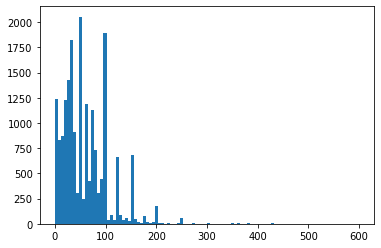

In [127]:
plt.hist(listings_explore.cleaning_fee.dropna(), bins=100)
plt.show()

To visualize the distribution shape:

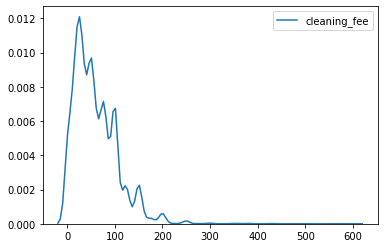

In [128]:
sns.kdeplot(listings_explore.cleaning_fee.dropna())
plt.show()

In [129]:
tukey_outliers(listings_explore.cleaning_fee.dropna())

(-65.0, 175.0)

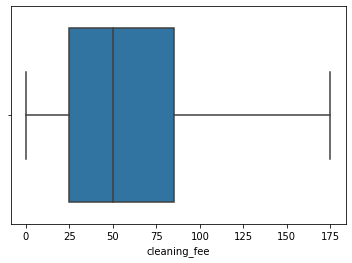

In [130]:
# Boxplot w/o outliers
sns.boxplot(listings_explore.cleaning_fee.dropna(), showfliers=False)
plt.show()

In [131]:
percentile(listings_explore.cleaning_fee.dropna(), 150)

95.63774054670886

Median cleaning fees is 50, 95% are 150 or less, but they can range up to 600. Skews right.

In [132]:
num_attribs.append('cleaning_fee')

Ready to impute.

## **Feature: guests_included** (discrete)

In [133]:
preliminaries(listings_explore, 'guests_included')

Dtype:  int64
Missing Values:  0


In [134]:
sum_stats(listings_explore.guests_included)

nobs: 21998
median: 1.0
mode: [1]
mean: 1.5695972361123738
std: 1.0859952450199053
minmax: (1, 16)
25% 1.0
50% 1.0
75% 2.0
skewness: 3.206714798294352


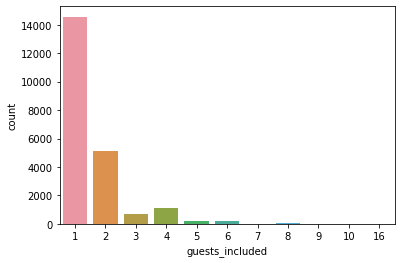

In [135]:
sns.countplot(listings_explore.guests_included)
plt.show()

In [136]:
percentage_of(listings_explore.guests_included, 1)

0.66

In [137]:
percentage_of(listings_explore.guests_included, 2)

0.23

In [138]:
percentile(listings_explore.guests_included, 4)

95.0609146286026

66% of guests included are 1, 23% are 2, and 95% of listings are 4 or less, though it skews right up to 16.

In [139]:
disc_attribs.append('guests_included')

Clean.

## Feature: extra_people (discrete)

Cost per additional person.

In [140]:
preliminaries(listings_explore, 'extra_people')

Dtype:  object
Missing Values:  0


In [141]:
# Remove string characters, convert to float
listings_explore['extra_people'] = listings_explore.extra_people.str.replace('$', '', regex=False)
listings_explore['extra_people'] = listings_explore.extra_people.str.replace('.00', '', regex=False)
listings_explore['extra_people'] = listings_explore.extra_people.str.replace(',', '', regex=False)
listings_explore['extra_people'] = listings_explore.extra_people.astype('float64')

In [142]:
sum_stats(listings_explore.extra_people)

nobs: 21998
median: 10.0
mode: [0.]
mean: 17.015410491862898
std: 24.58359286094277
minmax: (0.0, 300.0)
25% 0.0
50% 10.0
75% 25.0
skewness: 4.385639195835524


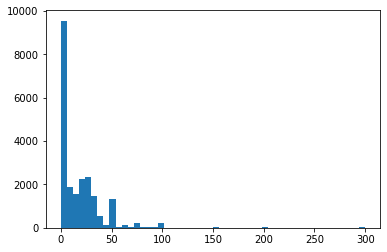

In [143]:
plt.hist(listings_explore.extra_people, bins=50)
plt.show()

In [144]:
tukey_outliers(listings_explore.extra_people)

(-37.5, 62.5)

Most listings do not charge for additional people, median is 10, skews right, outliers begin at 62.5 up to 300.

In [145]:
disc_attribs.append('extra_people')

## **Feature: minimum_nights** (discrete)

In [146]:
preliminaries(listings_explore, 'minimum_nights')

Dtype:  int64
Missing Values:  0


How there are minimum_nights values above 180 when the MAXIMUM airbnb allows is 6 months (180 days)? One solution is to drop the rows for which minimum_nights exceeds 180, another is to drop the feature altogether.

Because we are measuring standard Airbnb's, we are not measuring long-term Airbnb's. Therefore we should drop all rows whose minimum_nights exceed 7 nights. This has been chosen because a week seems like a reasonable amount of time for a minimum for a standard type of room that hasn't been heavily discounted due to quantity of long-term stay.

In [147]:
# only include minimum_nights <= 7
listings_explore = listings_explore[listings_explore.minimum_nights <= 7].copy()

In [148]:
sum_stats(listings_explore.minimum_nights)

nobs: 19506
median: 2.0
mode: [2]
mean: 2.505280426535425
std: 1.5215104025115558
minmax: (1, 7)
25% 1.0
50% 2.0
75% 3.0
skewness: 1.2214395564997413


In [149]:
tukey_outliers(listings_explore.minimum_nights)

(-2.0, 6.0)

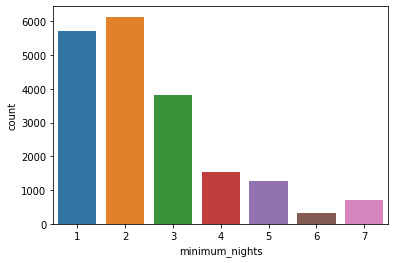

In [150]:
sns.countplot(listings_explore.minimum_nights)
plt.show()

Most listings have 1-3 night minimum, but it ranges up to 7, with outliers at 6+. Skews right.

In [151]:
disc_attribs.append('minimum_nights')

Ready to impute.

## **Feature: maximum_nights** (discrete)

In [152]:
preliminaries(listings_explore, 'maximum_nights')

Dtype:  int64
Missing Values:  0


How there are maximum_nights values above 180 when the MAXIMUM airbnb allows is 6 months (180 days)? One solution is to drop the rows for which maximum_nights exceeds 180, another is to drop the feature altogether.

Maximum nights need not be filtered because we ensured minimum nights cannot exceed 7 nights, so pricing should remain short-term stay price regardless of how high the option can go.

In [153]:
sum_stats(listings_explore.maximum_nights)

nobs: 19506
median: 180.0
mode: [1125]
mean: 555.6846611299087
std: 706.7853914080637
minmax: (1, 60000)
25% 28.0
50% 180.0
75% 1125.0
skewness: 31.337019025454545


In [154]:
tukey_outliers(listings_explore.maximum_nights)

(-1617.5, 2770.5)

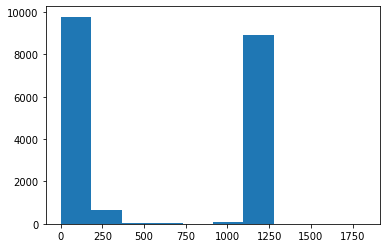

In [155]:
plt.hist(listings_explore[listings_explore.maximum_nights <= 2000].maximum_nights)
plt.show()

There is a surprisingly high mode at 1125 maximum_nights with a large gap before and after that number. This may be the maximum allowable by the Airbnb fill-in field. We will use 180 as a bin for any number of nights above 180 because 6 months is the max length of stay for short-term Airbnb as per policy.

In [156]:
# Cap maximum_nights at 180
listings_explore['maximum_nights'].values[listings_explore.maximum_nights > 180] = 180

In [157]:
sum_stats(listings_explore.maximum_nights)

nobs: 19506
median: 180.0
mode: [180]
mean: 106.64252025017943
std: 76.91872495258504
minmax: (1, 180)
25% 28.0
50% 180.0
75% 180.0
skewness: -0.16872493511923184


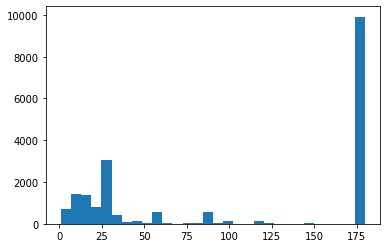

In [158]:
plt.hist(listings_explore.maximum_nights, bins=30)
plt.show()

In [159]:
percentage_of(listings_explore.maximum_nights, 180)

0.51

In [160]:
percentile(listings_explore.maximum_nights, 50)

41.05147134215113

Distribution's mode is at 180 maximum_nights (51% of listings), skewed left with 40% at or below 100 nights.

In [161]:
disc_attribs.append('maximum_nights')

**Features: minimum_minimum_nights, maximum_minimum_nights, minimum_maximum_nights, maximum_maximum_nights, minimum_nights_avg_ntm, maximum_nights_avg_ntm**

We will drop these specific features in lieu of the features: minimum_nights and maximum_nights. NTM means 'next twelve months.'

In [162]:
listings_explore.drop(columns=['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], inplace=True)
dropped_cols.extend(['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'])

## **Feature: availability_30** (discrete)

In [163]:
preliminaries(listings_explore, 'availability_30')

Dtype:  int64
Missing Values:  0


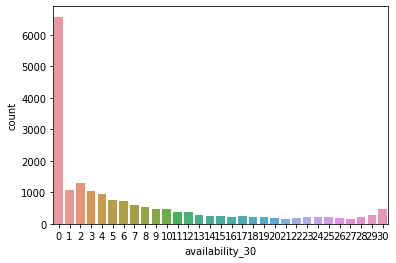

In [164]:
sns.countplot(listings_explore.availability_30)
plt.show()

Mode is at 0 availability_30 with small amounts ranging from 1-30. Skews right.

In [165]:
disc_attribs.append('availability_30')

## **Feature: availability_60**

In [166]:
preliminaries(listings_explore, 'availability_60')

Dtype:  int64
Missing Values:  0


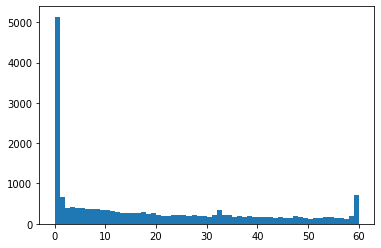

In [167]:
plt.hist(listings_explore.availability_60, bins=60)
plt.show()

Mode at 0 with a small spike at 60. Skews right.

In [168]:
disc_attribs.append('availability_60')

## **Feature: availability_90**

In [169]:
preliminaries(listings_explore, 'availability_90')

Dtype:  int64
Missing Values:  0


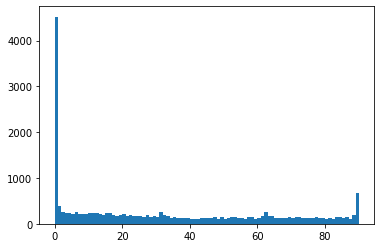

In [170]:
plt.hist(listings_explore.availability_90, bins=90)
plt.show()

Mode at 0 with small spike at 90, skews right.

In [171]:
disc_attribs.append('availability_90')

## **Feature: availability_365**

In [172]:
preliminaries(listings_explore, 'availability_365')

Dtype:  int64
Missing Values:  0


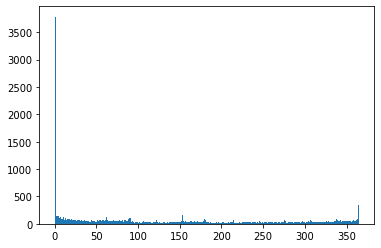

In [173]:
plt.hist(listings_explore.availability_365, bins=365)
plt.show()

Mode at 0 with small spike at 365, skews right.

In [174]:
disc_attribs.append('availability_365')

## **Features: first_review, last_review**

Feature first_review dropped in lieu of feature number_of_reviews because that covers all reviews, and host_since measures how long a host has been hosting.

Feature last_review dropped in lieu of feature number_of_reviews_ltm because that covers the amount of recent reviews for potential renters to see.

In [175]:
listings_explore.drop(columns=['first_review', 'last_review'], inplace=True)
dropped_cols.extend(['first_review', 'last_review'])

## Feature: review_scores_rating (discrete)

In [176]:
preliminaries(listings_explore, 'review_scores_rating')

Dtype:  float64
Missing Values:  259


In [177]:
sum_stats(listings_explore.review_scores_rating.dropna())

nobs: 19247
median: 96.0
mode: [100.]
mean: 94.31511404374707
std: 7.138444164094625
minmax: (20.0, 100.0)
25% 92.0
50% 96.0
75% 99.0
skewness: -3.7195392855576648


In [178]:
tukey_outliers(listings_explore.review_scores_rating.dropna())

(81.5, 109.5)

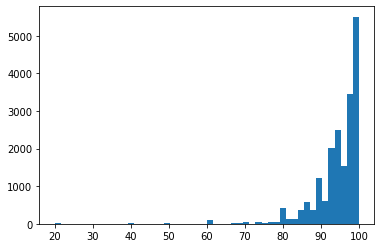

In [179]:
plt.hist(listings_explore.review_scores_rating.dropna(), bins=50)
plt.show()

In [180]:
percentage_of(listings_explore.review_scores_rating, 100)

0.23

In [181]:
1 - percentile(listings_explore.review_scores_rating, 90)

//anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1857: RuntimeWarning: invalid value encountered in less
  left = np.count_nonzero(a < score)
//anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1858: RuntimeWarning: invalid value encountered in less_equal
  right = np.count_nonzero(a <= score)


-15.669229980518814

Mode at 100 (23% of ratings), 15% of ratings are between 90 and 100. Skews left.

In [182]:
disc_attribs.append('review_scores_rating')

## **Feature: review_scores_accuracy** (Discrete)

In [183]:
preliminaries(listings_explore, 'review_scores_accuracy')

Dtype:  float64
Missing Values:  261


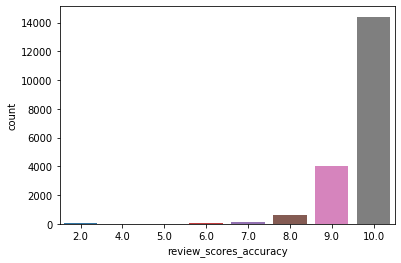

In [184]:
sns.countplot(listings_explore.review_scores_accuracy.dropna())
plt.show()

Mode at 10, some at 9, the rest small down to 2. Skews left.

In [185]:
disc_attribs.append('review_scores_accuracy')

## **Feature: review_scores_cleanliness** (Discrete)

In [186]:
preliminaries(listings_explore, 'review_scores_cleanliness')

Dtype:  float64
Missing Values:  261


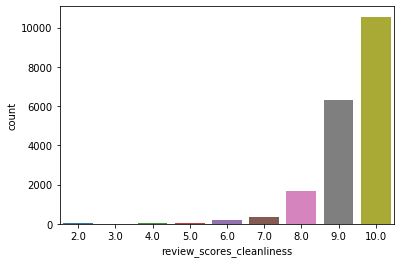

In [187]:
sns.countplot(listings_explore.review_scores_cleanliness.dropna())
plt.show()

Mode at 10, some at 9 and 8, skews left.

In [188]:
disc_attribs.append('review_scores_cleanliness')

## **Feature: review_scores_checkin** (Discrete)

In [189]:
preliminaries(listings_explore, 'review_scores_checkin')

Dtype:  float64
Missing Values:  263


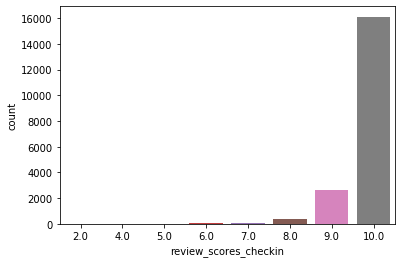

In [190]:
sns.countplot(listings_explore.review_scores_checkin.dropna())
plt.show()

Mode at 10, some at 9, skews left.

In [191]:
disc_attribs.append('review_scores_checkin')

## **Feature: review_scores_communication** (Discrete)

In [192]:
preliminaries(listings_explore, 'review_scores_communication')

Dtype:  float64
Missing Values:  261


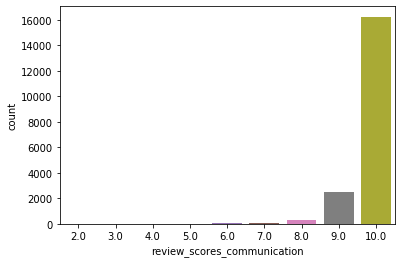

In [193]:
sns.countplot(listings_explore.review_scores_communication.dropna())
plt.show()

Mode at 10, some at 9, skews left.

In [194]:
disc_attribs.append('review_scores_communication')

Ready to impute.

## **Feature: review_scores_location** (Discrete)

In [195]:
preliminaries(listings_explore, 'review_scores_location')

Dtype:  float64
Missing Values:  263


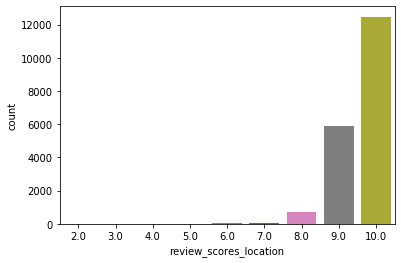

In [196]:
sns.countplot(listings_explore.review_scores_location.dropna())
plt.show()

Mode at 10, half at 9, some at 8, skews left.

In [197]:
disc_attribs.append('review_scores_location')

## **Feature: review_scores_value** (Discrete)

In [198]:
preliminaries(listings_explore, 'review_scores_value')

Dtype:  float64
Missing Values:  263


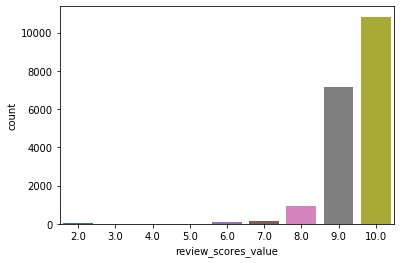

In [199]:
sns.countplot(listings_explore.review_scores_value.dropna())
plt.show()

Mode at 10, close to 9, a few at 8, skews left.

In [200]:
disc_attribs.append('review_scores_value')

Ready to impute.

**Features: calculated_host_listings_count, calculated_host_listings_count_entire_homes, calculated_host_listings_count_private_rooms, calculated_host_listings_count_shared_rooms**

These features have been dropped as they do not seem to directly contribute much more information to the potential renter as to whether they will rent or not. I understand that there may be a correlation between having more or less listings and, for instance, reviews or price, but we have chosen to leave these features out for reasons of streamlining this process, and I feel the other features cover much of the needed to determine the price.

In [201]:
listings_explore.drop(columns=['calculated_host_listings_count',
                               'calculated_host_listings_count_entire_homes',
                               'calculated_host_listings_count_private_rooms',
                               'calculated_host_listings_count_shared_rooms'], inplace=True)
dropped_cols.extend(['calculated_host_listings_count',
                     'calculated_host_listings_count_entire_homes',
                     'calculated_host_listings_count_private_rooms',
                     'calculated_host_listings_count_shared_rooms'])

## **Feature: reviews_per_month**

In [202]:
preliminaries(listings_explore, 'reviews_per_month')

Dtype:  float64
Missing Values:  0


In [203]:
sum_stats(listings_explore.reviews_per_month)

nobs: 19506
median: 1.37
mode: [1.]
mean: 1.9028078539936428
std: 1.7616027593254382
minmax: (0.02, 28.0)
25% 0.58
50% 1.37
75% 2.77
skewness: 1.969132469374286


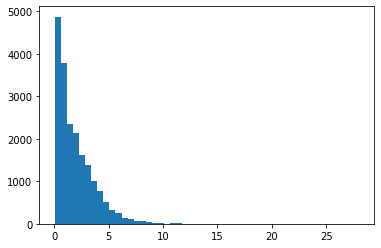

In [204]:
plt.hist(listings_explore.reviews_per_month, bins=50)
plt.show()

Mode at 0, many up to 4. Skews right up to 28.

In [205]:
num_attribs.append('reviews_per_month')

Ready to impute.

# Categorical Features

In [206]:
# Function to convert true/false values to binary
def convert_tf(df, column):
    '''
    Converts t/f values in a Series to 0/1.
    '''
    df[column] = df[column].map({'t': 1, 'f': 0}, na_action='ignore')
    return df[column]

## **Feature: host_is_superhost**

In [207]:
preliminaries(listings_explore, 'host_is_superhost', values=True)

Dtype:  object
Missing Values:  4
f    13983
t     5519
Name: host_is_superhost, dtype: int64


In [208]:
# Convert t/f to 1/0
listings_explore['host_is_superhost'] = convert_tf(listings_explore, 'host_is_superhost')

In [209]:
preliminaries(listings_explore, 'host_is_superhost', values=True)

Dtype:  float64
Missing Values:  4
0.0    13983
1.0     5519
Name: host_is_superhost, dtype: int64


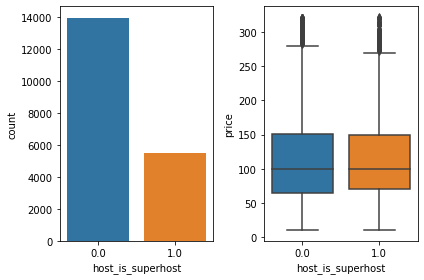

In [210]:
fig, ax = plt.subplots(1, 2)
sns.countplot(listings_explore.host_is_superhost, ax=ax[0])
sns.catplot('host_is_superhost', 'price', data=listings_explore, kind='box', ax=ax[1])
fig.tight_layout()
plt.close()
plt.show()

In [211]:
percentage_of(listings_explore.host_is_superhost, 1.0)

0.28

28% of hosts are superhosts.

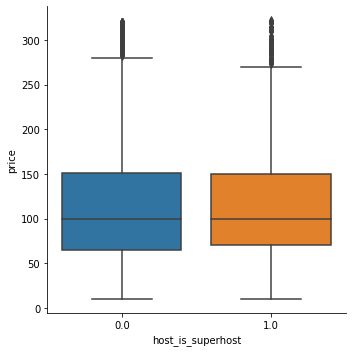

In [212]:
sns.catplot('host_is_superhost', 'price', data=listings_explore, kind='box')
plt.show()

Interestingly, price does not look to be affected by whether a host is a superhost or not. If this is true, then the superhost badge is more a marketing tool for Airbnb to synthetically reward loyal hosts than it is a tool to help hosts generate more revenue.

In [213]:
cat_attribs.append('host_is_superhost')

Clean.

## **Feature: host_has_profile_pic**

In [214]:
preliminaries(listings_explore, 'host_has_profile_pic', values=True)

Dtype:  object
Missing Values:  4
t    19466
f       36
Name: host_has_profile_pic, dtype: int64


Virtually all listings have a profile picture, so we will remove this feature from the data.

In [215]:
listings_explore.drop(columns='host_has_profile_pic', inplace=True)
dropped_cols.append('host_has_profile_pic')

Clean.

## **Feature: host_identity_verified** (For analysis only)

This column is only for analysis purposes and will be removed from the model, as the potential guest cannot see whether a host is verified.

In [216]:
preliminaries(listings_explore, 'host_identity_verified', values=True)

Dtype:  object
Missing Values:  4
f    9841
t    9661
Name: host_identity_verified, dtype: int64


In [217]:
# Convert t/f to 1/0
listings_explore['host_identity_verified'] = convert_tf(listings_explore, 'host_identity_verified')

In [218]:
preliminaries(listings_explore, 'host_identity_verified', values=True)

Dtype:  float64
Missing Values:  4
0.0    9841
1.0    9661
Name: host_identity_verified, dtype: int64


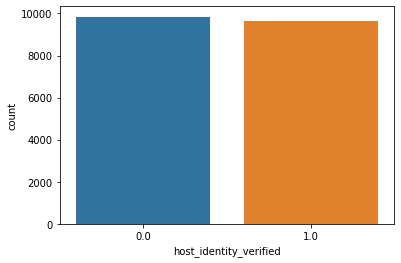

In [219]:
sns.countplot(listings_explore.host_identity_verified)
plt.show()

About half of hosts are verified.

In [220]:
#cat_attribs.append('host_identity_verified')
drop_later.append('host_identity_verified')

## **Feature: neighbourhood_cleansed**

In [221]:
preliminaries(listings_explore, 'neighbourhood_cleansed')

Dtype:  object
Missing Values:  0


A list of value counts is the best way to view this data.

In [222]:
cat_attribs.append('neighbourhood_cleansed')

## **Feature: neighbourhood_group_cleansed**

In [223]:
preliminaries(listings_explore, 'neighbourhood_group_cleansed', values=True)

Dtype:  object
Missing Values:  0
Brooklyn         8614
Manhattan        7341
Queens           2773
Bronx             560
Staten Island     218
Name: neighbourhood_group_cleansed, dtype: int64


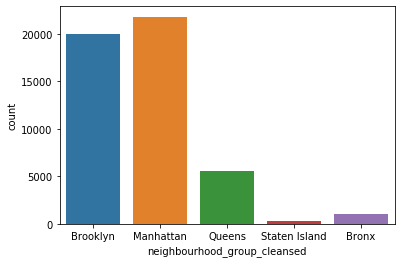

In [224]:
sns.countplot(listings.neighbourhood_group_cleansed)
plt.show()

In [225]:
percentage_of(listings_explore.neighbourhood_group_cleansed, pd.unique(listings_explore.neighbourhood_group_cleansed))

Brooklyn         0.44
Manhattan        0.38
Bronx            0.03
Queens           0.14
Staten Island    0.01
Name: neighbourhood_group_cleansed, dtype: float64

Brooklyn (44%) and Manhattan (38%) have by far the most listings, followed by Queens (14%), with Bronx (3%) and Staten Island (1%) quite low.

In [226]:
cat_attribs.append('neighbourhood_group_cleansed')

Clean.

**Feature: zipcode**

In [227]:
preliminaries(listings_explore, 'zipcode')

Dtype:  object
Missing Values:  216


In [228]:
# Convert zipcodes to float
#listings_explore['zipcode'] = listings_train['zipcode']
#listings_explore['zipcode'] = listings_explore['zipcode'].str.replace('-', '', regex=False)
#listings_explore['zipcode'] = listings_explore['zipcode'].str.replace('NY ', '', regex=False)
#listings_explore['zipcode'] = listings_explore['zipcode'].str.replace('\n', '', regex=False)
#listings_explore['zipcode'] = listings_explore['zipcode'].str[:5].astype('float')

Because we have longitude and latitude, which is a more accurate measure of location, along with neighbourhood_cleansed, we will drop the zipcode feature.

In [229]:
listings_explore.drop(columns='zipcode', inplace=True)
dropped_cols.append('zipcode')

## **Feature: property_type**

In [230]:
preliminaries(listings_explore, 'property_type')

Dtype:  object
Missing Values:  0


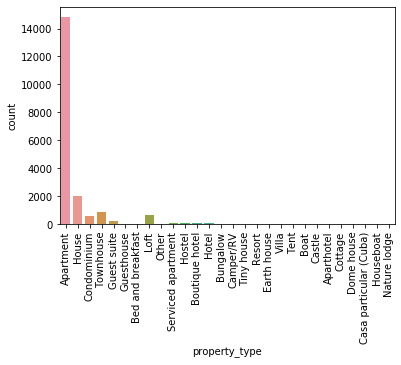

In [231]:
fig = sns.countplot(listings_explore.property_type)
fig.set_xticklabels(labels=pd.unique(listings_explore.property_type), rotation=90)
plt.show()

Because we are isolating more standard Airbnbs, we will only keep the following values from the data:

In [232]:
# Filter specific property types
listings_explore = listings_explore[
                       (listings_explore.property_type == 'Apartment') |
                       (listings_explore.property_type == 'House') |
                       (listings_explore.property_type == 'Condominium') |
                       (listings_explore.property_type == 'Townhouse') |
                       (listings_explore.property_type == 'Guest suite') |
                       (listings_explore.property_type == 'Guesthouse') |
                       (listings_explore.property_type == 'Loft') |
                       (listings_explore.property_type == 'Serviced apartment') |
                       (listings_explore.property_type == 'Tiny house') |
                       (listings_explore.property_type == 'Earth house') |
                       (listings_explore.property_type == 'Villa') |
                       (listings_explore.property_type == 'Castle') |
                       (listings_explore.property_type == 'Cottage') |
                       (listings_explore.property_type == 'Dome house')
                    ]

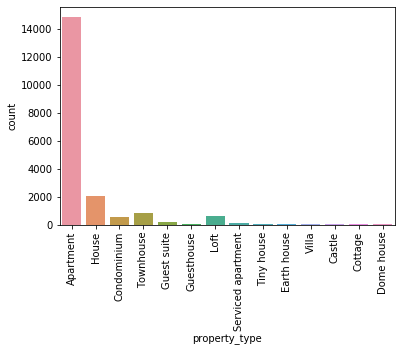

In [233]:
fig = sns.countplot(listings_explore.property_type)
fig.set_xticklabels(labels=pd.unique(listings_explore.property_type), rotation=90)
plt.show()

In [234]:
percentage_of(listings_explore.property_type, pd.unique(listings_explore.property_type))

Apartment             0.77
House                 0.11
Condominium           0.03
Townhouse             0.04
Guest suite           0.01
Guesthouse            0.00
Loft                  0.03
Serviced apartment    0.00
Tiny house            0.00
Earth house           0.00
Villa                 0.00
Castle                0.00
Cottage               0.00
Dome house            0.00
Name: property_type, dtype: float64

77% of listings are apartments, 11% are houses, with the remaining 10% in condominiums, townhomes, lofts, and only a few of the others.

In [235]:
cat_attribs.append('property_type')

Clean.

## **Feature: room_type**

In [236]:
preliminaries(listings_explore, 'room_type', values=True)

Dtype:  object
Missing Values:  0
Private room       9419
Entire home/apt    9361
Shared room         462
Name: room_type, dtype: int64


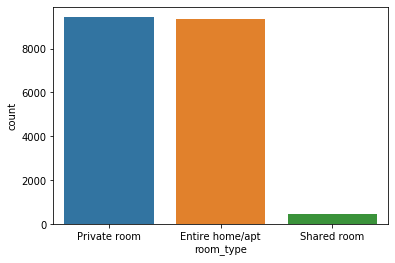

In [237]:
sns.countplot(listings_explore.room_type)
plt.show()

In [238]:
percentage_of(listings_explore.room_type, pd.unique(listings_explore.room_type))

Private room       0.49
Entire home/apt    0.49
Shared room        0.02
Name: room_type, dtype: float64

About 50/50 private room / entire home with only a few shared room.

In [239]:
cat_attribs.append('room_type')

**Feature: is_location_exact**

In [240]:
preliminaries(listings_explore, 'is_location_exact', values=True)

Dtype:  object
Missing Values:  0
t    15435
f     3807
Name: is_location_exact, dtype: int64


We're not clear what this feature measures, as we already have multiple features with location data, so we will delete this feature.

In [241]:
listings_explore.drop(columns='is_location_exact', inplace=True)
dropped_cols.append('is_location_exact')

## **Feature: bed_type**

In [242]:
preliminaries(listings_explore, 'bed_type', values=True)

Dtype:  object
Missing Values:  0
Real Bed         18933
Futon              118
Pull-out Sofa      113
Airbed              51
Couch               27
Name: bed_type, dtype: int64


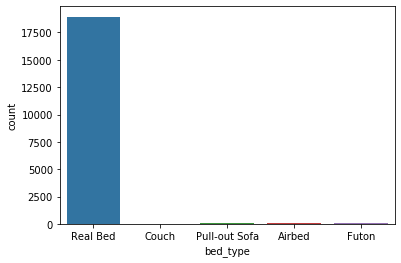

In [243]:
sns.countplot(listings_explore.bed_type)
plt.show()

In [244]:
percentage_of(listings_explore.bed_type, pd.unique(listings_explore.bed_type))

Real Bed         0.98
Couch            0.00
Pull-out Sofa    0.01
Airbed           0.00
Futon            0.01
Name: bed_type, dtype: float64

Virtually all real bed, with only a few of the others. Although nearly all values are one type, a real bed versus the other options is important to the quality of the listing, so we will keep this feature.

In [245]:
cat_attribs.append('bed_type')

## **Feature: amenities**
The amenities feature originally consists of string lists of each amenity of the listing. We split this into binary columns for each amenity in order to accurately measure each amenity each listing has.

In [246]:
# Example of amenity string list
listings_explore.amenities[0]

'{TV,"Cable TV",Internet,Wifi,"Wheelchair accessible",Kitchen,"Free parking on premises",Elevator,"Free street parking","Buzzer/wireless intercom",Heating,"Suitable for events",Washer,Dryer,"Smoke detector","Carbon monoxide detector","First aid kit","Safety card","Fire extinguisher",Essentials,Shampoo,"24-hour check-in",Hangers,"Hair dryer",Iron,"Laptop friendly workspace","translation missing: en.hosting_amenity_49","translation missing: en.hosting_amenity_50","Self check-in",Keypad,"Outlet covers","Hot water","Bed linens","Extra pillows and blankets",Microwave,"Coffee maker",Refrigerator,"Dishes and silverware","Cooking basics",Oven,Stove,"Luggage dropoff allowed","Long term stays allowed","Cleaning before checkout"}'

In [247]:
# Remove empty values ({})
listings_explore = listings_explore[listings_explore.amenities != '{}']

In [248]:
# Remove brackets and quotes, split by ','
listings_explore['amenities'] = listings_explore.amenities.astype('str').str.replace('{', '', regex=False)
listings_explore['amenities'] = listings_explore.amenities.str.replace('}', '', regex=False)
listings_explore['amenities'] = listings_explore.amenities.str.replace('"', '', regex=False)
listings_explore['amenities'] = listings_explore.amenities.str.split(',')

In [249]:
# An example listing's list of amenities
listings_explore['amenities'].iloc[1]

['TV',
 'Internet',
 'Wifi',
 'Air conditioning',
 'Kitchen',
 'Heating',
 'Family/kid friendly',
 'Washer',
 'Dryer',
 'Smoke detector',
 'Carbon monoxide detector',
 'Essentials',
 'Hangers',
 'Hair dryer',
 'Iron',
 'Laptop friendly workspace',
 'Hot water',
 'Other']

In [250]:
# Create columns for each amenity using MultiLabelBinarizer
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
amenities_df = pd.DataFrame(mlb.fit_transform(listings_explore.amenities))
classes = mlb.classes_ # amenity names
amenities_df.columns = classes # add amenity names as columns

In [251]:
# Test view a row of amenities
amenities_df.head(1)

,toilet,24-hour check-in,Accessible-height bed,Accessible-height toilet,Air conditioning,Air purifier,BBQ grill,Baby bath,Baby monitor,Babysitter recommendations,Bathtub,Bathtub with bath chair,Beach essentials,Beachfront,Bed linens,Breakfast,Building staff,Buzzer/wireless intercom,Cable TV,Carbon monoxide detector,Cat(s),Ceiling hoist,Changing table,Children’s books and toys,Children’s dinnerware,Cleaning before checkout,Coffee maker,Cooking basics,Crib,Disabled parking spot,Dishes and silverware,Dishwasher,Dog(s),Doorman,Dryer,EV charger,Electric profiling bed,Elevator,Essentials,Ethernet connection,Extra pillows and blankets,Extra space around bed,Extra space around shower and toilet,Family/kid friendly,Fire extinguisher,Fireplace guards,Firm mattress,First aid kit,Fixed grab bars for shower,Fixed grab bars for toilet,Flat path to guest entrance,Free parking on premises,Free street parking,Full kitchen,Game console,Garden or backyard,Ground floor access,Gym,Hair dryer,Hangers,Heating,High chair,Host greets you,Hot tub,Hot water,Hot water kettle,Indoor fireplace,Internet,Iron,Keypad,Kitchen,Kitchenette,Lake access,Laptop friendly workspace,Lock on bedroom door,Lockbox,Long term stays allowed,Luggage dropoff allowed,Microwave,Mobile hoist,No stairs or steps to enter,Other,Other pet(s),Outlet covers,Oven,Pack ’n Play/travel crib,Paid parking off premises,Paid parking on premises,Patio or balcony,Pets allowed,Pets live on this property,Pocket wifi,Pool,Pool with pool hoist,Private bathroom,Private entrance,Private living room,Refrigerator,Roll-in shower,Room-darkening shades,Safety card,Self check-in,Shampoo,Shower chair,Single level home,Ski-in/Ski-out,Smart lock,Smoke detector,Smoking allowed,Stair gates,Stove,Suitable for events,TV,Table corner guards,Washer,Washer / Dryer,Waterfront,Well-lit path to entrance,Wheelchair accessible,Wide clearance to shower,Wide doorway to guest bathroom,Wide entrance,Wide entrance for guests,Wide entryway,Wide hallways,Wifi,Window guards,translation missing: en.hosting_amenity_49,translation missing: en.hosting_amenity_50
0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,1,0,1,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,1,1,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,1,1,1,1,1,0,1,0,0,0


In [252]:
# Save indices
indices = np.array(listings_explore.index)

In [253]:
# Merge new amenities columns with original dataframe
listings_explore = pd.concat([listings_explore.reset_index(drop=True), amenities_df.reset_index(drop=True)], axis=1)

In [254]:
# Reapply original indices
listings_explore = listings_explore.set_index(indices)

In [255]:
# Drop 'amenities' column
listings_explore.drop(columns='amenities', inplace=True)

In [256]:
# Test view DataFrame with amenities added
listings_explore.head(1)

,host_since,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,toilet,24-hour check-in,Accessible-height bed,Accessible-height toilet,Air conditioning,Air purifier,BBQ grill,Baby bath,Baby monitor,Babysitter recommendations,Bathtub,Bathtub with bath chair,Beach essentials,Beachfront,Bed linens,Breakfast,Building staff,Buzzer/wireless intercom,Cable TV,Carbon monoxide detector,Cat(s),Ceiling hoist,Changing table,Children’s books and toys,Children’s dinnerware,Cleaning before checkout,Coffee maker,Cooking basics,Crib,Disabled parking spot,Dishes and silverware,Dishwasher,Dog(s),Doorman,Dryer,EV charger,Electric profiling bed,Elevator,Essentials,Ethernet connection,Extra pillows and blankets,Extra space around bed,Extra space around shower and toilet,Family/kid friendly,Fire extinguisher,Fireplace guards,Firm mattress,First aid kit,Fixed grab bars for shower,Fixed grab bars for toilet,Flat path to guest entrance,Free parking on premises,Free street parking,Full kitchen,Game console,Garden or backyard,Ground floor access,Gym,Hair dryer,Hangers,Heating,High chair,Host greets you,Hot tub,Hot water,Hot water kettle,Indoor fireplace,Internet,Iron,Keypad,Kitchen,Kitchenette,Lake access,Laptop friendly workspace,Lock on bedroom door,Lockbox,Long term stays allowed,Luggage dropoff allowed,Microwave,Mobile hoist,No stairs or steps to enter,Other,Other pet(s),Outlet covers,Oven,Pack ’n Play/travel crib,Paid parking off premises,Paid parking on premises,Patio or balcony,Pets allowed,Pets live on this property,Pocket wifi,Pool,Pool with pool hoist,Private bathroom,Private entrance,Private living room,Refrigerator,Roll-in shower,Room-darkening shades,Safety card,Self check-in,Shampoo,Shower chair,Single level home,Ski-in/Ski-out,Smart lock,Smoke detector,Smoking allowed,Stair gates,Stove,Suitable for events,TV,Table corner guards,Washer,Washer / Dryer,Waterfront,Well-lit path to entrance,Wheelchair accessible,Wide clearance to shower,Wide doorway to guest bathroom,Wide entrance,Wide entrance for guests,Wide entryway,Wide hallways,Wifi,Window guards,translation missing: en.hosting_amenity_49,translation missing: en.hosting_amenity_50
37753,2.0,0.0,1.0,0.0,Bushwick,Brooklyn,40.70229,-73.92223,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,85.0,25.0,1,20.0,1,60,2 months ago,t,6,20,50,325,38,38,95.0,10.0,9.0,10.0,10.0,10.0,10.0,f,strict_14_with_grace_period,f,f,5.09,1,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,1,0,1,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,1,1,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,1,1,1,1,1,0,1,0,0,0


In [257]:
# List of columns to drop from new amenities columns
dropped_amenities = []
dropped_amenities.extend([" toilet","Accessible-height bed","Accessible-height toilet","Air purifier","BBQ grill","Baby bath","Bathtub",
"Baby monitor","Babysitter recommendations","Bathtub with bath chair","Beach essentials","Beachfront","Bed linens","Breakfast",
"Building staff","Buzzer/wireless intercom","Cable TV","Carbon monoxide detector",'Cat(s)',"Ceiling hoist","Changing table",
"Children’s books and toys","Children’s dinnerware","Cleaning before checkout","Disabled parking spot",'Dog(s)',"EV charger",
"Electric profiling bed","Ethernet connection",'Extra pillows and blankets',"Extra space around bed","Extra space around shower and toilet","Fire extinguisher",
"Fireplace guards","Firm mattress","First aid kit","Fixed grab bars for shower","Fixed grab bars for toilet","Flat path to guest entrance","Full kitchen",
"Game console","Ground floor access","High chair","Hot water kettle",'Indoor fireplace',"Internet","Keypad","Kitchenette",
'Lake access','Lock on bedroom door','Lockbox','Long term stays allowed','Luggage dropoff allowed',"Mobile hoist","No stairs or steps to enter",
"Other",'Other pet(s)',"Outlet covers",'Oven',"Pack ’n Play/travel crib","Pets live on this property","Pocket wifi","Pool with pool hoist",'Private bathroom',
"Private living room","Roll-in shower","Room-darkening shades","Safety card","Shower chair","Single level home","Ski-in/Ski-out",
"Smart lock","Smoke detector","Stair gates","Suitable for events","Table corner guards","Washer / Dryer","Well-lit path to entrance",
"Wheelchair accessible","Wide clearance to shower","Wide doorway to guest bathroom","Wide entrance","Wide entrance for guests",
"Wide entryway","Wide hallways","Window guards","translation missing: en.hosting_amenity_49","translation missing: en.hosting_amenity_50"])
# Drop unused amenities
listings_explore.drop(columns=dropped_amenities, inplace=True)

In [258]:
# Create list of amenities columns
all_cols = list(listings_explore.columns)
amen_index = all_cols.index('24-hour check-in') # beginning of amenities columns
amen_attribs = all_cols[amen_index:]

In [259]:
# Plot amenities columns
#for col in amen_attribs:
#    preliminaries(listings_explore, col)
#    fig, (ax1, ax2) = plt.subplots(1, 2)
#    sns.countplot(listings_explore[col], ax=ax1)
#    sns.catplot(col, 'price', data=listings_explore, kind='box', ax=ax2)
#    fig.tight_layout()
#    plt.close()
#    plt.show()

**Feature: calendar_updated**

In [260]:
listings_explore.calendar_updated.value_counts()[:5]

today           2575
2 weeks ago     2108
a week ago      1491
3 weeks ago     1332
2 months ago    1317
Name: calendar_updated, dtype: int64

This feature doesn't seem to directly affect the price of a listing. A calendar can be updated or not, but the price is still the listed price. We will drop this feature.

However, this could be useful for analysis on prices for listings that update their prices frequently vs. listings that haven't updated in a while.

In [261]:
listings_explore.drop(columns='calendar_updated', inplace=True)
dropped_cols.append('calendar_updated')

**Feature: has_availability**

In [262]:
preliminaries(listings_explore, 'has_availability', values=True)

Dtype:  object
Missing Values:  0
t    19232
Name: has_availability, dtype: int64


This feature is dropped because all values are the same.

In [263]:
listings_explore.drop(columns='has_availability', inplace=True)
dropped_cols.append('has_availability')

## **Feature: instant_bookable**

In [264]:
preliminaries(listings_explore, 'instant_bookable', values=True)

Dtype:  object
Missing Values:  0
f    10763
t     8469
Name: instant_bookable, dtype: int64


In [265]:
# Convert t/f to 1/0
listings_explore['instant_bookable'] = convert_tf(listings_explore, 'instant_bookable')

In [266]:
preliminaries(listings_explore, 'instant_bookable', values=True)

Dtype:  int64
Missing Values:  0
0    10763
1     8469
Name: instant_bookable, dtype: int64


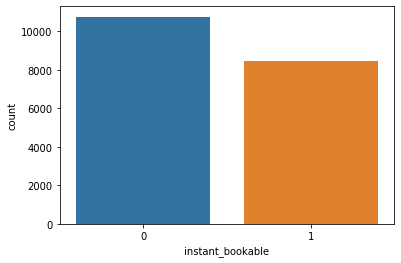

In [267]:
sns.countplot(listings_explore.instant_bookable)
plt.show()

In [268]:
percentage_of(listings_explore.instant_bookable, [0,1])

0    0.56
1    0.44
Name: instant_bookable, dtype: float64

instant_bookable and non-instant are similar, but not instant bookable has about 12% more instances.

In [269]:
cat_attribs.append('instant_bookable')

Clean.

## **Feature: cancellation_policy**

In [270]:
preliminaries(listings_explore, 'cancellation_policy')

Dtype:  object
Missing Values:  0


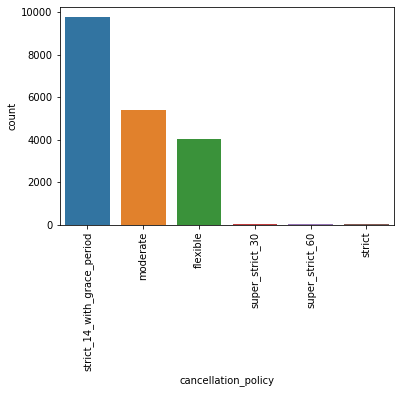

In [271]:
fig = sns.countplot(listings_explore.cancellation_policy)
fig.set_xticklabels(labels=listings_explore.cancellation_policy.unique(), rotation=90)
plt.show()

In [272]:
percentage_of(listings_explore.cancellation_policy, pd.unique(listings_explore.cancellation_policy))

strict_14_with_grace_period    0.51
moderate                       0.28
flexible                       0.21
super_strict_30                0.00
super_strict_60                0.00
strict                         0.00
Name: cancellation_policy, dtype: float64

Strict with 14 grace period has 51%, moderate and flexible have about 28%, and the other 3 have almost none.

In [273]:
cat_attribs.append('cancellation_policy')

Clean.

**Feature: require_guest_profile_picture**

In [274]:
preliminaries(listings_explore, 'require_guest_profile_picture', values=True)

Dtype:  object
Missing Values:  0
f    18697
t      535
Name: require_guest_profile_picture, dtype: int64


In [275]:
# Convert t/f to 1/0
listings_explore['require_guest_profile_picture'] = convert_tf(listings_explore, 'require_guest_profile_picture')

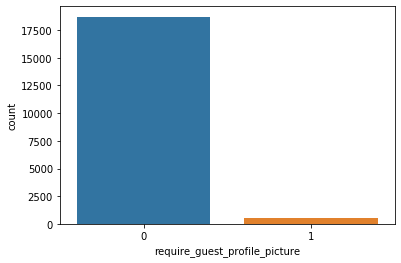

In [276]:
sns.countplot(listings_explore.require_guest_profile_picture)
plt.show()

Virtually no listings require guest profile picture.

This feature is quite imbalanced and intuitively does not factor into price very much for a potential guest (as adding a profile picture is rather quick and easy with smartphones today), so we will remove this feature.

In [277]:
listings_explore.drop(columns='require_guest_profile_picture', inplace=True)
dropped_cols.append('require_guest_profile_picture')

Clean.

#### **Feature: require_guest_phone_verification**

In [278]:
preliminaries(listings_explore, 'require_guest_phone_verification', values=True)

Dtype:  object
Missing Values:  0
f    18614
t      618
Name: require_guest_phone_verification, dtype: int64


In [279]:
# Convert t/f to 1/0
listings_explore['require_guest_phone_verification'] = convert_tf(listings_explore, 'require_guest_phone_verification')

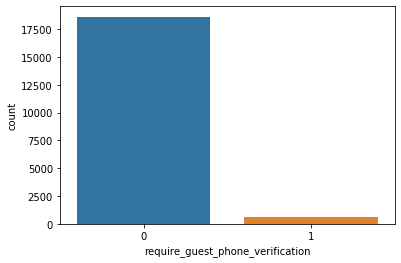

In [280]:
sns.countplot(listings_explore.require_guest_phone_verification)
plt.show()

This feature is quite imbalanced and intuitively does not factor into price very much for a potential guest (as phone verification is rather easy with smartphones today), so we will remove this feature.

In [281]:
listings_explore.drop(columns='require_guest_phone_verification', inplace=True)
dropped_cols.append('require_guest_phone_verification')

# Feature Correlation

Now that we have finished our first round of feature cleaning and analysis, we will move on to analyzing feature correlations.

Here, we will analyze Pearson and Spearman (linear and non-linear) feature correlations in order to remove features with multicollinearity, and identify features highly correlated with our label feature 'price'.

In [282]:
# Send 'price' column to end of dataframe for correlation matrix readability
all_cols = listings_explore.columns.tolist()
price_ind = all_cols.index('price')
new_cols = all_cols[0:15] + all_cols[16:] + [all_cols[15]]
new_cols
listings_explore = listings_explore[new_cols]

### Pearson Linear Correlations

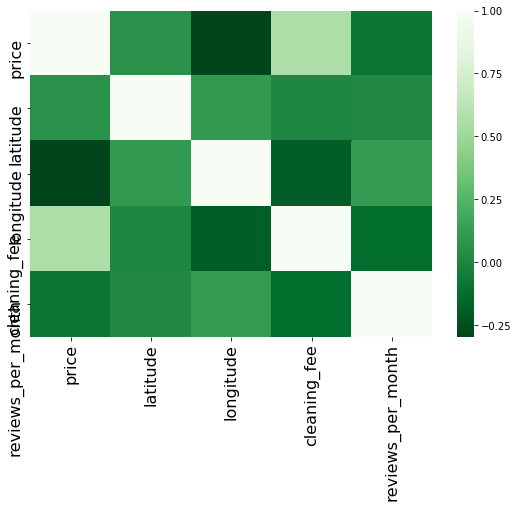

In [283]:
# Pearson Correlation Matrix
pearson_cols = num_attribs.copy()
fig, ax = plt.subplots(figsize=(9,6))
sns.heatmap(listings_explore[pearson_cols].corr(method='pearson'), cmap='Greens_r', ax=ax)
ax.tick_params(labelsize=16)

Our numerical variables are not highly correlated to each other. Cleaning fee has the highest correlation to price.

We will now create a Spearman correlation matrix in order to measure non-linear correlations between our ordinal and categorical features.

### Spearman Non-Linear Correlations

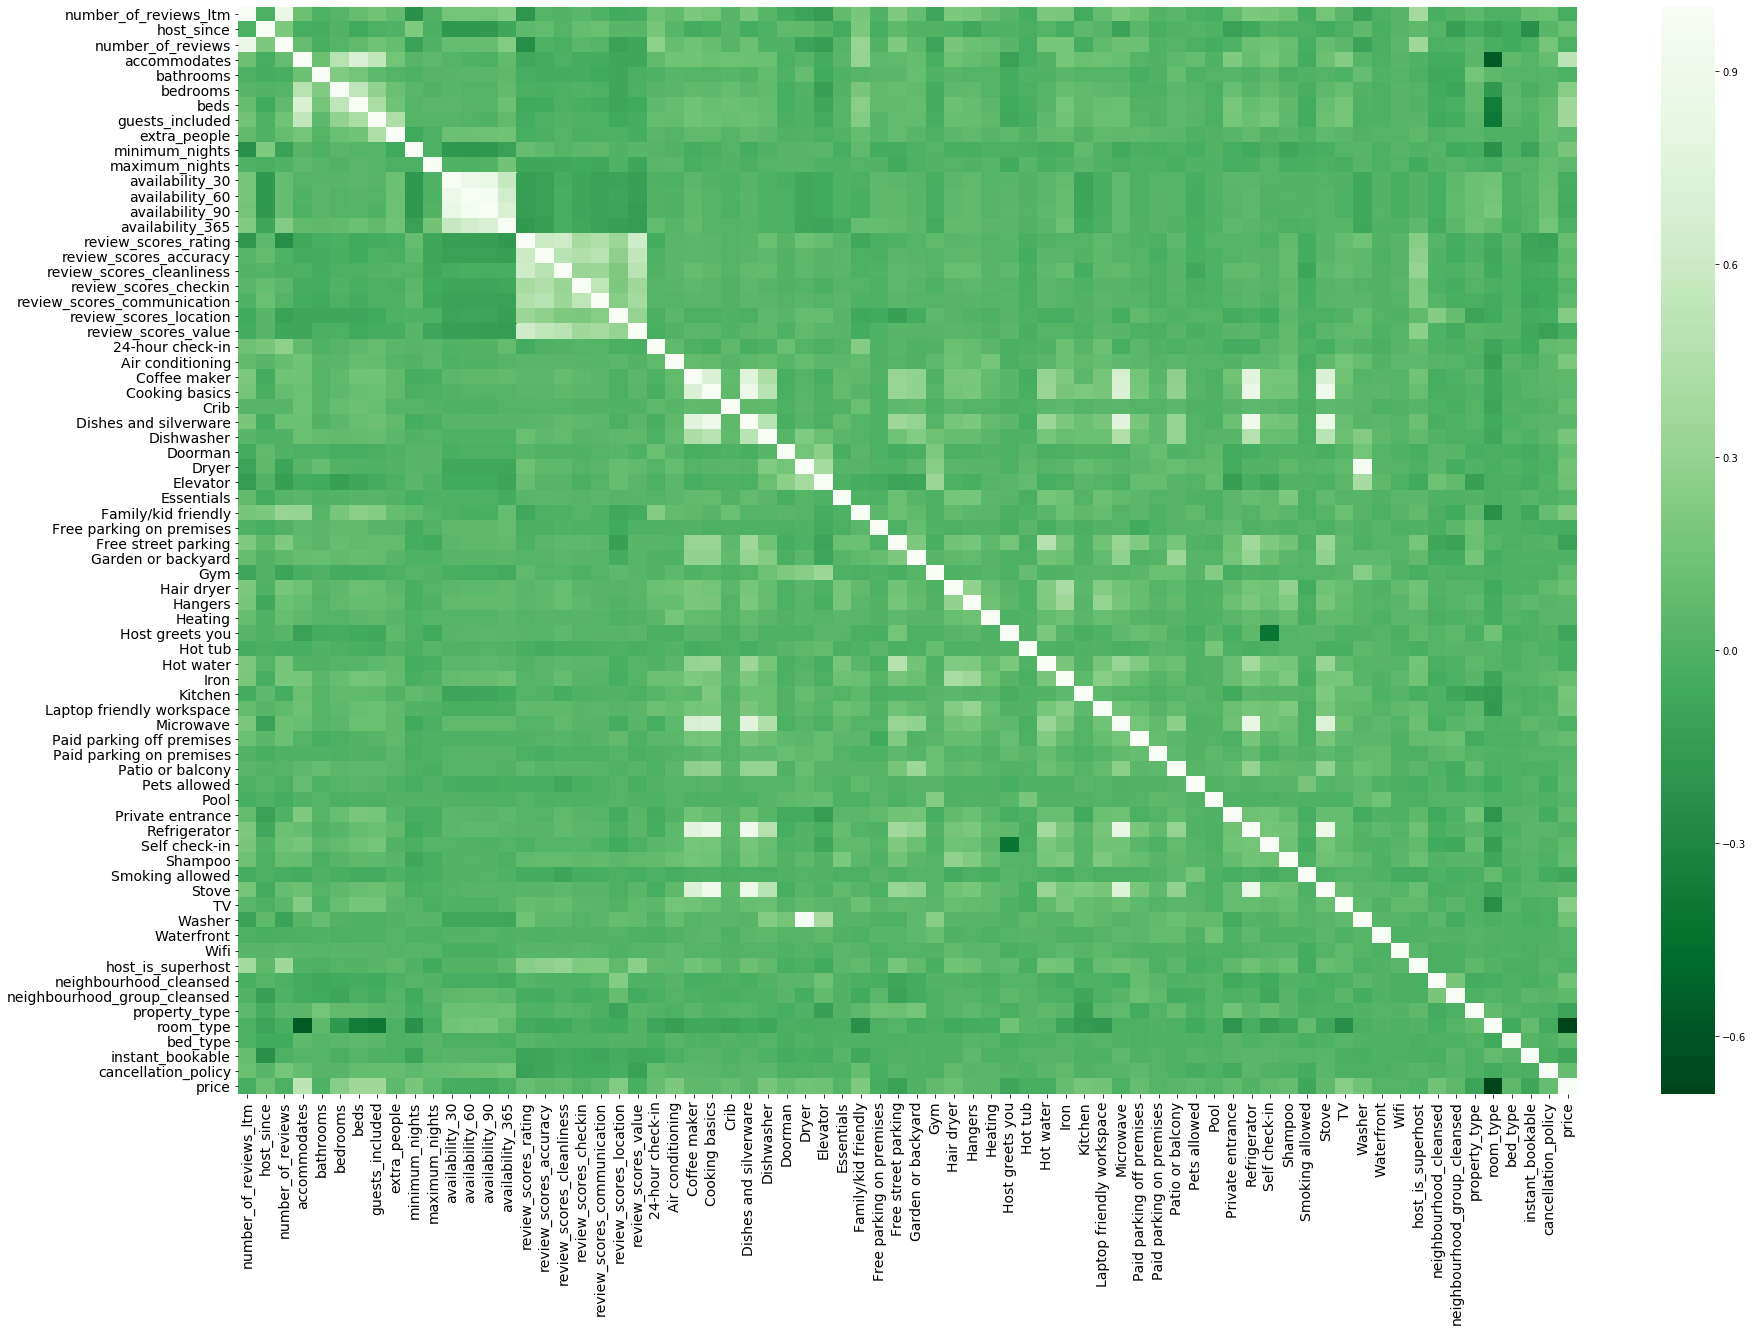

In [284]:
# Spearman Correlation Matrix
# Create spearman dataframe
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
spearman_df = listings_explore.copy(deep=True)
spearman_df.dropna(axis=0,inplace=True)
spearman_df[cat_attribs] = OrdinalEncoder().fit_transform(spearman_df[cat_attribs])
# Create spearman columns
spearman_cols = []
spearman_cols.extend(disc_attribs)
spearman_cols.extend(amen_attribs)
spearman_cols.extend(cat_attribs)
spearman_cols.append('price')
# Create heatmap
fig, ax = plt.subplots(figsize=(30,20))
sns.heatmap(spearman_df[spearman_cols].corr(method='spearman'), cmap='Greens_r', ax=ax)
ax.tick_params(labelsize=14)

Based on feature correlations, we will remove features with high multicollinearity.

In [285]:
# Drop highly correlated features
corr_drop = ['number_of_reviews_ltm', # keep number_of_reviews (higher corr with price)
             'availability_60', 'availability_90', # keep availability_30,
             'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_value', # keep rating and location
             'Dishes and silverware', 'Coffee maker', 'Refrigerator', 'Microwave', 'Stove', # keep cooking_basics
             'Dryer', # keep washer
            ]

In [286]:
# DataFrame of our columns by attribute type
col_df = pd.DataFrame({'Numerical': pd.Series(num_attribs),
              'Discrete:': pd.Series(disc_attribs),
              'Categorical': pd.Series(cat_attribs),
              'Amenities': pd.Series(amen_attribs)}).fillna('')
# Dataframe of features highly correlated with price
corr_df = pd.DataFrame({'numerical': pd.Series(['longitude', 'cleaning_fee', 'reviews_per_month']),
                        'discrete': pd.Series(['host_since', 'host_listings_count', 'accommodates', 'bedrooms', 'beds', 'guests_included',
                                     'minimum_nights', 'review_scores_location']),
                        'categorical': pd.Series(['instant_bookable', 'Free parking on premises', 'Free street parking',
                                        'Host greets you', 'Hot water', 'Smoking allowed'])}).fillna('')

We will now view our Spearman correlation matrix again after removing multicollinearity.

After eliminating features with multicollinearity, we can visually confirm below that we have drastically reduced the amount of feature correlations.

In [287]:
# List of features highly correlated with price
highly_correlated = ['host_since', # discrete
                     'host_listings_count', # discrete
                     'longitude', # numerical
                     'accommodates', # discrete
                     'bedrooms', # discrete
                     'beds', # discrete
                     'cleaning_fee', # numerical
                     'guests_included', # discrete
                     'minimum_nights', # discrete
                     'review_scores_location', # discrete
                     'instant_bookable', # categorical
                     'reviews_per_month', # numerical
                     'Free parking on premises', # categorical
                     'Free street parking', # # categorical
                     'Host greets you', # categorical
                     'Hot water', # categorical
                     'Smoking allowed', # categorical
                     'TV', # categorical
                    ]

# Missing Value Imputation (for exploration of data)
This missing value imputation using Pandas is for the multi-variate analysis below, but the true missing value imputations are performed later in our Scikit-Learn Pipeline and ColumnTransformer (with the same mean/mode strategy).

In [288]:
# Impute missing values
listings_explore.fillna(listings_explore[num_attribs].mean(), inplace=True) # mean for numerical
listings_explore.fillna(listings_explore[disc_attribs].mode().iloc[0], inplace=True) # mode
listings_explore.fillna(listings_explore[cat_attribs].mode().iloc[0], inplace=True) # mode
listings_explore.fillna(listings_explore[amen_attribs].mode().iloc[0], inplace=True) # mode

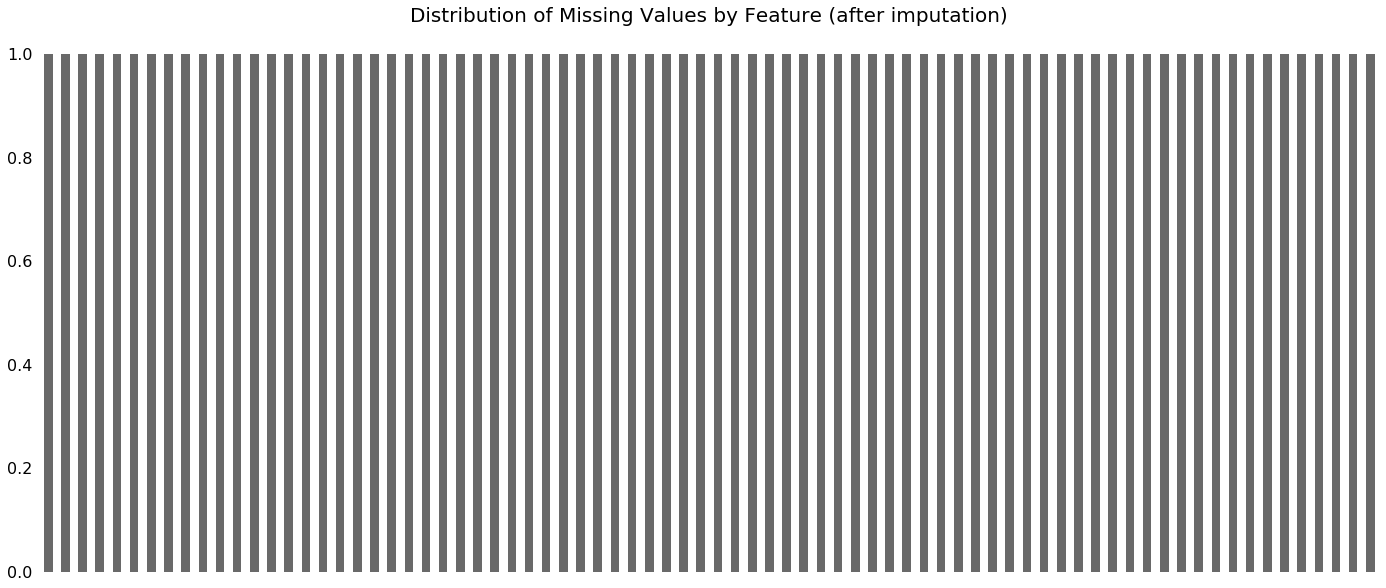

In [289]:
# Confirm missing values imputed
missingno.bar(listings_explore)
plt.title('Distribution of Missing Values by Feature (after imputation)', fontsize=20)
plt.show()

# Statistical Analysis of Numerical Features

In [290]:
# Function to plot pearsonr and p-value for regplots
from scipy.stats import pearsonr
def corrfunc(x, y, **kws):
    (r, p) = pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f} ".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)
    ax.annotate("p = {:.3f}".format(p),
                xy=(.4, .9), xycoords=ax.transAxes)

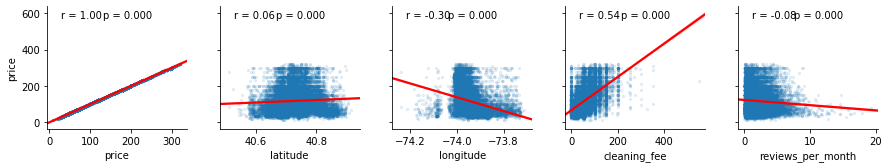

In [291]:
# Regplot numerical features
fig = sns.pairplot(x_vars = num_attribs, y_vars='price', data=listings_explore, kind='reg',
             plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1, 's': 5}})
fig.map(corrfunc)
plt.show()

In [292]:
# Create dictionary of value counts for listings_explore for chisquare goodness of fit tests
listings_dict={}
for col in listings_explore.columns:
    listings_dict[col] = listings_explore[col].value_counts()

In [293]:
# chi-square neighbourhood_cleansed
chi, p = scipy.stats.chisquare(listings_dict['neighbourhood_cleansed'])
print(chi, p)

111251.18406821963 0.0


In [294]:
# chi-square neighbourhood_group_cleansed
chi, p = scipy.stats.chisquare(listings_dict['neighbourhood_group_cleansed'])
print(chi, p)

15215.532237936772 0.0


In [295]:
# chi-square property_type
chi, p = scipy.stats.chisquare(listings_dict['property_type'])
print(chi, p)

144618.14871048252 0.0


In [296]:
# chi-square room_type
chi, p = scipy.stats.chisquare(listings_dict['room_type'])
print(chi, p)

8282.945819467554 0.0


In [297]:
# chi-square bed_type
chi, p = scipy.stats.chisquare(listings_dict['bed_type'])
print(chi, p)

73880.40744592347 0.0


# Multi-Variate Analysis

For our multi-variate analysis, we will think about what questions we are looking to answer with this data. The focus will be on business intelligence that will help Airbnb to gain insights into its market and drive further efficiency and revenue. Specifically, our data revolves around our hosts and their property information, so we will center our questions and strategy around our hosts.

1. Which hosts generate the most revenue? Our hosts who have been renting with Airbnb the longest, who have the most frequent bookings, who have the highest listings counts, and charge the highest price for their listings.


2. Which locations generate the most revenue?


3. Which types of places do guests rent the most? Based on reviews and frequency of stay.

Target the customers that are the most loyal. 
Most important hosts are hosts with more expensive places.
Your average $ is gonna be the most hosts frequency-wise.
How loyal are they?
How many listings do they have?
Segment the most expensive buildings - target them with advertising so they keep remaining loyal.
Also prefer superhost/longer hosting because it means more people are gonna buy from this place.
And how often their places are booked is important.

ie subscribe your good hosts to airbnb magazine.

Ideas for the future:
Monitor when your hosts slow down or stop listing their listings, and blast them with marketing to get them back into hosting.
Reports of subleases for longer-term stays.
Where is tourism growing? Most guests are tourists.

## Host Analysis

### Which hosts have been renting with Airbnb the longest?

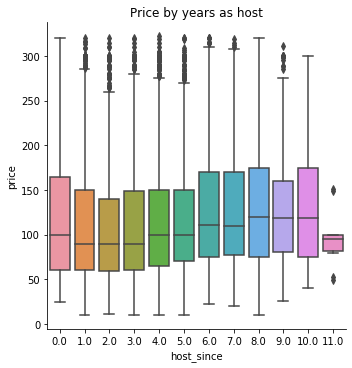

In [298]:
sns.catplot(x='host_since', y='price', data=listings_explore, kind='box', showfliers=True)
plt.title('Price by years as host')
plt.show()

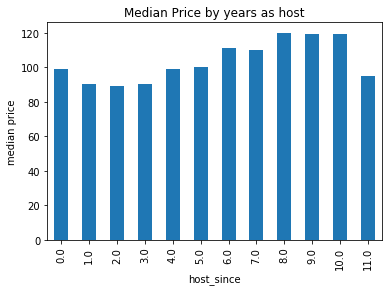

In [299]:
listings_explore.groupby('host_since').median().price.plot(kind='bar')
plt.ylabel('median price')
plt.title('Median Price by years as host')
plt.show()

### Which hosts have the most frequent bookings?

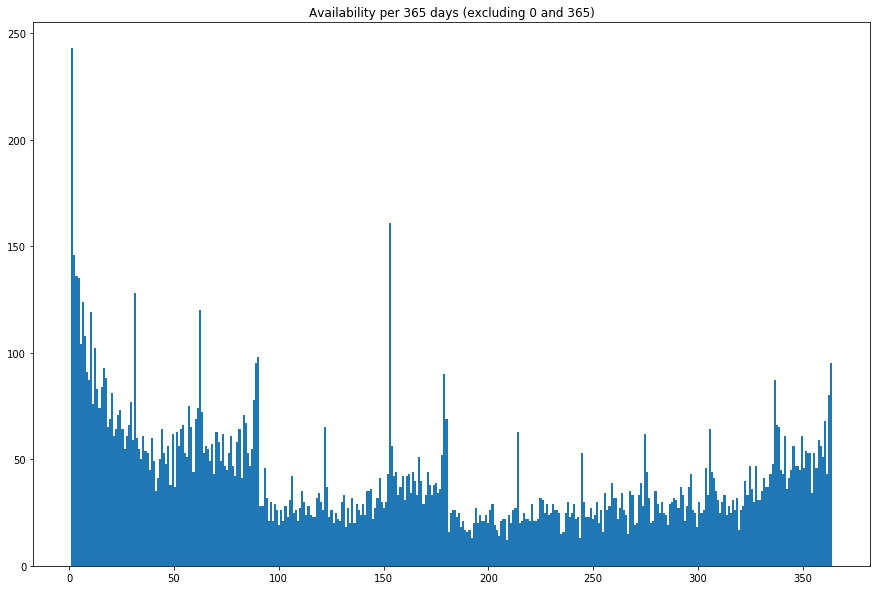

In [369]:
plt.figure(figsize=(15,10))
plt.hist(listings_explore[(listings_explore.availability_365 > 0) & (listings_explore.availability_365 < 365)].availability_365, bins=364)
plt.title('Availability per 365 days (excluding 0 and 365)')
plt.show()

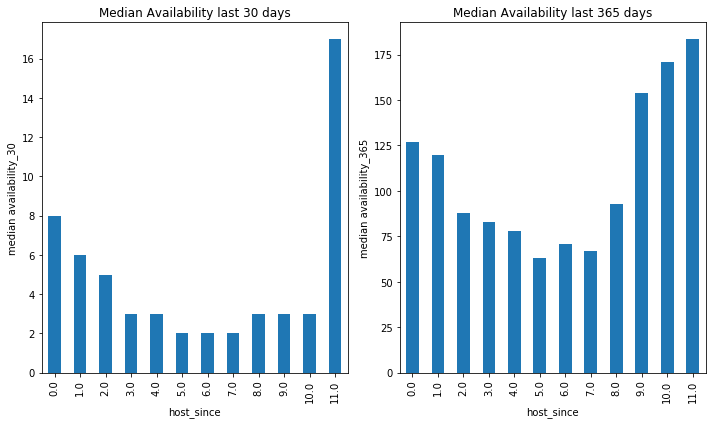

In [300]:
fig, ax = plt.subplots(1,2,figsize=(10,6))
listings_explore.groupby('host_since').median().availability_30.plot(kind='bar', ax=ax[0])
ax[0].set_ylabel('median availability_30')
ax[0].set_title('Median Availability last 30 days')
listings_explore.groupby('host_since').median().availability_365.plot(kind='bar', ax=ax[1])
ax[1].set_ylabel('median availability_365')
ax[1].set_title('Median Availability last 365 days')
fig.tight_layout()
plt.show()

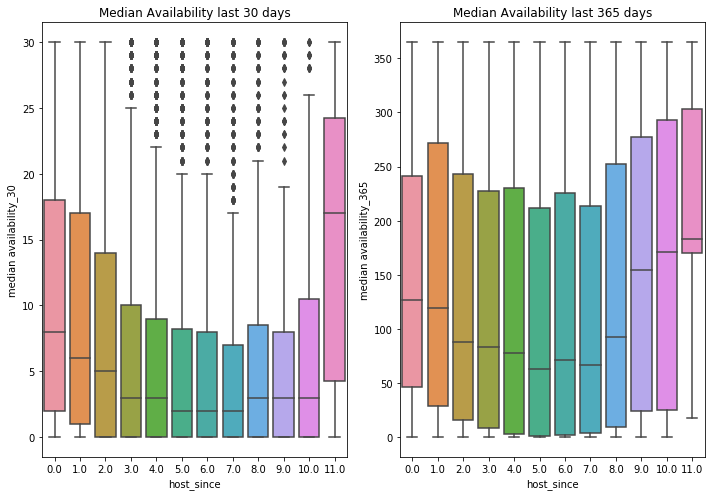

In [301]:
fig, ax = plt.subplots(1,2,figsize=(10,7))
sns.boxplot(x='host_since', y='availability_30', data=listings_explore, ax=ax[0])
ax[0].set_ylabel('median availability_30')
ax[0].set_title('Median Availability last 30 days')
sns.boxplot(x='host_since', y='availability_365', data=listings_explore, ax=ax[1])
ax[1].set_ylabel('median availability_365')
ax[1].set_title('Median Availability last 365 days')
fig.tight_layout()
plt.show()

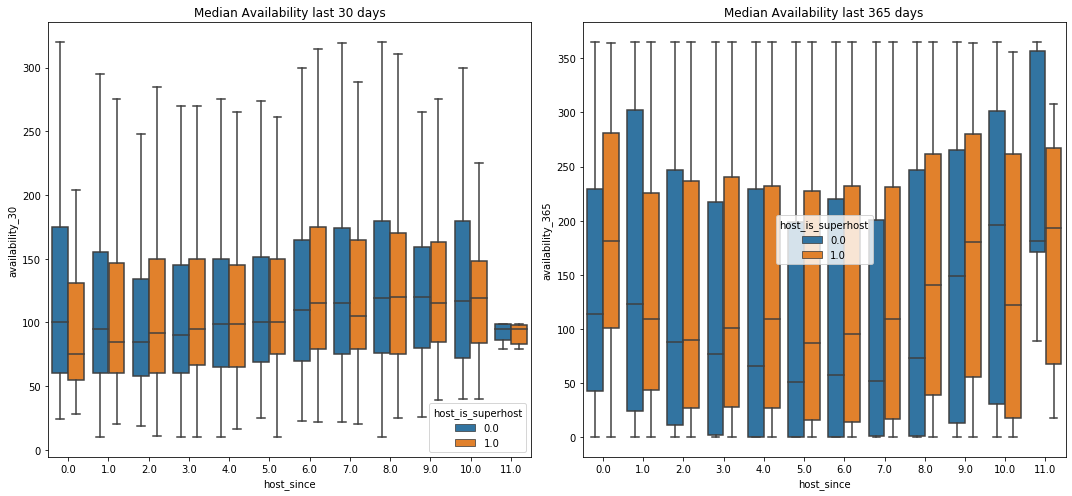

In [302]:
fig, ax = plt.subplots(1,2,figsize=(15,7))
sns.boxplot(x='host_since', y='price', data=listings_explore,
            hue='host_is_superhost', showfliers=False, ax=ax[0])
ax[0].set_ylabel('availability_30')
ax[0].set_title('Median Availability last 30 days')
sns.boxplot(x='host_since', y='availability_365', data=listings_explore,
            hue='host_is_superhost', showfliers=False, ax=ax[1])
ax[1].set_ylabel('availability_365')
ax[1].set_title('Median Availability last 365 days')
fig.tight_layout()
plt.show()

Interestingly, a superhost does not seem to command higher prices or have more availability. We would need more information to see the ratios of days the listings are actually available versus the days rented. Hosts may not make their listing available every night of the month/year. But with the information we have, it seems there is no significant difference between superhosts and non-superhosts when it comes to prices and frequency of rents.

### Which hosts have the most listings?

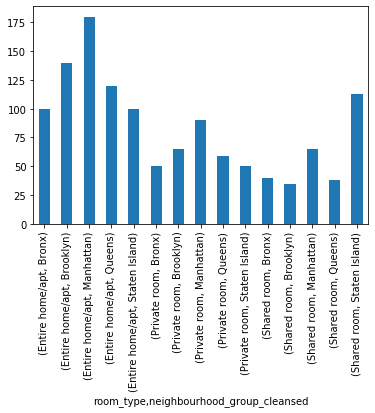

In [303]:
listings_explore.groupby(['room_type', 'neighbourhood_group_cleansed']).median().price.plot(kind='bar')
plt.show()

### Which room types generate the most revenue?

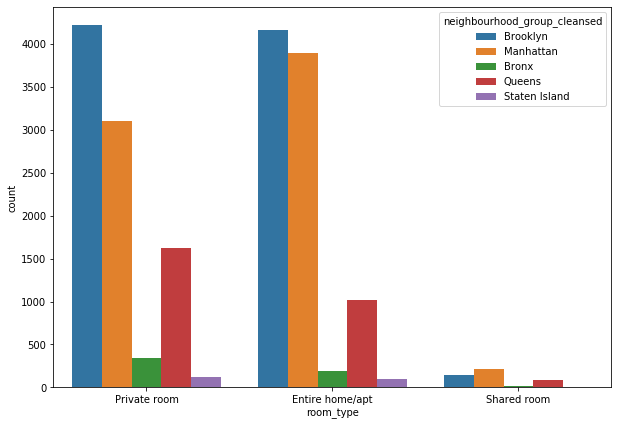

In [304]:
plt.figure(figsize=(10,7))
sns.countplot(listings_explore.room_type, hue=listings_explore.neighbourhood_group_cleansed)
plt.show()

Private rooms and entire homes are by far the most common room types, at about equal frequencies. Shared rooms have very low counts in comparison.


Brooklyn has a higher ratio of private rooms, while Manhattan has a higher ratio of entire homes/apartments. This would be one reason that Manhattan's median prices are higher than Brooklyn's, along with property values in general being higher in Manhattan. Queens has more private rooms than entire homes/apartments.

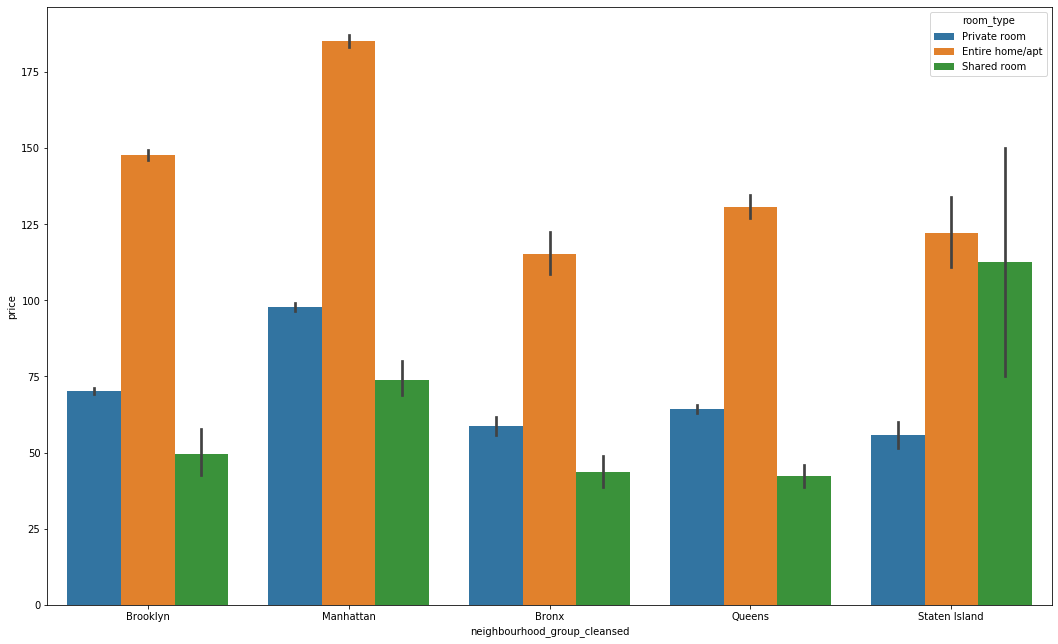

In [305]:
plt.figure(figsize=(18,11))
sns.barplot(x='neighbourhood_group_cleansed', y='price', hue='room_type', data=listings_explore)
plt.show()

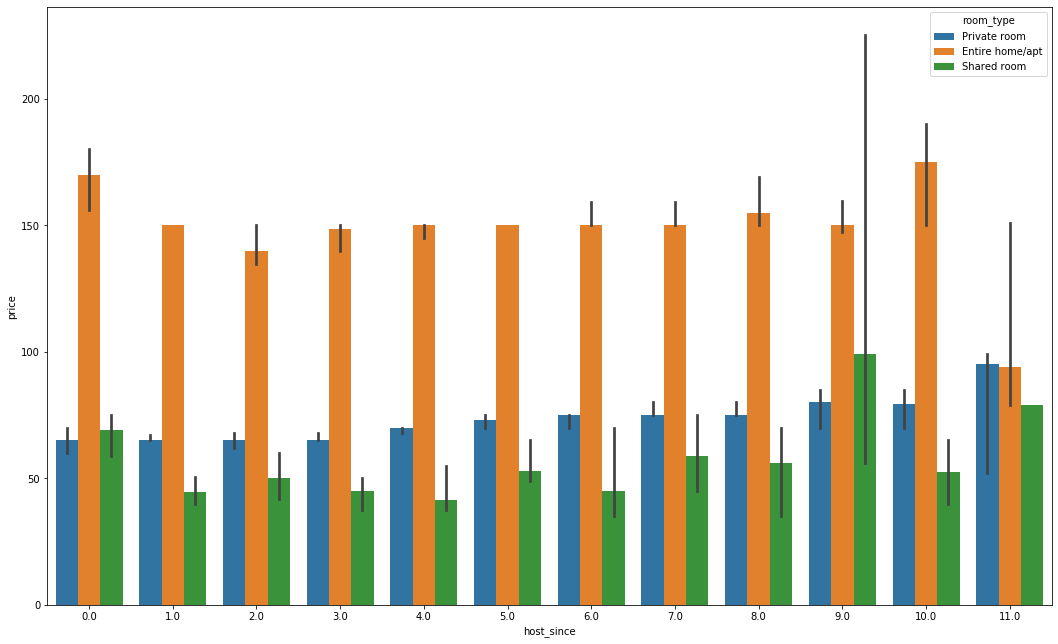

In [306]:
plt.figure(figsize=(18,11))
sns.barplot(x='host_since', y='price', hue='room_type', data=listings_explore[listings_explore.host_listings_count < 10], ci=95, estimator=median)#, ci=95)#, showfliers=False)
plt.title('')
plt.show()

### Which hosts have the most listings?

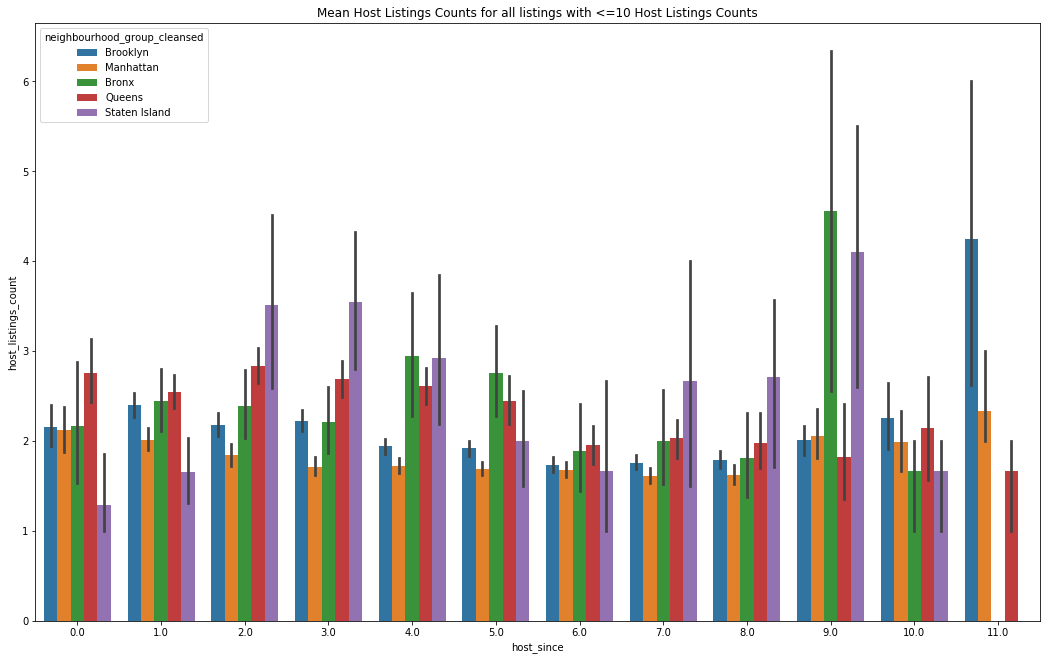

In [307]:
plt.figure(figsize=(18,11))
sns.barplot(x='host_since', y='host_listings_count', hue='neighbourhood_group_cleansed', data=listings_explore[listings_explore.host_listings_count<=10], ci=95)#, estimator=mean)#, ci=95)#, showfliers=False)
plt.title('Mean Host Listings Counts for all listings with <=10 Host Listings Counts')
plt.show()

## Location Analysis

#### Locations by Borough

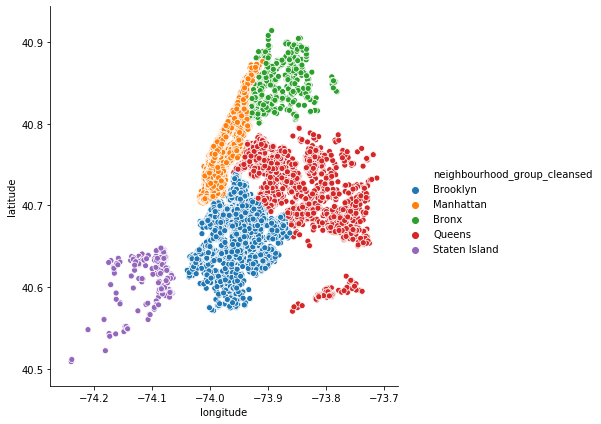

In [309]:
sns.relplot(x='longitude', y='latitude', hue='neighbourhood_group_cleansed',
            data=listings_explore, height=6, aspect=1)
plt.figsize = (10,7)
plt.show()

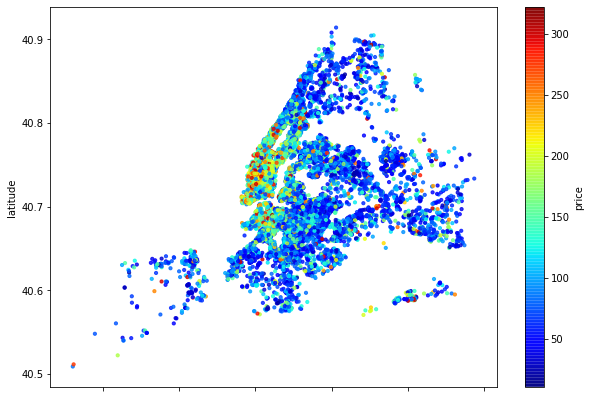

In [310]:
fig = listings_explore.plot(kind='scatter', x="longitude", y="latitude", alpha=0.8,
                            figsize=(10,7), c='price', cmap=plt.get_cmap("jet"),
                            colorbar=True, s=10)
plt.show()

Manhattan and northern Brooklyn have significantly higher prices than other boroughs (the lowest Manhattan prices are in the far Upper West Side nearing the Bronx). Prices also seem to rise near bodies of water.

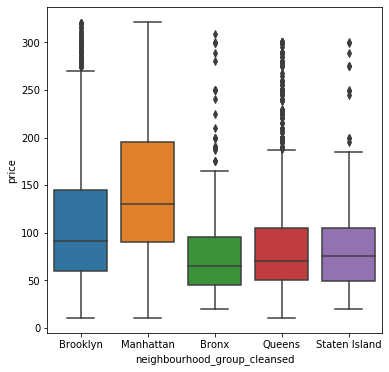

In [330]:
plt.figure(figsize=(6,6))
sns.boxplot(x='neighbourhood_group_cleansed', y='price',
            data=listings_explore)
plt.show()

In [312]:
# Create dataframe of neighborhoods and their median prices (for >=5 listings)

neighbourhoods_medians = []
neighbourhoods_names = []

for neighbourhood in listings_explore.neighbourhood_cleansed.unique():
    #print('{} Prices:\n'.format(neighbourhood))
    if len(listings_explore[listings_explore.neighbourhood_cleansed == neighbourhood]) >= 5:
        neighbourhoods_medians.append(listings_explore[listings_explore.neighbourhood_cleansed == neighbourhood].price.median())
        neighbourhoods_names.append(str(neighbourhood))

nbh_medians = pd.DataFrame({'neighbourhood': neighbourhoods_names, 'median_price': neighbourhoods_medians})
nbh_medians.sort_values(by=['median_price'], ascending=False, inplace=True)

The boxplots confirm that Manhattan has the highest prices on average, followed by Brooklyn (its upper range likely coming from northern Brooklyn).

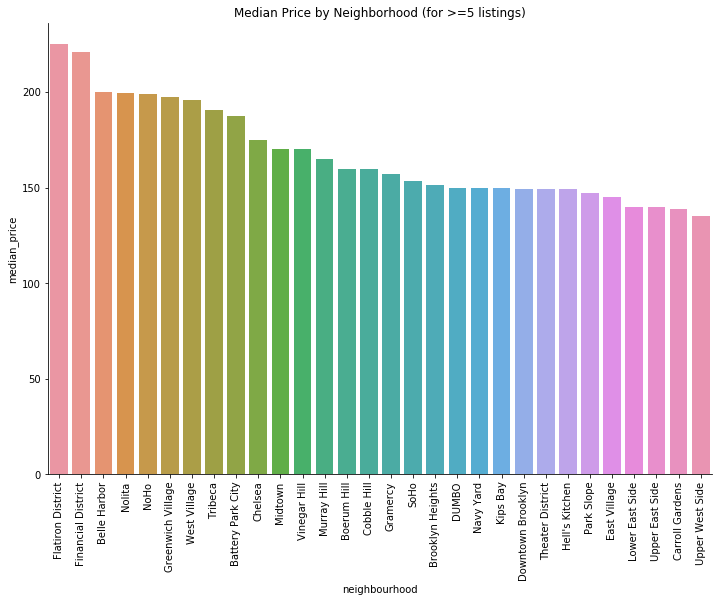

In [313]:
# Top 10 and bottom 10 median prices (for neighborhoods with >=5 total listings)
#sns.set(font_scale=1.5, )
fig = sns.catplot(x='neighbourhood', y='median_price', data=nbh_medians.iloc[pd.np.r_[0:30]],#, -19:-1, -1]],
                  kind='bar', height=7, aspect=1.5)
fig.set_xticklabels(rotation=90)
plt.title('Median Price by Neighborhood (for >=5 listings)')
plt.show()

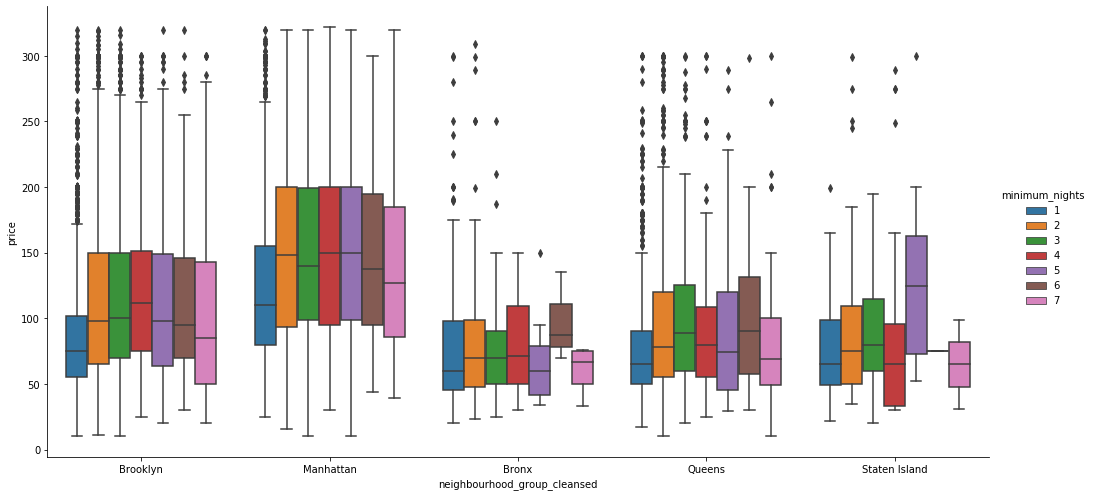

In [314]:
sns.catplot(x='neighbourhood_group_cleansed', y='price',
            data=listings_explore, kind='box',
            hue='minimum_nights', height=7, aspect=2)
plt.show()

## Census Data

Lets pull some more insights from census.gov (2017):
(https://www.census.gov/quickfacts/fact/table/newyorkcountymanhattanboroughnewyork,bronxcountybronxboroughnewyork,queenscountyqueensboroughnewyork,kingscountybrooklynboroughnewyork,richmondcountystatenislandboroughnewyork,newyorkcitynewyork#)
(https://www.baruch.cuny.edu/nycdata/income-taxes/hhold_income-numbers.htm)

In [339]:
# Create dataframe of NYC stats
#nyc_stats = pd.DataFrame(data={'neighbourhood': ['Manhattan', 'Bronx', 'Queens', 'Brooklyn', 'Staten Island']})
#nyc_stats = nyc_stats
nyc_stats = pd.DataFrame(data={'Brooklyn': [944650, 52782], 'Manhattan': [758345, 79781], 'Bronx': [495356, 36593], 'Queens': [777904, 62008], 'Staten_Island': [166150, 76244]},
             index=['households', 'median_household_income'])
nyc_stats = nyc_stats.append(pd.DataFrame(data=
            {'Brooklyn': [len(listings_explore[listings_explore.neighbourhood_group_cleansed == 'Brooklyn'])],
            'Manhattan': [len(listings_explore[listings_explore.neighbourhood_group_cleansed == 'Manhattan'])],
            'Bronx': [len(listings_explore[listings_explore.neighbourhood_group_cleansed == 'Bronx'])],
            'Queens': [len(listings_explore[listings_explore.neighbourhood_group_cleansed == 'Queens'])],
            'Staten_Island': [len(listings_explore[listings_explore.neighbourhood_group_cleansed == 'Staten Island'])]},
            index=['total_listings']))
nyc_stats.loc['households_per_listing'] = (nyc_stats.loc['households'].values / nyc_stats.loc['total_listings'])
nyc_stats = nyc_stats.append(pd.DataFrame(data=
            {'Brooklyn': [listings_explore[listings_explore.neighbourhood_group_cleansed == 'Brooklyn'].price.median()],
            'Manhattan': [listings_explore[listings_explore.neighbourhood_group_cleansed == 'Manhattan'].price.median()],
            'Bronx': [listings_explore[listings_explore.neighbourhood_group_cleansed == 'Bronx'].price.median()],
            'Queens': [listings_explore[listings_explore.neighbourhood_group_cleansed == 'Queens'].price.median()],
            'Staten_Island': [listings_explore[listings_explore.neighbourhood_group_cleansed == 'Staten Island'].price.median()]},
            index=['median_listing_price']))
nyc_stats = nyc_stats.append(pd.DataFrame(data=
            {'Brooklyn': [listings_explore[listings_explore.neighbourhood_group_cleansed == 'Brooklyn'].price.sum()],
            'Manhattan': [listings_explore[listings_explore.neighbourhood_group_cleansed == 'Manhattan'].price.sum()],
            'Bronx': [listings_explore[listings_explore.neighbourhood_group_cleansed == 'Bronx'].price.sum()],
            'Queens': [listings_explore[listings_explore.neighbourhood_group_cleansed == 'Queens'].price.sum()],
            'Staten_Island': [listings_explore[listings_explore.neighbourhood_group_cleansed == 'Staten Island'].price.sum()]},
            index=['total_revenue']))

nyc_stats = nyc_stats.round(0).astype('int').T
nyc_stats['neighbourhood'] = ['Brooklyn', 'Manhattan', 'Bronx', 'Queens', 'Staten Island']
cols = nyc_stats.columns.tolist()
cols = [cols[-1]] + cols[:-1]
nyc_stats = nyc_stats[cols]
nyc_stats

,neighbourhood,households,median_household_income,total_listings,households_per_listing,median_listing_price,total_revenue
Brooklyn,Brooklyn,944650,52782,8527,111,91,918807
Manhattan,Manhattan,758345,79781,7212,105,130,1041371
Bronx,Bronx,495356,36593,551,899,65,42506
Queens,Queens,777904,62008,2725,285,70,240647
Staten_Island,Staten Island,166150,76244,217,766,75,18769


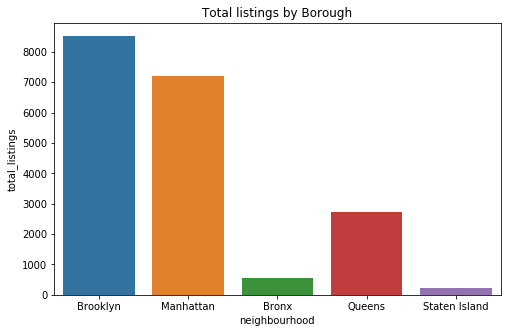

In [340]:
plt.figure(figsize=(8,5))
sns.barplot(x='neighbourhood', y='total_listings', data=nyc_stats)
plt.title('Total listings by Borough')
plt.show()

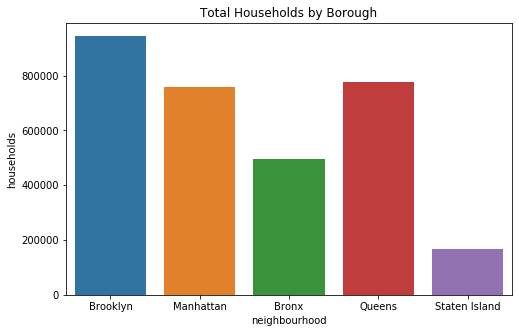

In [341]:
plt.figure(figsize=(8,5))
sns.barplot(x='neighbourhood', y='households', data=nyc_stats)
plt.title('Total Households by Borough')
plt.show()

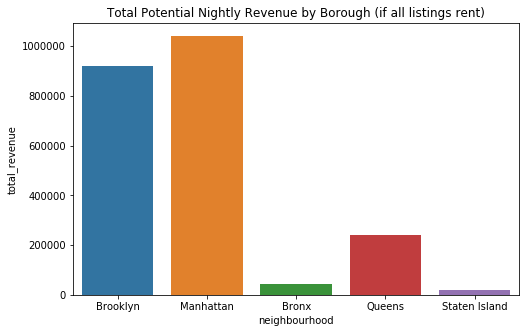

In [344]:
plt.figure(figsize=(8,5))
sns.barplot(x='neighbourhood', y='total_revenue', data=nyc_stats)
plt.title('Total Potential Nightly Revenue by Borough (if all listings rent)')
plt.show()

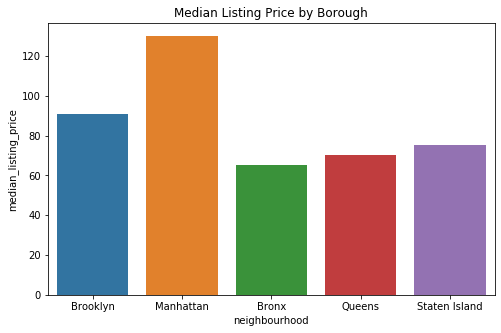

In [345]:
plt.figure(figsize=(8,5))
sns.barplot(x='neighbourhood', y='median_listing_price', data=nyc_stats)
plt.title('Median Listing Price by Borough')
plt.show()

In [348]:
nyc_stats

,neighbourhood,households,median_household_income,total_listings,households_per_listing,median_listing_price,total_revenue
Brooklyn,Brooklyn,944650,52782,8527,111,91,918807
Manhattan,Manhattan,758345,79781,7212,105,130,1041371
Bronx,Bronx,495356,36593,551,899,65,42506
Queens,Queens,777904,62008,2725,285,70,240647
Staten_Island,Staten Island,166150,76244,217,766,75,18769


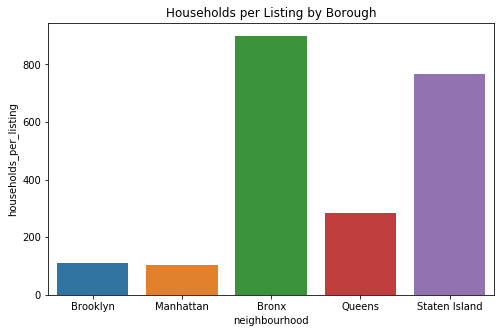

In [355]:
plt.figure(figsize=(8,5))
sns.barplot(x='neighbourhood', y='households_per_listing', data=nyc_stats)
plt.title('Households per Listing by Borough')
plt.show()

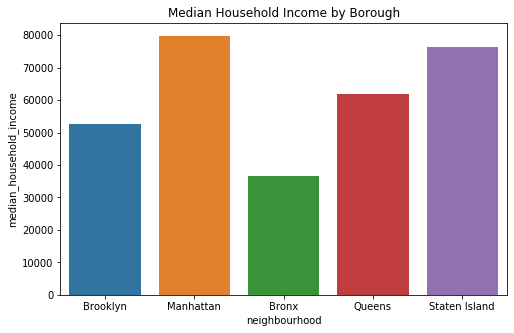

In [356]:
plt.figure(figsize=(8,5))
sns.barplot(x='neighbourhood', y='median_household_income', data=nyc_stats)
plt.title('Median Household Income by Borough')
plt.show()

## Which Airbnb's do guests prefer?

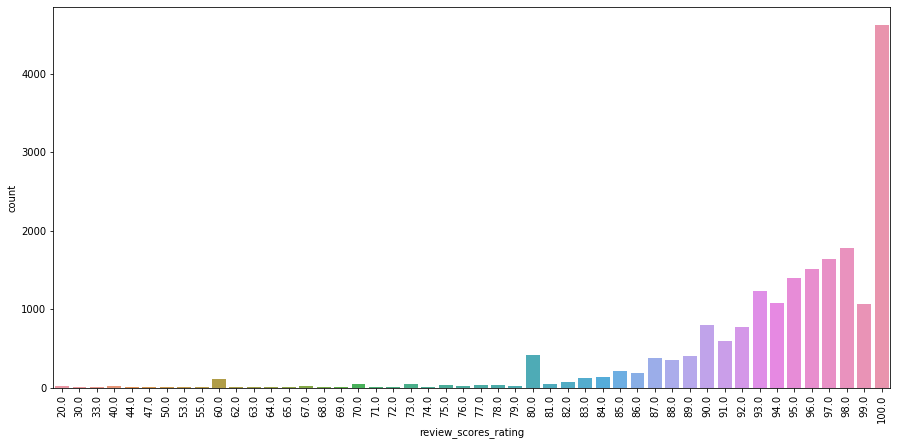

In [321]:
plt.figure(figsize=(15,7))
ax = sns.countplot(listings_explore.review_scores_rating.round(0))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

In [384]:
# Percentage of listings with score >= 90
100 - percentile(listings_explore.review_scores_rating, 89)

86.74344841930116

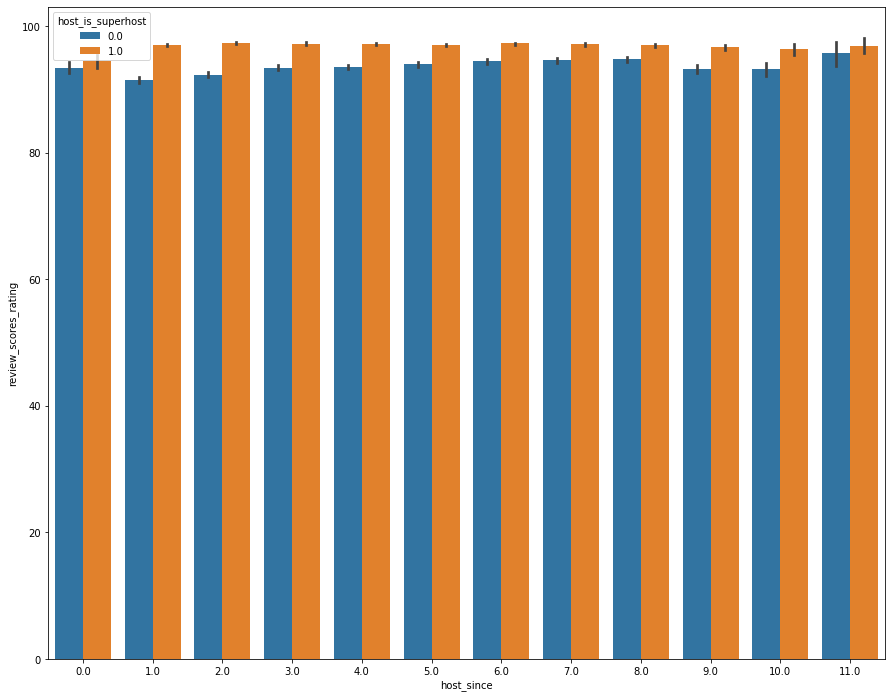

In [322]:
plt.figure(figsize=(15,12))
sns.barplot(x='host_since', y='review_scores_rating', hue='host_is_superhost', data=listings_explore)
plt.show()

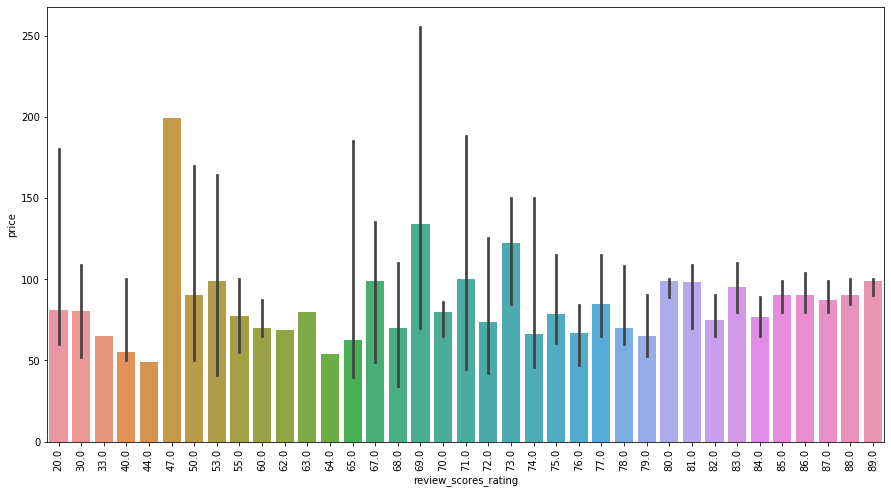

In [324]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x='review_scores_rating', y='price',# hue='neighbourhood_group_cleansed',
                 data=listings_explore[listings_explore.review_scores_rating<90], estimator=median)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

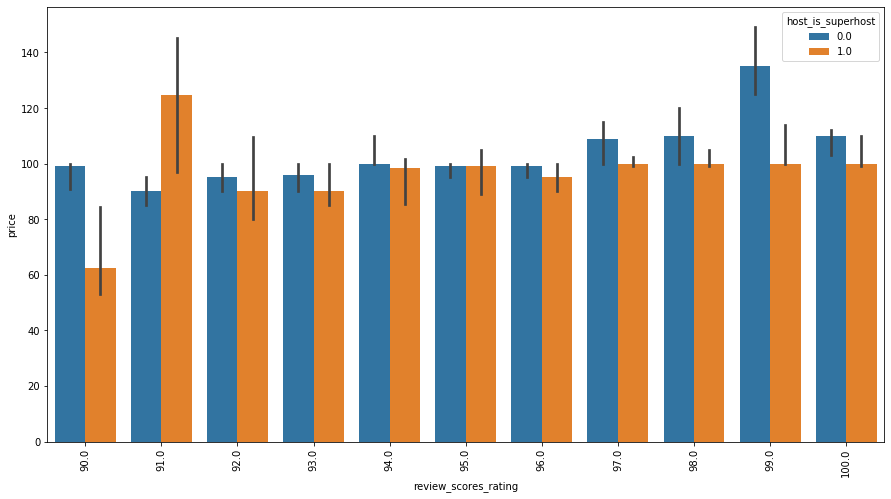

In [323]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x=listings_explore[listings_explore.review_scores_rating>=90].review_scores_rating.round(0),
                 y=listings_explore[listings_explore.review_scores_rating>=90].price,
                 hue=listings_explore[listings_explore.review_scores_rating>=90].host_is_superhost,
                 estimator=median)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

Now that we have finished our analysis, we will remove the features with high multicollinearity from our correlation heatmaps to prepare the DataFrame for our machine learning models.

In [ ]:
listings_explore.drop(columns=corr_drop, inplace=True)
dropped_cols.extend(corr_drop)

# remove items from attribute lists
for attrib in corr_drop:
    try:
        num_attribs.remove(attrib)
    except ValueError:
        pass
for attrib in corr_drop:
    try:
        disc_attribs.remove(attrib)
    except ValueError:
        pass
for attrib in corr_drop:
    try:
        cat_attribs.remove(attrib)
    except ValueError:
        pass
for attrib in corr_drop:
    try:
        amen_attribs.remove(attrib)
    except ValueError:
        pass

# Preparing Training Set for ML Models.

In [306]:
# drop price (label) from num_attribs list
num_attribs.remove('price')

We will now create a function to clean any dataframe based on the preprocessing performed above. This way, any new data can be cleansed through this function in the future, including the test set.

In [307]:
# Function to clean dataframe
def clean_listings(df):
    '''
    Cleans listings dataframe to prepare for ML models.
    
    Args:
    df -- uncleaned listings dataframe
    
    Returns:
    clean_df -- cleaned listings dataframe'''
    
    # 1. Price (string mod, cut)
    
    # Remove string characters, convert to float
    df['price'] = df['price'].astype('str')
    df['price'] = df['price'].str.replace('.00', '', regex=False)
    df['price'] = df['price'].str.replace('$', '', regex=False)
    df['price'] = df['price'].str.replace(',', '', regex=False)
    df['price'] = df['price'].astype('float64')

    # Only include price in range [10, 323]
    df = df[(df.price < 323) & (df.price >= 10)]

    # 2. number_of_reviews_ltm (cut)

    # Only include number_of_reviews_ltm > 0
    df = df[df.number_of_reviews_ltm > 0]

    # 3. host_since (string mod)

    # Convert to how many years host
    df['host_since'] = 2019 - df['host_since'].str[:4].astype('float64')

    # 4. cleaning_fee (string mod)

    # Remove string characters, convert to float
    df['cleaning_fee'] = df.cleaning_fee.str.replace('$', '', regex=False)
    df['cleaning_fee'] = df.cleaning_fee.str.replace('.00', '', regex=False)
    df['cleaning_fee'] = df.cleaning_fee.str.replace(',', '', regex=False)
    df['cleaning_fee'] = df.cleaning_fee.astype('float64')

    # 5. extra_people (string mod)

    # Remove string characters, convert to float
    df['extra_people'] = df.extra_people.str.replace('$', '', regex=False)
    df['extra_people'] = df.extra_people.str.replace('.00', '', regex=False)
    df['extra_people'] = df.extra_people.str.replace(',', '', regex=False)
    df['extra_people'] = df.extra_people.astype('float64')

    # 6. minimum_nights (cut)

    # only include minimum_nights <= 7
    df = df[df.minimum_nights <= 7].copy()

    # 7. maximum_nights (cap)

    # Cap maximum_nights at 1125
    df['maximum_nights'].values[df.maximum_nights > 180] = 180

    # 8. host_is_superhost (convert to 1/0)

    # Convert t/f to 1/0
    df['host_is_superhost'] = convert_tf(df, 'host_is_superhost')

    # 9. host_identity_verified (convert to 1/0) # column is in drop_later actually

    # Convert t/f to 1/0
    #df['host_identity_verified'] = convert_tf(df, 'host_identity_verified')

    # 10. property_type (filter)

    # Filter specific property types
    df = df[
                           (df.property_type == 'Apartment') |
                           (df.property_type == 'House') |
                           (df.property_type == 'Condominium') |
                           (df.property_type == 'Townhouse') |
                           (df.property_type == 'Guest suite') |
                           (df.property_type == 'Guesthouse') |
                           (df.property_type == 'Loft') |
                           (df.property_type == 'Serviced apartment') |
                           (df.property_type == 'Tiny house') |
                           (df.property_type == 'Earth house') |
                           (df.property_type == 'Villa') |
                           (df.property_type == 'Castle') |
                           (df.property_type == 'Cottage') |
                           (df.property_type == 'Dome house')]

    # 11. amenities (cut, string mod)

    # Remove empty values ({})
    df = df[df.amenities != '{}']

    # Remove brackets and quotes, split by ','
    df['amenities'] = df.amenities.astype('str').str.replace('{', '', regex=False).copy()
    df['amenities'] = df.amenities.str.replace('}', '', regex=False).copy()
    df['amenities'] = df.amenities.str.replace('"', '', regex=False).copy()
    df['amenities'] = df.amenities.str.split(',').copy()

    # 12. instant_bookable (convert to 1/0)

    # Convert t/f to 1/0
    df['instant_bookable'] = convert_tf(df, 'instant_bookable')

    # 13. require_guest_profile_picture (convert to 1/0)

    # Convert t/f to 1/0
    df['require_guest_profile_picture'] = convert_tf(df, 'require_guest_profile_picture')
    
    # 14. amenities (multilabelbinarizer)

    # Create columns for each amenity using MultiLabelBinarizer
    from sklearn.preprocessing import MultiLabelBinarizer

    mlb = MultiLabelBinarizer()
    amenities_df = pd.DataFrame(mlb.fit_transform(df.amenities))
    classes = mlb.classes_ # amenity names
    amenities_df.columns = classes # add amenity names as columns

    # Save indices
    indices = np.array(df.index)

    # Merge new amenities columns with original dataframe
    df = pd.concat([df.reset_index(drop=True), amenities_df.reset_index(drop=True)], axis=1)

    # Reapply original indices
    df = df.set_index(indices)

    # Drop 'amenities' column
    df.drop(columns='amenities', inplace=True)

    # Drop unused amenities
    df.drop(columns=dropped_amenities, inplace=True)
    
    #15. LabelEncoder for string-type categories
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    for col in ['neighbourhood_cleansed',
                'neighbourhood_group_cleansed',
                'property_type',
                'room_type',
                'bed_type',
                'cancellation_policy']:
        le.fit(df[col])
        df[col] = le.transform(df[col])
        
    #16. Drop unused features
    df.drop(columns=(dropped_cols+drop_later), inplace=True)
        
    return df

In [308]:
# Clean Training Data
listings_prepared = clean_listings(listings_train)

,host_since,host_is_superhost,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_365,number_of_reviews,review_scores_rating,review_scores_communication,review_scores_location,instant_bookable,cancellation_policy,reviews_per_month,24-hour check-in,Air conditioning,Cooking basics,Crib,Dishwasher,Doorman,Elevator,Essentials,Family/kid friendly,Free parking on premises,Free street parking,Garden or backyard,Gym,Hair dryer,Hangers,Heating,Host greets you,Hot tub,Hot water,Iron,Kitchen,Laptop friendly workspace,Paid parking off premises,Paid parking on premises,Patio or balcony,Pets allowed,Pool,Private entrance,Self check-in,Shampoo,Smoking allowed,TV,Washer,Waterfront,Wifi
37753,2.0,0.0,27,1,40.70229,-73.92223,0,1,2,1.0,1.0,1.0,4,85.0,25.0,1,20.0,1,60,6,325,38,95.0,10.0,10.0,0,3,5.09,0,1,1,0,1,0,0,1,0,0,1,1,0,0,1,1,0,0,1,1,1,1,0,0,0,1,0,0,1,1,0,1,1,0,1
3719,8.0,0.0,33,2,40.74502,-74.00429,0,0,4,1.0,1.0,4.0,4,285.0,90.0,2,50.0,2,10,0,168,45,96.0,10.0,10.0,0,1,0.72,0,1,0,0,0,0,0,1,1,0,0,0,0,1,1,1,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,1
6355,6.0,0.0,79,1,40.69563,-73.98193,0,1,2,1.0,1.0,1.0,4,110.0,70.0,1,0.0,1,3,17,22,34,98.0,10.0,10.0,0,3,1.97,0,1,1,0,1,0,1,1,0,0,0,0,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,1,0,1,1,0,1
44513,3.0,0.0,200,2,40.84232,-73.93772,0,1,1,1.0,1.0,1.0,4,60.0,25.0,1,0.0,2,11,20,49,5,92.0,10.0,10.0,0,0,2.50,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
39362,4.0,0.0,184,1,40.65978,-73.99406,0,1,2,1.0,1.0,1.0,4,50.0,NaN,1,0.0,3,180,0,0,3,93.0,10.0,10.0,0,0,0.52,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1


Remove label feature from training data.

In [309]:
# create y_train from label, drop label from listings_prepared
y_train = listings_prepared['price']
listings_prepared.drop(columns='price', inplace=True)

In [310]:
# Confirm y_train values correct
print(len(y_train))
print(len(listings_prepared))
y_train[0:5]

19232
19232


37753     85.0
3719     285.0
6355     110.0
44513     60.0
39362     50.0
Name: price, dtype: float64

In [311]:
# Compare shape of listings_explore and listings_prepared
print(listings_explore.shape) # +2 cols in drop_later, +1 col is price
print(listings_prepared.shape)

(19232, 65)
(19232, 62)


In [312]:
# Check missing values
sum(listings_prepared.isnull().sum())

3041

## Transformation Pipelines

We will now create transformation Pipelines to scale, missing value impute, and one hot encode the data based on data type, and run it through the training data using ColumnTransformer. These pipelines can later be used to transform the test data as well.

In [313]:
# Create pipelines
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ('num_imputer', SimpleImputer(strategy='median')),
    ('num_scaler', StandardScaler()),
])

disc_pipeline = Pipeline([
    ('disc_imputer', SimpleImputer(strategy='most_frequent')),
    ('disc_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('cat_imputer', SimpleImputer(strategy='most_frequent')),
    ('cat_ohe', OneHotEncoder(categories='auto', drop='first',
                              sparse=False)),
])

amen_pipeline= Pipeline([
    ('amen_imputer', SimpleImputer(strategy='most_frequent')),
])

In [314]:
# Create X_train from ColumnTransformer
from sklearn.compose import ColumnTransformer

listings_prepared_pipeline = listings_prepared.copy()
listings_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('disc', disc_pipeline, disc_attribs),
    ('cat', cat_pipeline, cat_attribs),
    ('amen', amen_pipeline, amen_attribs),
])
X_train = listings_pipeline.fit_transform(listings_prepared_pipeline)

We will also create a separate X_train_trees for tree-based algorithms using only LabelEncoder, not OneHotEncoder for non-binary categories. Tree-based algorithms often perform better on data with less binary columns.

In [316]:
# remove OneHotEncoder from cat_pipeline
cat_pipeline_trees = Pipeline([
    ('cat_imputer_trees', SimpleImputer(strategy='most_frequent')),
])

In [317]:
# X_train_trees
listings_prepared_trees = listings_prepared.copy()
listings_pipeline_trees = ColumnTransformer([
    ('num_trees', num_pipeline, num_attribs),
    ('disc_trees', disc_pipeline, disc_attribs),
    ('cat_trees', cat_pipeline_trees, cat_attribs),
    ('amen_trees', amen_pipeline, amen_attribs),
])
X_train_trees = listings_pipeline_trees.fit_transform(listings_prepared_trees)

In [318]:
# Confirm for no missing values in X_train and X_train_trees
print(sum(pd.DataFrame(X_train).isnull().sum()))
print(sum(pd.DataFrame(X_train_trees).isnull().sum()))

0
0


In [319]:
# Confirm shape
print(X_train_trees.shape)
print(listings_prepared.shape)

(19232, 62)
(19232, 62)


# SelectKBest Feature Importance (Top 10)

Here, we use the SelectKBest method to choose the top 10 most important features. We will then create training data for the top 10 features, and compare our model results with the results of the full training data.

In [320]:
# SelectKBest Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# X_train's column names
X_train_cols = (num_attribs+disc_attribs+cat_attribs+amen_attribs)

# Create X and y
X = pd.DataFrame(X_train_trees, columns=X_train_cols).copy()
y = y_train.copy()

# Fit SelectKBest with k=10
best_features = SelectKBest(score_func=f_regression, k=10)
fit = best_features.fit(X,y)

# Create DataFrames for scores and features (columns)
df_fscores = pd.DataFrame(fit.scores_, columns=['f-score'])
df_pvals = pd.DataFrame(fit.pvalues_, columns=['p-value'])
df_columns = pd.DataFrame(X.columns, columns=['Feature'])

# concat two dataframes for better visualization
featureScores = pd.concat([df_columns,df_fscores,df_pvals], axis=1)
featureScores.columns = ['Feature', 'F-score', 'p-value'] # naming the dataframe columns
featureScores.sort_values(by='F-score', ascending=False).head(10)

,Feature,F-score,p-value
23,room_type,12202.294680,0.000000e+00
2,cleaning_fee,8063.623491,0.000000e+00
8,accommodates,6090.811005,0.000000e+00
12,guests_included,2757.526806,0.000000e+00
11,beds,2540.682177,0.000000e+00
1,longitude,1839.408376,0.000000e+00
10,bedrooms,1828.756253,0.000000e+00
58,TV,1106.252522,6.723969e-236
35,Family/kid friendly,735.710637,4.998905e-159
28,Air conditioning,637.215554,2.397275e-138


In [321]:
# Get top 10 features
top_10 = list(featureScores[featureScores['F-score'] >= 637]['Feature'])
top_10

['longitude',
 'cleaning_fee',
 'accommodates',
 'bedrooms',
 'beds',
 'guests_included',
 'room_type',
 'Air conditioning',
 'Family/kid friendly',
 'TV']

In [322]:
# Modify attrib lists for Top 10
import collections

# num_attribs_10
num_test = top_10 + num_attribs
num_attribs_10 = []
num_attribs_10.extend([item for item, count in collections.Counter(num_test).items() if count > 1])
print(num_attribs_10)

# disc_attribs_10
disc_test = top_10 + disc_attribs
disc_attribs_10 = []
disc_attribs_10.extend([item for item, count in collections.Counter(disc_test).items() if count > 1])
print(disc_attribs_10)

#cat_attribs_10
cat_test = (top_10 + cat_attribs)
cat_attribs_10 = []
cat_attribs_10.extend([item for item, count in collections.Counter(cat_test).items() if count > 1])
print(cat_attribs_10)

#amen_attribs_10
amen_test = (top_10 + amen_attribs)
amen_attribs_10 = []
amen_attribs_10.extend([item for item, count in collections.Counter(amen_test).items() if count > 1])
print(amen_attribs_10)

['longitude', 'cleaning_fee']
['accommodates', 'bedrooms', 'beds', 'guests_included']
['room_type']
['Air conditioning', 'Family/kid friendly', 'TV']


In [323]:
# Create new pipelines and ColumnTransformer for Top 10

# Create pipelines (X_train)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

num_pipeline_ = Pipeline([
    ('num_imputer', SimpleImputer(strategy='median')),
    ('num_scaler', StandardScaler()),
])

disc_pipeline_ = Pipeline([
    ('disc_imputer', SimpleImputer(strategy='most_frequent')),
    ('disc_scaler', StandardScaler()),
])

cat_pipeline_ = Pipeline([
    ('cat_imputer', SimpleImputer(strategy='most_frequent')),
    ('cat_ohe_10', OneHotEncoder(categories='auto', drop='first',
                              sparse=False)),
])

amen_pipeline_ = Pipeline([
    ('amen_imputer', SimpleImputer(strategy='most_frequent')),
])

# Create X_train from ColumnTransformer
from sklearn.compose import ColumnTransformer

listings_prepared_pipeline_ = listings_prepared.copy()
listings_pipeline = ColumnTransformer([
    ('num', num_pipeline_, num_attribs_10),
    ('disc', disc_pipeline_, disc_attribs_10),
    ('cat', cat_pipeline_, cat_attribs_10),
    ('amen', amen_pipeline_, amen_attribs_10),
])
X_train_10 = listings_pipeline.fit_transform(listings_prepared_pipeline)

# remove OneHotEncoder from cat_pipeline
cat_pipeline_trees = Pipeline([
    ('cat_imputer_trees', SimpleImputer(strategy='most_frequent')),
])

# X_train_trees_10
listings_prepared_trees_10 = listings_prepared.copy()
listings_pipeline_trees_10 = ColumnTransformer([
    ('num_trees', num_pipeline, num_attribs_10),
    ('disc_trees', disc_pipeline, disc_attribs_10),
    ('cat_trees_10', cat_pipeline_trees, cat_attribs_10),
    ('amen_trees', amen_pipeline, amen_attribs_10),
])
X_train_trees_10 = listings_pipeline_trees_10.fit_transform(listings_prepared_trees_10)

# Machine Learning Algorithms

In [324]:
# Split training set into validation and train sets
X_train_val, X_val, y_train_val, y_val = train_test_split(X_train.copy(), y_train.copy(),
                                                        test_size=0.2, random_state=42)
# Trees data
X_train_trees_val, X_val_trees, y_train_trees_val, y_val_trees = train_test_split(X_train_trees.copy(), y_train.copy(),
                                                                                test_size=0.2, random_state=42)

In [325]:
# Run Model function
def run_model(model, X_train, y_train):
    '''
    Function to run models and output RMSE.
    
    Args:
    model -- model with parameters
    X_train -- X_train
    y_train -- y_train
    
    Return:
    rmse -- root mean squared error
    run_time -- model run time'''
    
    start_time = time.time() # Timing
    
    # Model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    
    # Metrics
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import r2_score
    rmse = np.round(np.sqrt(mean_squared_error(y_train, y_pred)), 4)
    r2 = np.round(r2_score(y_train, y_pred), 4)
    print('RMSE:', rmse)
    print('r2:', r2)
    
    # Timing
    run_time = (time.time() - start_time)
    print('Running Time: {}'.format(datetime.timedelta(seconds=run_time)))
    
    return rmse, r2, run_time

In [326]:
def run_model_cv(model, X_train, y_train, cv=10):
    '''
    Function to run cross_val_score on a model.
    
    Args:
    model -- model with parameters
    X_train -- X_train
    y_train -- y_train
    
    Return:
    cv_scores -- RMSE scores of each k-fold
    run_time'''
    
    start_time = time.time() # Timing
    from sklearn.model_selection import cross_validate

    scoring = {'RMSE': 'neg_mean_squared_error',
               'r2': 'r2'}
    scores = cross_validate(model, X_train, y_train, scoring=scoring,
                             cv=cv, return_train_score=False)
    rmse = np.round(np.mean(np.sqrt(-scores['test_RMSE'])), 4)
    r2 = np.round(np.mean(scores['test_r2']), 4)
    print('RMSE CV:', rmse)
    print('r2 CV:', r2)
    
    # Timing
    run_time = (time.time() - start_time)
    print('Running Time: {}'.format(datetime.timedelta(seconds=run_time)))
    
    return rmse, r2

"    from sklearn.model_selection import cross_val_score\n    start_time = time.time() # Timing\n    cv_scores = cross_val_score(model, X_train, y_train,\n                                      scoring='r2', #'neg_mean_squared_error',\n                                      cv=cv)\n    #cv_scores = np.sqrt(-cv_scores)\n    # Metrics\n    #print('CV RMSE:', cv_scores.mean())\n    #print('CV Std:', cv_scores.std())\n    run_time = (time.time() - start_time)\n    print('Running Time: {}'.format(datetime.timedelta(seconds=run_time)))\n    \n    return cv_scores"

In [327]:
# RandomSearchCV
def random_search(est, params, nbr_iter, X_train, y_train, cv=10):
    start_time = time.time() # Timing
    from sklearn.model_selection import RandomizedSearchCV
    rdmsearch = RandomizedSearchCV(est, param_distributions=params,
                                   scoring='neg_mean_squared_error',
                                   n_iter=nbr_iter, cv=cv)
    rdmsearch.fit(X_train, y_train)
    best_params = rdmsearch.best_params_
    best_estimator = rdmsearch.best_estimator_
    best_score = rdmsearch.best_score_
    print('Best RMSE:', np.sqrt(-best_score))
    print(best_params)
    # Timing
    run_time = (time.time() - start_time)
    print('Running Time: {}'.format(datetime.timedelta(seconds=run_time)))
    return rdmsearch, best_estimator

In [328]:
# Plot Learning Curves function
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)

## Linear Regression

In [385]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
# Run Model
lin_reg_rmse, lin_reg_r2, lin_reg_time = run_model(lin_reg, X_train, y_train)
print()
# Run Model CV
lin_reg_rmse_cv, lin_reg_r2_cv = run_model_cv(lin_reg, X_train, y_train)

RMSE: 36.4627
r2: 0.6924
Running Time: 0:00:00.516028

RMSE CV: 62120873432.1528
r2 CV: -6.071130849190576e+18
Running Time: 0:00:04.484702


In [386]:
# Linear Regression Model Top 10
from sklearn.linear_model import LinearRegression
lin_reg_10 = LinearRegression()
# Run Model
lin_reg_10_rmse, lin_reg_10_r2, lin_reg_10_time = run_model(lin_reg, X_train_10, y_train)
print()
# Run Model CV
lin_reg_10_rmse_cv, lin_reg_10_r2_cv = run_model_cv(lin_reg, X_train_10, y_train)

RMSE: 44.2512
r2: 0.547
Running Time: 0:00:00.014880

RMSE CV: 44.2857
r2 CV: 0.5455
Running Time: 0:00:00.105575


Let's try out some polynomial features. We will only run for top 10 due to dimensionality constraints.

In [331]:
# Polynomial Linear Regression Top 10 (deg 2 was 43.0661/43.3208)
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=3, include_bias=False)
X_poly_10 = poly_features.fit_transform(X_train_10)
lin_reg_poly_10 = LinearRegression()

# Run Model
lin_reg_poly_10_rmse, lin_reg_poly_10_r2, lin_reg_poly_10_time = run_model(lin_reg_poly_10, X_poly_10, y_train)
print()
# Run Model CV
lin_reg_poly_10_rmse_cv, lin_reg_poly_10_r2_cv = run_model_cv(lin_reg_poly_10, X_poly_10, y_train)

RMSE: 41.1676
r2: 0.6079
Running Time: 0:00:00.636256

RMSE CV: 43.148
r2 CV: 0.5682
Running Time: 0:00:04.052256


Linear Regression performs best with degree=2.

# Stochastic Gradient Descent

In [332]:
# SGD Model
from sklearn.linear_model import SGDRegressor
sgd = SGDRegressor()
# Run Model
sgd_rmse, sgd_r2, sgd_time = run_model(sgd, X_train, y_train)
print()
# Run Model CV
sgd_rmse_cv, sgd_r2_cv = run_model_cv(sgd, X_train, y_train)

RMSE: 36.8065
r2: 0.6866
Running Time: 0:00:01.576715

RMSE CV: 37.2353
r2 CV: 0.6787
Running Time: 0:00:10.612077


In [333]:
# SGD Model Top 10
from sklearn.linear_model import SGDRegressor
sgd_10 = SGDRegressor()

# Run Model
sgd_10_rmse, sgd_10_r2, sgd_10_time = run_model(sgd_10, X_train_10, y_train.ravel())
print()
# Run Model CV
sgd_10_rmse_cv, sgd_10_r2_cv = run_model_cv(sgd_10, X_train_10, y_train)

RMSE: 44.3245
r2: 0.5455
Running Time: 0:00:00.060280

RMSE CV: 44.3124
r2 CV: 0.545
Running Time: 0:00:00.711876


SGDRegressor looks promising so we will RandomSearchCV.

In [336]:
'''# RandomSearchCV
sgd_param_grid = {
    max_iter =
        }
sgd_best_params, sgd_best_score = random_search()'''

'# RandomSearchCV\nsgd_param_grid = {\n    max_iter =\n        }\nsgd_best_params, sgd_best_score = random_search()'

SGDRegressor(max_iter=5000, tol=1e-3, penalty='l2',
                       alpha=0.0002, eta0=0.00001,
                       random_state=42)

In [337]:
'''# Polynomial SGD Regression
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X_train)

# Run Model
sgd_reg_poly = SGDRegressor(max_iter=5000, tol=1e-3, penalty='l2',
                            alpha=0.0002, eta0=0.00001,
                            random_state=42)
sgd_reg_poly, sgd_reg_poly_time = run_model(sgd_reg, X_poly, y_train)
print()
sgd_reg_poly_cv = run_model_cv(sgd_reg, X_poly, y_train)'''

"# Polynomial SGD Regression\nfrom sklearn.preprocessing import PolynomialFeatures\npoly_features = PolynomialFeatures(degree=2, include_bias=False)\nX_poly = poly_features.fit_transform(X_train)\n\n# Run Model\nsgd_reg_poly = SGDRegressor(max_iter=5000, tol=1e-3, penalty='l2',\n                            alpha=0.0002, eta0=0.00001,\n                            random_state=42)\nsgd_reg_poly, sgd_reg_poly_time = run_model(sgd_reg, X_poly, y_train)\nprint()\nsgd_reg_poly_cv = run_model_cv(sgd_reg, X_poly, y_train)"

For now, SGDRegressor with full features performs best at RMSE 36 and CV at 37.

# KNN Regressor

In [338]:
# KNN Model
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=2)

# Run Model
knn_rmse, knn_r2, knn_time = run_model(KNeighborsRegressor(n_neighbors=2), X_train, y_train)
print()
# Run Model CV
knn_rmse_cv, knn_r2_cv = run_model_cv(knn, X_train, y_train, cv=5)

RMSE: 26.5359
r2: 0.8371
Running Time: 0:02:52.292211



In [339]:
# KNN Model Top 10
from sklearn.neighbors import KNeighborsRegressor
knn_10 = KNeighborsRegressor(n_neighbors=4)

# Run Model
knn_10_rmse, knn_10_r2, knn_10_time = run_model(knn_10, X_train_10, y_train)
print()
# Run Model CV
knn_10_rmse_cv, knn_10_r2_cv = run_model_cv(knn_10, X_train_10, y_train, cv=5)

RMSE: 34.3149
r2: 0.7276
Running Time: 0:00:02.004422

RMSE CV: 44.7586
r2 CV: 0.536
Running Time: 0:00:03.298530


# Support Vector Machine Regressor

### Linear SVR

In [340]:
# Linear SVR
from sklearn.svm import LinearSVR
lin_svr = LinearSVR(epsilon=0)

# Run Model
lin_svr_rmse, lin_svr_r2, lin_svr_time = run_model(lin_svr, X_train, y_train)
print()
# Run Model CV
lin_svr_rmse_cv, lin_svr_r2_cv = run_model_cv(lin_svr, X_train, y_train)

RMSE: 37.5309
r2: 0.6741
Running Time: 0:00:00.241921

RMSE CV: 37.7504
r2 CV: 0.6698
Running Time: 0:00:02.416786


In [389]:
# Linear SVR Top 10
from sklearn.svm import LinearSVR
lin_svr_10 = LinearSVR(epsilon=0)

# Run Model
lin_svr_10_rmse, lin_svr_10_r2, lin_svr_10_time = run_model(lin_svr_10, X_train_10, y_train)
print()
# Run Model CV
lin_svr_10_rmse_cv, lin_svr_10_r2_cv = run_model_cv(lin_svr_10, X_train_10, y_train)

RMSE: 44.8149
r2: 0.5354
Running Time: 0:00:00.055051

RMSE CV: 44.849
r2 CV: 0.534
Running Time: 0:00:00.428582


### SVR Poly Kernel

Need to Random Search different degrees, C's, and epsilon's.

In [342]:
# SVR Poly Kernel Top 10
from sklearn.svm import SVR
svr_poly_10 = SVR(kernel='poly', degree=2, C=100, epsilon=1, gamma='auto_deprecated')

# Run Model
svr_poly_10_rmse, svr_poly_10_r2, svr_poly_10_time = run_model(svr_poly_10, X_train_10, y_train)
print()
# Run Model CV
#svr_poly_10_rmse_cv, svr_poly_10_r2_cv = run_model_cv(svr_poly_10, X_train_10, y_train)

//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


RMSE: 44.4849
r2: 0.5422
Running Time: 0:00:25.791952



# Decision Tree Regressor
-  `max_depth`: restricts the maximum depth.
-  `min_samples_split`: (the minimum number of samples a node must have before it can be split)
-  `min_samples_leaf`: the minimum number of samples a leaf node must have), min_weight_fraction_leaf (same as `min_samples_leaf` but expressed as a fraction of the total number of weighted instances)
-  `max_leaf_nodes`: maximum number of leaf nodes
-  `max_features`: maximum number of features that are evaluated for splitting at each node


Increasing `min_*` hyperparameters or reducing `max_*` hyperparameters will regularize the model.

In [343]:
# Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=5,
                                 random_state=42)
# Run Model
tree_reg_rmse, tree_reg_r2, tree_reg_time = run_model(tree_reg, X_train, y_train)
print()
# Run Model CV
tree_reg_rmse_cv, tree_reg_r2_cv = run_model_cv(tree_reg, X_train, y_train)

RMSE: 41.5669
r2: 0.6003
Running Time: 0:00:00.436686

RMSE CV: 42.4037
r2 CV: 0.5832
Running Time: 0:00:03.907876


In [344]:
# Decision Tree Regressor Top 10
from sklearn.tree import DecisionTreeRegressor

tree_reg_10 = DecisionTreeRegressor(max_depth=9,
                                 random_state=42)
# Run Model
tree_reg_10_rmse, tree_reg_10_r2, tree_reg_10_time = run_model(tree_reg_10, X_train_10, y_train)
print()
# Run Model CV
tree_reg_10_rmse_cv, tree_reg_10_r2_cv = run_model_cv(tree_reg_10, X_train_10, y_train)

RMSE: 38.4633
r2: 0.6577
Running Time: 0:00:00.038549

RMSE CV: 42.7197
r2 CV: 0.577
Running Time: 0:00:00.365720


# Random Forest Regressor

-  `max_depth`: restricts the maximum depth.
-  `min_samples_split`: (the minimum number of samples a node must have before it can be split)
-  `min_samples_leaf`: the minimum number of samples a leaf node must have), min_weight_fraction_leaf (same as `min_samples_leaf` but expressed as a fraction of the total number of weighted instances)
-  `max_leaf_nodes`: maximum number of leaf nodes
-  `max_features`: maximum number of features that are evaluated for splitting at each node


Increasing `min_*` hyperparameters or reducing `max_*` hyperparameters will regularize the model.

In [364]:
# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(max_depth=4, n_estimators=100,
                               random_state=42)
# Run Model
forest_rmse, forest_r2, forest_time = run_model(forest, X_train_trees, y_train)
print()
# Run Model CV
forest_rmse_cv, forest_r2_cv = run_model_cv(forest, X_train_trees, y_train)

RMSE: 41.0618
r2: 0.6099
Running Time: 0:00:05.268000

RMSE CV: 41.4059
r2 CV: 0.6025
Running Time: 0:00:48.659276


In [358]:
# Forest RandomSearchCV
from scipy.stats import randint

forest_rds = RandomForestRegressor(random_state=42)

forest_param_grid = {
    'max_depth':[1,2,3,4,10,None],
    'n_estimators':[100,200,300,400,500,'warn'],
    'max_features':randint(1,3),
    'bootstrap':[True,False],
    'min_samples_leaf':randint(1,4),
    }
forest_best_params, forest_best = random_search(forest, forest_param_grid,
                                        40, X_train_trees, y_train,
                                        cv=5)

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: T

Best RMSE: 40.83688755774437
{'bootstrap': True, 'max_depth': None, 'max_features': 2, 'min_samples_leaf': 2, 'n_estimators': 500}
Running Time: 0:04:20.745161


In [365]:
# Run Model
forest_rmse, forest_r2, forest_time = run_model(forest_best, X_train_trees, y_train)
print()
# Run Model CV
forest_rmse_cv, forest_r2_cv = run_model_cv(forest_best, X_train_trees, y_train)

RMSE: 30.3369
r2: 0.7871
Running Time: 0:00:08.643089

RMSE CV: 40.6184
r2 CV: 0.6178
Running Time: 0:01:06.430403


Get the feature importances for this and run a top 10 using those.

#### Feature importances:

In [360]:
# Feature importances
sorted(zip(forest_best.feature_importances_, (num_attribs+disc_attribs+cat_attribs+amen_attribs)), reverse=True)

[(0.13696136802351028, 'room_type'),
 (0.09706199443127699, 'cleaning_fee'),
 (0.07381458913320153, 'longitude'),
 (0.07333891303393275, 'accommodates'),
 (0.05346460940310583, 'bedrooms'),
 (0.04334678947371745, 'beds'),
 (0.04320703620681815, 'latitude'),
 (0.03645147597253477, 'guests_included'),
 (0.028540745572728787, 'neighbourhood_group_cleansed'),
 (0.027868982288670654, 'neighbourhood_cleansed'),
 (0.02344993032810446, 'extra_people'),
 (0.02166740541467623, 'reviews_per_month'),
 (0.019951094327358292, 'availability_365'),
 (0.01905363369185293, 'review_scores_location'),
 (0.01894546570214999, 'number_of_reviews'),
 (0.018108503524256962, 'minimum_nights'),
 (0.016982503879657943, 'availability_30'),
 (0.01688087545200359, 'host_since'),
 (0.016693083942244228, 'review_scores_rating'),
 (0.016046333317848233, 'TV'),
 (0.013150365223255732, 'maximum_nights'),
 (0.012017174020976053, 'Family/kid friendly'),
 (0.009852172153284015, 'Dishwasher'),
 (0.009292612380759246, 'proper

In [363]:
# Random Forest Regressor Top 10
from sklearn.ensemble import RandomForestRegressor

forest_10 = RandomForestRegressor(max_depth=4, n_estimators=100,
                               random_state=42)
# Run Model
forest_10_rmse, forest_10_r2, forest_10_time = run_model(forest_10, X_train_trees_10, y_train)
print()
# Run Model CV
forest_10_rmse_cv, forest_10_r2_cv = run_model_cv(forest_10, X_train_trees_10, y_train)

RMSE: 42.5629
r2: 0.5809
Running Time: 0:00:01.246026

RMSE CV: 42.9262
r2 CV: 0.5729
Running Time: 0:00:12.079485


Random Search CV with params listed above. Can also do baggingregressor and/or votingregressor once we've tuned a few good models to make them even better.

# AdaBoost Regressor

If overfitting, reduce n_estimators or more strongly regularize base estimator.

In [366]:
# Adaboost
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

ada_reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=5,
                                                  random_state=42),
                            n_estimators=200,
                            loss='linear', random_state=42)
# Run Model
ada_reg_rmse, ada_reg_r2, ada_reg_time = run_model(ada_reg, X_train_trees, y_train)
print()
# Run Model CV
ada_reg_rmse_cv, ada_reg_r2_cv = run_model_cv(ada_reg, X_train_trees, y_train)

RMSE: 48.0543
r2: 0.4658
Running Time: 0:00:22.313480

RMSE CV: 48.9882
r2 CV: 0.443
Running Time: 0:03:02.275905


RandomSearchCV on Decision Tree and then gridsearch on n_estimators.

In [370]:
# Adaboost Top 10
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

ada_reg_10 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=9,
                                                  random_state=42),
                            n_estimators=200,
                            loss='linear', random_state=42)
# Run Model
ada_reg_10_rmse, ada_reg_10_r2, ada_reg_10_time = run_model(ada_reg_10, X_train_trees_10, y_train)
print()
# Run Model CV
ada_reg_10_rmse_cv, ada_reg_10_r2_cv = run_model_cv(ada_reg_10, X_train_trees_10, y_train)

RMSE: 50.0634
r2: 0.4202
Running Time: 0:00:06.467893

RMSE CV: 50.4637
r2 CV: 0.409
Running Time: 0:00:55.196276


# XGBoost Regressor

In [371]:
# XGB
import xgboost
xgb = xgboost.XGBRegressor(max_depth=5, objective='reg:squarederror')

# Run Model
xgb_rmse, xgb_r2, xgb_time = run_model(xgb, X_train_trees, y_train)
print()
# Run Model CV
xgb_rmse_cv, xgb_r2_cv = run_model_cv(xgb, X_train_trees, y_train)

//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


RMSE: 30.7555
r2: 0.7812
Running Time: 0:00:10.090574



//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-pack

RMSE CV: 34.7602
r2 CV: 0.72
Running Time: 0:01:34.757007


In [372]:
# XGB RandomSearchCV
xgb = xgboost.XGBRegressor(objective='reg:squarederror')
xgb_param_grid = {
    'learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    'max_depth': [3,4,5,6,8,10,12,15],
    'gamma': [0.0,0.1,0.2,0.3,0.4],
    'colsample_bytree': [0.3,0.4,0.5,0.7],
}
xgb_rdsearch, xgb_best = random_search(xgb,
                                        xgb_param_grid,
                                        100,
                                        X_train_trees, y_train,
                                        cv=5)

//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-pack

//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-pack

//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-pack

//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-pack

//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-pack

//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-pack

//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-pack

//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-pack

//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-pack

//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-pack

//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-pack

//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-pack

Best RMSE: 34.58160408768124
{'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.0, 'colsample_bytree': 0.7}
Running Time: 1:04:30.713933


In [373]:
# Run model
run_model(xgboost.XGBRegressor(objective='reg:squarederror', max_depth=6, learning_rate=0.1, gamma=0.2, colsample_bytree=0.4), X_train_trees, y_train)
print()
# Run model CV
run_model_cv(xgboost.XGBRegressor(objective='reg:squarederror', max_depth=6, learning_rate=0.1, gamma=0.2, colsample_bytree=0.4), X_train_trees, y_train)

RMSE: 28.794
r2: 0.8082
Running Time: 0:00:06.586225



//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-pack

RMSE CV: 34.459
r2 CV: 0.7248
Running Time: 0:00:58.866946


(34.459, 0.7248)

In [374]:
# Run model
xgb_rmse, xgb_r2, xgb_time = run_model(xgb_best, X_train, y_train)
print()
# Run model CV
xgb_rmse_cv, xgb_r2_cv = run_model_cv(xgb_best, X_train, y_train)

//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


RMSE: 28.6485
r2: 0.8101
Running Time: 0:00:37.240018



//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-pack

RMSE CV: 34.557
r2 CV: 0.7232
Running Time: 0:05:37.440517


In [375]:
# XGB RandomSearchCV Top 10
xgb_10 = xgboost.XGBRegressor(objective='reg:squarederror')
xgb_param_grid_10 = {
    'learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    'max_depth': [3,4,5,6,8,10,12,15],
    'gamma': [0.0,0.1,0.2,0.3,0.4],
    'colsample_bytree': [0.3,0.4,0.5,0.7],
}
xgb_10_rdsearch, xgb_10_best = random_search(xgb_10,
                                                xgb_param_grid_10,
                                                100,
                                                X_train_trees_10, y_train,
                                                cv=5)

[19:38:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:38:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:38:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:38:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:38:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:38:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:38:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:38:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:38:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:38:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:38:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:38:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:38:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:38:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:38:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:38:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:38:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:38:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:38:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:38:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:38:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:38:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:39:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:40:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:40:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:40:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:40:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:40:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:40:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:40:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:40:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:40:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:40:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:40:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:40:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:40:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:40:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:40:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:40:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:40:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:40:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:40:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:40:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:40:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:40:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:40:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:40:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:40:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:40:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:40:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:40:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:40:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:40:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:40:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:40:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:40:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:40:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:40:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:40:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:40:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:40:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:40:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:40:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:40:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:41:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:41:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:41:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:41:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:41:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:41:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:41:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:41:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:41:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:41:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:41:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:41:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:41:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:41:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:41:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:41:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:41:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:41:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:41:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:41:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:41:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:41:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:41:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:41:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:41:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:41:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:41:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:41:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:41:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:41:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:41:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:41:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:41:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:41:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:41:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:42:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:42:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:42:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:42:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:42:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:42:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:42:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:42:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:42:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:42:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:42:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:42:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:42:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:42:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:42:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:42:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:42:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:42:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:42:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:42:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:42:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:42:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:42:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:42:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:42:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:42:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:42:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:42:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:42:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:42:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:42:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:42:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:42:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:42:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:43:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:43:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:43:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:43:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:43:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:43:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:43:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:43:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:43:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:43:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:43:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:43:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:43:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:43:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:43:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:43:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:43:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:43:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:43:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:43:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:43:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:43:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:43:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:43:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:43:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:43:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:43:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:43:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:43:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:43:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:43:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:43:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:44:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:44:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:44:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:44:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:44:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:44:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:44:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:44:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:44:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:44:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:44:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:44:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:44:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:44:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:44:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:44:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:44:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:44:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:44:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:44:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:44:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:44:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:44:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:44:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:44:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:44:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:44:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:44:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:44:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:44:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:44:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:44:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:44:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:44:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:44:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:44:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:44:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:44:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:44:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:45:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:45:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:45:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:45:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:45:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:45:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:45:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:45:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:45:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:45:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:45:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:45:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:45:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:45:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:45:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:45:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:45:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:45:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:45:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:45:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:45:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:45:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:45:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:45:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:45:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:45:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:45:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:45:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:45:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:46:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:46:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:46:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:46:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:46:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:46:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:46:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:46:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:46:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:46:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:46:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:46:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:46:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:46:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:46:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:46:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:46:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:46:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:46:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:46:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:46:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:46:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:46:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:46:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:46:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:46:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:46:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:46:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:46:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:46:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:46:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:46:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:46:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:47:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:47:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:47:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:47:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:47:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:47:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:47:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:47:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:47:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:47:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:47:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:47:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:47:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:47:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:47:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:47:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:47:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:47:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:47:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:47:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:47:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:47:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:47:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:47:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:47:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:47:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:48:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:48:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:48:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:48:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:48:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:48:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:48:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:48:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:48:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:48:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:48:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:48:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:48:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:48:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:48:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:48:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:48:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:48:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:48:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:48:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:48:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:48:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:48:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:48:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:48:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:48:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:48:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:48:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:48:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:48:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:48:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:48:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:48:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:48:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:48:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:48:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:48:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:48:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:48:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:48:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:49:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:49:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:49:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:49:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:49:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:49:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:49:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:49:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:49:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:49:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:49:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:49:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:49:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:49:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:49:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:49:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:49:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:49:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:49:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:49:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:49:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:49:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:49:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:49:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:49:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:49:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:49:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:50:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:50:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:50:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:50:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:50:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:50:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:50:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:50:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:50:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:50:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:50:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:50:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:50:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:50:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:50:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:50:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:50:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:50:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:50:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:50:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:50:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:50:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:50:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:50:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:50:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:50:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:50:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:50:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:50:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:50:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:50:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:50:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:50:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:50:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:51:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:51:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:51:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:51:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:51:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:51:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:51:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:51:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:51:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:51:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:51:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:51:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:51:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:51:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:51:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:51:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:51:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:51:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:51:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:51:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:51:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:51:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:51:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:51:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:51:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:51:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:51:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:51:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:51:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:52:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:52:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:52:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:52:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:52:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:52:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:52:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:52:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:52:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:52:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:52:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:52:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:52:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:52:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:52:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:52:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:52:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:52:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:52:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:52:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:52:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:52:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:52:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:52:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:52:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:52:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:52:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:52:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:52:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:52:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[19:52:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best RMSE: 40.014637987948234
{'max_depth': 8, 'learning_rate': 0.05, 'gamma': 0.4, 'colsample_bytree': 0.5}
Running Time: 0:14:22.145188


In [392]:
# Run model top 10
xgb_10_rmse, xgb_10_r2, xgb_10_time = run_model(xgb_10_best, X_train_trees_10, y_train)
print()
# Run model CV
xgb_10_rmse_cv, xgb_10_r2_cv = run_model_cv(xgb_10_best, X_train_trees_10, y_train)

//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[23:28:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 35.4979
r2: 0.7085
Running Time: 0:00:02.833098

[23:28:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:28:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:28:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:28:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:28:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:28:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:28:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:29:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:29:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:29:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE CV: 39.9729
r2 CV: 0.6298
Running Time: 0:00:24.076523


# Catboost Regressor

In [380]:
# Prepare catboost model

# Array of all categorical columns by number
cat_features = [listings_prepared.columns.get_loc(c) for c in list(cat_attribs+amen_attribs)]

# Create X_train with all categories and Nan as type 'str'
catboost_X_train = listings_prepared.copy()
catboost_X_train[catboost_X_train.isnull()] = catboost_X_train[catboost_X_train == None].astype('str')
catboost_X_train[list(cat_attribs+amen_attribs)] = catboost_X_train[list(cat_attribs+amen_attribs)].astype('str')

# Pool training data
from catboost import Pool
train_pool = Pool(catboost_X_train,
                  y_train,
                  cat_features)

In [381]:
# Catboost Model
from catboost import CatBoostRegressor
catboost = CatBoostRegressor(iterations=1000)
catboost.fit(train_pool)
catboost_rmse = catboost.score(catboost_X_train, y_train)

0:	learn: 131.2828278	total: 129ms	remaining: 2m 8s
1:	learn: 127.8718777	total: 208ms	remaining: 1m 43s
2:	learn: 124.5589393	total: 299ms	remaining: 1m 39s
3:	learn: 121.3231087	total: 373ms	remaining: 1m 32s
4:	learn: 118.2486346	total: 444ms	remaining: 1m 28s
5:	learn: 115.2783864	total: 526ms	remaining: 1m 27s
6:	learn: 112.4039353	total: 604ms	remaining: 1m 25s
7:	learn: 109.6348203	total: 661ms	remaining: 1m 21s
8:	learn: 106.9334244	total: 743ms	remaining: 1m 21s
9:	learn: 104.3352859	total: 821ms	remaining: 1m 21s
10:	learn: 101.8189622	total: 988ms	remaining: 1m 28s
11:	learn: 99.3553679	total: 1.08s	remaining: 1m 29s
12:	learn: 97.0095478	total: 1.21s	remaining: 1m 31s
13:	learn: 94.7262079	total: 1.3s	remaining: 1m 31s
14:	learn: 92.4887567	total: 1.38s	remaining: 1m 30s
15:	learn: 90.3282373	total: 1.46s	remaining: 1m 29s
16:	learn: 88.3001542	total: 1.57s	remaining: 1m 30s
17:	learn: 86.3242941	total: 1.66s	remaining: 1m 30s
18:	learn: 84.4379216	total: 1.76s	remaining: 1

156:	learn: 36.3359053	total: 18.4s	remaining: 1m 38s
157:	learn: 36.3048494	total: 18.5s	remaining: 1m 38s
158:	learn: 36.2811045	total: 18.6s	remaining: 1m 38s
159:	learn: 36.2616785	total: 18.7s	remaining: 1m 37s
160:	learn: 36.2502729	total: 18.8s	remaining: 1m 37s
161:	learn: 36.2300449	total: 18.9s	remaining: 1m 37s
162:	learn: 36.2128532	total: 19.1s	remaining: 1m 37s
163:	learn: 36.1976985	total: 19.2s	remaining: 1m 37s
164:	learn: 36.1786620	total: 19.3s	remaining: 1m 37s
165:	learn: 36.1583173	total: 19.4s	remaining: 1m 37s
166:	learn: 36.1407656	total: 19.6s	remaining: 1m 37s
167:	learn: 36.1241260	total: 19.7s	remaining: 1m 37s
168:	learn: 36.1031333	total: 19.9s	remaining: 1m 37s
169:	learn: 36.0793488	total: 20.1s	remaining: 1m 37s
170:	learn: 36.0596132	total: 20.1s	remaining: 1m 37s
171:	learn: 36.0573663	total: 20.2s	remaining: 1m 37s
172:	learn: 36.0422236	total: 20.3s	remaining: 1m 36s
173:	learn: 36.0201465	total: 20.4s	remaining: 1m 36s
174:	learn: 36.0056261	total

309:	learn: 34.7640233	total: 33.3s	remaining: 1m 14s
310:	learn: 34.7600710	total: 33.4s	remaining: 1m 13s
311:	learn: 34.7544506	total: 33.5s	remaining: 1m 13s
312:	learn: 34.7476634	total: 33.6s	remaining: 1m 13s
313:	learn: 34.7403592	total: 33.7s	remaining: 1m 13s
314:	learn: 34.7298072	total: 33.8s	remaining: 1m 13s
315:	learn: 34.7295689	total: 33.8s	remaining: 1m 13s
316:	learn: 34.7250596	total: 33.9s	remaining: 1m 13s
317:	learn: 34.7216929	total: 34s	remaining: 1m 12s
318:	learn: 34.7206340	total: 34.1s	remaining: 1m 12s
319:	learn: 34.7094608	total: 34.2s	remaining: 1m 12s
320:	learn: 34.6988887	total: 34.3s	remaining: 1m 12s
321:	learn: 34.6878409	total: 34.4s	remaining: 1m 12s
322:	learn: 34.6869007	total: 34.5s	remaining: 1m 12s
323:	learn: 34.6864638	total: 34.6s	remaining: 1m 12s
324:	learn: 34.6863723	total: 34.6s	remaining: 1m 11s
325:	learn: 34.6825728	total: 34.7s	remaining: 1m 11s
326:	learn: 34.6819042	total: 34.8s	remaining: 1m 11s
327:	learn: 34.6783206	total: 

467:	learn: 33.9142648	total: 48.5s	remaining: 55.1s
468:	learn: 33.9123766	total: 48.5s	remaining: 54.9s
469:	learn: 33.9120688	total: 48.6s	remaining: 54.8s
470:	learn: 33.9058075	total: 48.7s	remaining: 54.7s
471:	learn: 33.8967404	total: 48.8s	remaining: 54.6s
472:	learn: 33.8914785	total: 48.9s	remaining: 54.5s
473:	learn: 33.8823718	total: 49s	remaining: 54.4s
474:	learn: 33.8786977	total: 49.1s	remaining: 54.3s
475:	learn: 33.8758512	total: 49.2s	remaining: 54.2s
476:	learn: 33.8722611	total: 49.3s	remaining: 54.1s
477:	learn: 33.8714949	total: 49.4s	remaining: 53.9s
478:	learn: 33.8714322	total: 49.4s	remaining: 53.8s
479:	learn: 33.8707476	total: 49.5s	remaining: 53.6s
480:	learn: 33.8673546	total: 49.6s	remaining: 53.5s
481:	learn: 33.8669028	total: 49.7s	remaining: 53.4s
482:	learn: 33.8628500	total: 49.7s	remaining: 53.2s
483:	learn: 33.8582623	total: 49.8s	remaining: 53.1s
484:	learn: 33.8554226	total: 49.9s	remaining: 53s
485:	learn: 33.8494428	total: 50s	remaining: 52.9s

626:	learn: 33.4704985	total: 1m 3s	remaining: 38s
627:	learn: 33.4703248	total: 1m 3s	remaining: 37.8s
628:	learn: 33.4690411	total: 1m 3s	remaining: 37.7s
629:	learn: 33.4683530	total: 1m 4s	remaining: 37.6s
630:	learn: 33.4678169	total: 1m 4s	remaining: 37.5s
631:	learn: 33.4676315	total: 1m 4s	remaining: 37.4s
632:	learn: 33.4655269	total: 1m 4s	remaining: 37.3s
633:	learn: 33.4617672	total: 1m 4s	remaining: 37.2s
634:	learn: 33.4583010	total: 1m 4s	remaining: 37.1s
635:	learn: 33.4577247	total: 1m 4s	remaining: 37s
636:	learn: 33.4566043	total: 1m 4s	remaining: 36.9s
637:	learn: 33.4530789	total: 1m 4s	remaining: 36.8s
638:	learn: 33.4496783	total: 1m 4s	remaining: 36.7s
639:	learn: 33.4491445	total: 1m 5s	remaining: 36.6s
640:	learn: 33.4460101	total: 1m 5s	remaining: 36.5s
641:	learn: 33.4459637	total: 1m 5s	remaining: 36.3s
642:	learn: 33.4382627	total: 1m 5s	remaining: 36.2s
643:	learn: 33.4360618	total: 1m 5s	remaining: 36.1s
644:	learn: 33.4318322	total: 1m 5s	remaining: 36s

781:	learn: 33.1720942	total: 1m 19s	remaining: 22.1s
782:	learn: 33.1720114	total: 1m 19s	remaining: 22s
783:	learn: 33.1717558	total: 1m 19s	remaining: 21.9s
784:	learn: 33.1677602	total: 1m 19s	remaining: 21.8s
785:	learn: 33.1668484	total: 1m 19s	remaining: 21.7s
786:	learn: 33.1668235	total: 1m 19s	remaining: 21.6s
787:	learn: 33.1655607	total: 1m 19s	remaining: 21.5s
788:	learn: 33.1650360	total: 1m 20s	remaining: 21.4s
789:	learn: 33.1637820	total: 1m 20s	remaining: 21.3s
790:	learn: 33.1567232	total: 1m 20s	remaining: 21.2s
791:	learn: 33.1524897	total: 1m 20s	remaining: 21.1s
792:	learn: 33.1454625	total: 1m 20s	remaining: 21s
793:	learn: 33.1443253	total: 1m 20s	remaining: 20.9s
794:	learn: 33.1408002	total: 1m 20s	remaining: 20.8s
795:	learn: 33.1392070	total: 1m 20s	remaining: 20.7s
796:	learn: 33.1386686	total: 1m 20s	remaining: 20.6s
797:	learn: 33.1377018	total: 1m 21s	remaining: 20.5s
798:	learn: 33.1375097	total: 1m 21s	remaining: 20.4s
799:	learn: 33.1296066	total: 1m

934:	learn: 32.9204932	total: 1m 33s	remaining: 6.53s
935:	learn: 32.9203080	total: 1m 34s	remaining: 6.43s
936:	learn: 32.9195094	total: 1m 34s	remaining: 6.33s
937:	learn: 32.9163473	total: 1m 34s	remaining: 6.23s
938:	learn: 32.9132967	total: 1m 34s	remaining: 6.13s
939:	learn: 32.9105714	total: 1m 34s	remaining: 6.03s
940:	learn: 32.9104871	total: 1m 34s	remaining: 5.93s
941:	learn: 32.9102478	total: 1m 34s	remaining: 5.83s
942:	learn: 32.9095157	total: 1m 34s	remaining: 5.73s
943:	learn: 32.9093213	total: 1m 34s	remaining: 5.63s
944:	learn: 32.9081174	total: 1m 34s	remaining: 5.52s
945:	learn: 32.9022086	total: 1m 35s	remaining: 5.42s
946:	learn: 32.9015800	total: 1m 35s	remaining: 5.32s
947:	learn: 32.8987742	total: 1m 35s	remaining: 5.22s
948:	learn: 32.8987594	total: 1m 35s	remaining: 5.12s
949:	learn: 32.8984381	total: 1m 35s	remaining: 5.02s
950:	learn: 32.8982298	total: 1m 35s	remaining: 4.92s
951:	learn: 32.8980358	total: 1m 35s	remaining: 4.82s
952:	learn: 32.8964336	total

In [382]:
# Catboost CV
start_time = time.time() # Timing
from catboost import cv

# Set params for cross-validation as same as initial model
cv_params = catboost.get_params()

# Run the cross-validation for 5-folds
cv_data = cv(train_pool,
             cv_params,
             fold_count=5,
             plot=True)

# CV Score
catboost_rmse_cv = np.min(cv_data['test-RMSE-mean'])

# Timing
catboost_time = (time.time() - start_time)
print('\nRunning Time: {}'.format(datetime.timedelta(seconds=catboost_time)))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 131.2243599	test: 131.2247929	best: 131.2247929 (0)
1:	learn: 127.8328127	test: 127.8337048	best: 127.8337048 (1)
2:	learn: 124.5284782	test: 124.5379065	best: 124.5379065 (2)	total: 1.76s	remaining: 9m 43s
3:	learn: 121.3347273	test: 121.3545148	best: 121.3545148 (3)
4:	learn: 118.2563439	test: 118.2774856	best: 118.2774856 (4)
5:	learn: 115.2611002	test: 115.2853356	best: 115.2853356 (5)
6:	learn: 112.3984960	test: 112.4184767	best: 112.4184767 (6)
7:	learn: 109.6039796	test: 109.6297879	best: 109.6297879 (7)
8:	learn: 106.9335102	test: 106.9643547	best: 106.9643547 (8)
9:	learn: 104.3338043	test: 104.3613785	best: 104.3613785 (9)
10:	learn: 101.8047274	test: 101.8323738	best: 101.8323738 (10)
11:	learn: 99.3772570	test: 99.4045766	best: 99.4045766 (11)
12:	learn: 97.0189967	test: 97.0484571	best: 97.0484571 (12)
13:	learn: 94.7486209	test: 94.7816070	best: 94.7816070 (13)
14:	learn: 92.5545115	test: 92.5876482	best: 92.5876482 (14)
15:	learn: 90.4385118	test: 90.4828611	be


Running Time: 0:06:45.537755


In [399]:
# DataFrame of model RMSE scores
model_scores = pd.DataFrame({
    'Model': ['Linear Regression',
             'Linear Regression 10',
             'Polynomial Linear Regression 10',
             'SGD',
             'SGD 10',
             #'KNN',
             'KNN 10',
             'Linear SVR',
             'Linear SVR 10',
             #'Linear SVR Poly 10',
             'Decision Tree',
             'Decision Tree 10',
             'Random Forest',
             'AdaBoost',
             'AdaBoost 10',
             'XGBoost',
             'XGBoost 10',
             'Catboost'],
    'RMSE CV': [np.round(lin_reg_rmse_cv,2),
            np.round(lin_reg_10_rmse_cv,2),
            np.round(lin_reg_poly_10_rmse_cv,2),
            np.round(sgd_rmse_cv,2),
            np.round(sgd_10_rmse_cv,2),
            #np.round(knn_rmse_cv,2),
            np.round(knn_10_rmse_cv,2),
            np.round(lin_svr_rmse_cv,2),
            np.round(lin_svr_10_rmse_cv,2),
            #np.round(svr_poly_10_rmse_cv,2),
            np.round(tree_reg_rmse_cv,2),
            np.round(tree_reg_10_rmse_cv,2),
            np.round(forest_rmse_cv,2),
            np.round(ada_reg_rmse_cv,2),
            np.round(ada_reg_10_rmse_cv,2),
            np.round(xgb_rmse_cv,2),
            np.round(xgb_10_rmse_cv,2),
            np.round(catboost_rmse_cv,2)],
    'R2 CV': [np.round(lin_reg_r2_cv,2),
            np.round(lin_reg_10_r2_cv,2),
            np.round(lin_reg_poly_10_r2_cv,2),
            np.round(sgd_r2_cv,2),
            np.round(sgd_10_r2_cv,2),
            #np.round(knn_r2_cv,2),
            np.round(knn_10_r2_cv,2),
            np.round(lin_svr_r2_cv,2),
            np.round(lin_svr_10_r2_cv,2),
            #np.round(svr_poly_10_r2_cv,2),
            np.round(tree_reg_r2_cv,2),
            np.round(tree_reg_10_r2_cv,2),
            np.round(forest_r2_cv,2),
            np.round(ada_reg_r2_cv,2),
            np.round(ada_reg_10_r2_cv,2),
            np.round(xgb_r2_cv,2),
            np.round(xgb_10_r2_cv,2),
            #np.round(catboost_r2_cv,2),
            'N/A'],
    'Runtime':[lin_reg_time,
            lin_reg_10_time,
            lin_reg_poly_10_time,
            sgd_time,
            sgd_10_time,
            #knn_time,
            knn_10_time,
            lin_svr_time,
            lin_svr_10_time,
            #svr_poly_10_time,
            tree_reg_time,
            tree_reg_10_time,
            forest_time,
            ada_reg_time,
            ada_reg_10_time,
            xgb_time,
            xgb_10_time,
            catboost_time],
})
model_scores.sort_values('RMSE CV')

,Model,RMSE CV,R2 CV,Runtime
15,Catboost,3.455000e+01,N/A,405.537755
13,XGBoost,3.456000e+01,0.72,37.240018
3,SGD,3.724000e+01,0.68,1.576715
6,Linear SVR,3.775000e+01,0.67,0.241921
14,XGBoost 10,3.997000e+01,0.63,2.833098
10,Random Forest,4.062000e+01,0.62,8.643089
8,Decision Tree,4.240000e+01,0.58,0.436686
9,Decision Tree 10,4.272000e+01,0.58,0.038549
2,Polynomial Linear Regression 10,4.315000e+01,0.57,0.636256
1,Linear Regression 10,4.429000e+01,0.55,0.014880


We can see that our best model is the Catboost Regressor with an RMSE of 34.55, followed closely by XGBoost Regressor with an RMSE of 34.56. Due to time efficiency, XGBoost is our model of choice for the test set.

# Evaluate Model on the Test Set

In [400]:
# Create test set
listings_test_prepared = clean_listings(listings_test)
y_test = listings_test_prepared['price']
listings_test_prepared.drop(columns='price', inplace=True)
X_test_trees = listings_pipeline_trees.transform(listings_test_prepared.copy())
# Confirm no missing values in X_test_trees
print(sum(pd.DataFrame(X_test_trees).isnull().sum()))
# Confirm X_test_trees shape
print(X_test_trees.shape)
# Confirm y_test_trees shape
y_test.shape

0
(4898, 62)


(4898,)

In [403]:
# Run model
final_rmse, final_r2, final_time = run_model(xgb_best, X_test_trees, y_test)

RMSE: 20.6417
r2: 0.9024
Running Time: 0:00:02.774980


# Conclusion

Our model can now predict the price of any standard Airbnb listing in NYC with an RMSE of $20.64.

Along with increased targeted advertising in the Manhattan borough (as discussed above), Airbnb can utilize this predictor in their app to provide hosts with an estimate of their listing's price.